# Text Classification, Topic Modelling using Neural Network, for Academic Article

## Table of Content
1. [Text Classification](#1)
    - 1.1 [Logistic Regression](#1.1)
    - 1.2 [Recurrent Neural Network](#1.2)
    - 1.3 [Comparison and Evaluation](#1.3)
2. [Topic Modelling](#2)

In [4]:
#import libraries
import pandas as pd
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score,recall_score,f1_score,confusion_matrix
import torch.nn as nn
import torch 
from torchtext.legacy import data
from torchtext.legacy.data import TabularDataset
import torch.optim as optim
import time
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve,auc
import logging
from nltk.tokenize import RegexpTokenizer
from gensim.models import Phrases
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from pprint import pprint
import pyLDAvis.gensim

In [5]:
#Load data
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
train.head(5)

,ID,URL,Date,Title,InfoTheory,CompVis,Math,Abstract
0,cs-9301111,arxiv.org/abs/cs/9301111,1989-12-31,Nested satisfiability,0,0,0,Nested satisfiability A special case of the s...
1,cs-9301112,arxiv.org/abs/cs/9301112,1990-03-31,A note on digitized angles,0,0,0,A note on digitized angles We study the confi...
2,cs-9301113,arxiv.org/abs/cs/9301113,1991-07-31,Textbook examples of recursion,0,0,0,Textbook examples of recursion We discuss pro...
3,cs-9301114,arxiv.org/abs/cs/9301114,1991-10-31,Theory and practice,0,0,0,Theory and practice The author argues to Sili...
4,cs-9301115,arxiv.org/abs/cs/9301115,1991-11-30,Context-free multilanguages,0,0,0,Context-free multilanguages This article is a...


In [ ]:
test.head(5)

,ID,URL,Date,Title,InfoTheory,CompVis,Math,Abstract
0,no-150100335,arxiv.org/abs/1501.00335,2015-01-01,A Data Transparency Framework for Mobile Appli...,0,0,0,A Data Transparency Framework for Mobile Appl...
1,no-14024178,arxiv.org/abs/1402.4178,2015-01-01,A reclaimer scheduling problem arising in coal...,0,0,0,A reclaimer scheduling problem arising in coa...
2,no-150100263,arxiv.org/abs/1501.00263,2015-01-01,Communication-Efficient Distributed Optimizati...,0,0,1,Communication-Efficient Distributed Optimizat...
3,no-150100287,arxiv.org/abs/1501.00287,2015-01-01,Consistent Classification Algorithms for Multi...,0,0,0,Consistent Classification Algorithms for Mult...
4,no-11070586,arxiv.org/abs/1107.0586,2015-01-01,Managing key multicasting through orthogonal s...,0,0,0,Managing key multicasting through orthogonal ...


We only need information regarding the text and its classified labels. Therefore, we only retain relevants columns in `train` and `test`

In [5]:
train=train[['ID','InfoTheory','CompVis','Math','Abstract']]
test=test[['ID','InfoTheory','CompVis','Math','Abstract']]
train.head(5)

,ID,InfoTheory,CompVis,Math,Abstract
0,cs-9301111,0,0,0,Nested satisfiability A special case of the s...
1,cs-9301112,0,0,0,A note on digitized angles We study the confi...
2,cs-9301113,0,0,0,Textbook examples of recursion We discuss pro...
3,cs-9301114,0,0,0,Theory and practice The author argues to Sili...
4,cs-9301115,0,0,0,Context-free multilanguages This article is a...


In [ ]:
test.head(5)

,ID,InfoTheory,CompVis,Math,Abstract
0,no-150100335,0,0,0,A Data Transparency Framework for Mobile Appl...
1,no-14024178,0,0,0,A reclaimer scheduling problem arising in coa...
2,no-150100263,0,0,1,Communication-Efficient Distributed Optimizat...
3,no-150100287,0,0,0,Consistent Classification Algorithms for Mult...
4,no-11070586,0,0,0,Managing key multicasting through orthogonal ...


In [ ]:
#we check for dimensions of training and testing data
print(train.shape)  #54731 rows, 5 columns
print(test.shape)   #19679 rows, 5 columns

(54731, 5)
(19678, 5)


Next, we check if there are any class imbalance issue in `train` and `test`

In [ ]:
print("The proportion of Articles that belongs to InfoIheory, in the training set, is: ",
      train.loc[train.InfoTheory==1].shape[0]/train.shape[0])
print("The proportion of Articles that belongs to Compvis, in the training set, is: ",
      train.loc[train.CompVis==1].shape[0]/train.shape[0])
print("The proportion of Articles that belongs to Math, in the training set, is: ",
      train.loc[train.Math==1].shape[0]/train.shape[0])
print('----------------------------------------------------------------------------------------------------')
print("The proportion of Articles that belongs to InfoIheory, in the testing set, is: ",
      test.loc[test.InfoTheory==1].shape[0]/test.shape[0])
print("The proportion of Articles that belongs to Compvis, in the testing set, is: ",
      test.loc[test.CompVis==1].shape[0]/test.shape[0])
print("The proportion of Articles that belongs to Math, in the testing set, is: ",
      test.loc[test.Math==1].shape[0]/test.shape[0])

The proportion of Articles that belongs to InfoIheory, in the training set, is:  0.1925417039703276
The proportion of Articles that belongs to Compvis, in the training set, is:  0.04063510624691674
The proportion of Articles that belongs to Math, in the training set, is:  0.30562204235259727
----------------------------------------------------------------------------------------------------
The proportion of Articles that belongs to InfoIheory, in the testing set, is:  0.1837585120439069
The proportion of Articles that belongs to Compvis, in the testing set, is:  0.1093607073889623
The proportion of Articles that belongs to Math, in the testing set, is:  0.3013517633905885


There is a problem of class imbalance, for all 3 response variables, in both training and testing set. The problem is particularly more severe for `CompVis` and `InfoTheory`, especially `CompVis`

## 1. Text Classification <a class="anchor" id="1"></a>

For this portion of the project, I will compare between 2 different types of models when it comes to text classification: A statistical classifier in the form of `Logistic Regression`, and a deep learning approach involving a `Recurrent Neural Network`. 

### Text Preprocessing

For both of the models, they will have the same text preprocessing stage, involving:
- Use TfidfVectorizer:
    - Set Lowercase is True
    - Allows for bigram
    - A minimum document frequency of 2
    - Use tokenizer and lemmatizer from WordNet from NLTK

In [6]:
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [7]:
#Define tokenizer and lemmatizer
class LemmaTokenizerWordNet(object):
    def __init__(self):
        self.wnl=WordNetLemmatizer()
    def __call__(self,doc):
        #Tokenization, Lemmarization, remove stopword
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

In [8]:
#TfidfVectorizer
tfidf_vectorizer=TfidfVectorizer(analyzer='word',input='content',
                                lowercase=True,
                                min_df=2, 
                                ngram_range=(1,2),
                                tokenizer=LemmaTokenizerWordNet())

In [9]:
#Vectorize the text data to get the features
x_train=tfidf_vectorizer.fit_transform(train.Abstract.tolist())

#Number of features
len(tfidf_vectorizer.get_feature_names())

504251

In [10]:
#Get all training data labels as arrays
y_train_IT=np.asarray(train.InfoTheory.tolist())
y_train_CV=np.asarray(train.CompVis.tolist())
y_train_MA=np.asarray(train.Math.tolist())

### 1.1 Logistic Regression <a class="anchor" id="1.1"></a>

#### Model for InfoTheory

In [49]:
warnings.filterwarnings("ignore", category=DeprecationWarning) 

IT_model=LogisticRegression().fit(x_train,y_train_IT)

#Model performance on training set
IT_predict_train=IT_model.predict(x_train)
print(confusion_matrix(y_train_IT,IT_predict_train))

[[43841   352]
 [ 1657  8881]]


#### Model for CompVis

In [50]:
CV_model=LogisticRegression().fit(x_train,y_train_CV)

#Model performance on training set
CV_predict_train=CV_model.predict(x_train)
print(confusion_matrix(y_train_CV,CV_predict_train)) 

[[52412    95]
 [  876  1348]]


#### Model for Math

In [51]:
MA_model=LogisticRegression(max_iter=200).fit(x_train,y_train_MA)

#Model performance on training set

MA_predict_train=MA_model.predict(x_train)
print(confusion_matrix(y_train_MA,MA_predict_train)) 

[[37003  1001]
 [ 3213 13514]]


### 1.2 Recurrent Neural Network <a class="anchor" id="1.2"></a>

We will implement an RNN with LSTM architecture, with directionality, more layers and regularization with dropout. We will use make use of GPU on **Google Colab**

In [11]:
#More Advanced RNN, with LSTM architecture, bidirectional, more layers, dropout
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim,
                 n_layers,bidirectional,dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        #Long-short term memory (LSTM) architecture
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers,  #Allows for more layers
                           bidirectional=bidirectional)  #birecdirectional
        self.dropout=nn.Dropout(dropout)  #dropout
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
    def forward(self, text):
        embedded = self.embedding(text)
        output, (hidden, cell) = self.rnn(embedded)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        return self.fc(hidden)

In [28]:
#Check if GPU option on Google Colab is on
torch.cuda.is_available()

True

In [14]:
torch.manual_seed(2021)

#Ensures that cuda selects the same algorithm each time an application is ran
torch.backends.cudnn.deterministic=True

In [18]:
#nltk
TEXT_nltk=data.Field(tokenize=word_tokenize,lower=True)
LABEL_nltk=data.LabelField(dtype=torch.float,use_vocab=False,preprocessing=int)

#Define the datafields
datafields_IT=[('ID',None),('URL',None),('Date',None),('Title',None),
               ('InfoTheory',LABEL_nltk),('CompVis',None),('Math',None),('Abstract',TEXT_nltk)]
datafields_CV=[('ID',None),('URL',None),('Date',None),('Title',None),
                ('InfoTheory',None),('CompVis',LABEL_nltk),('Math',None),('Abstract',TEXT_nltk)]
datafields_MA=[('ID',None),('URL',None),('Date',None),('Title',None),
                ('InfoTheory',None),('CompVis',None),('Math',LABEL_nltk),('Abstract',TEXT_nltk)]
#TabularDataset for InfoTheory 
train_data_IT,test_data_IT=TabularDataset.splits(
    path='/content',
    train='train.csv',
    test='test.csv',
    format='csv',
    skip_header=True,
    fields=datafields_IT)

#TabularDataset for Compvis
train_data_CV,test_data_CV=TabularDataset.splits(
    path='/content',
    train='train.csv',
    test='test.csv',
    format='csv',
    skip_header=True,
    fields=datafields_CV)

#TabularDataset for Math
train_data_MA,test_data_MA=TabularDataset.splits(
    path='/content',
    train='train.csv',
    test='test.csv',
    format='csv',
    skip_header=True,
    fields=datafields_MA)

Model for InfoTheory

In [19]:
TEXT_nltk.build_vocab(train_data_IT)
len(TEXT_nltk.vocab)

126267

In [21]:
BATCH_SIZE=32
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Create train and test iterator
train_iterator_IT,test_iterator_IT=data.BucketIterator.splits(
    (train_data_IT,test_data_IT),
    batch_size=BATCH_SIZE,
    device=device,
    sort_key=lambda x:len(x.Abstract),  
    sort_within_batch=False
)

In [29]:
INPUT_DIM=len(TEXT_nltk.vocab)
EMBEDDING_DIM=100
HIDDEN_DIM=256
OUTPUT_DIM=1
N_LAYERS = 3  #try 3 hidden layers
BIDIRECTIONAL = True
DROPOUT=0.5

model_IT= RNN(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS,
            BIDIRECTIONAL,
            DROPOUT)

In [30]:
#optimizer
optimizer_IT=optim.SGD(model_IT.parameters(),lr=1e-1)

#Loss function
criterion=nn.BCEWithLogitsLoss()

In [31]:
#Make use of GPU on google colab to accelerate the Neural Networking training process
model_IT=model_IT.to(device)
criterion=criterion.to(device)

In [32]:
def train_IT(model,iterator,optimizer,criterion):
    epoch_loss=0
    model.train()

    for batch in iterator:
        optimizer.zero_grad()

        predictions=model(batch.Abstract).squeeze(1)
        loss=criterion(predictions,batch.InfoTheory)
        loss.backward()
        optimizer.step()
        epoch_loss+=loss.item()

    return epoch_loss/len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [33]:
N_EPOCHS=6

for epoch in range(N_EPOCHS):
    start_time=time.time()
    train_loss=train_IT(model_IT,train_iterator_IT,optimizer_IT,criterion)

    end_time=time.time()
    epoch_mins,epoch_secs=epoch_time(start_time,end_time)

    print(f'Epoch: {epoch} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')


Epoch: 0 | Epoch Time: 9m 22s
	Train Loss: 0.464
Epoch: 1 | Epoch Time: 9m 23s
	Train Loss: 0.304
Epoch: 2 | Epoch Time: 9m 22s
	Train Loss: 0.220
Epoch: 3 | Epoch Time: 9m 21s
	Train Loss: 0.192
Epoch: 4 | Epoch Time: 9m 22s
	Train Loss: 0.164
Epoch: 5 | Epoch Time: 9m 22s
	Train Loss: 0.152


In [58]:
y_predict = []
y_test = []

model_IT.eval()
with torch.no_grad():
    for batch in test_iterator_IT:
        predictions = model_IT(batch.Abstract)
        rounded_preds = torch.round(torch.sigmoid(predictions))
        y_predict += rounded_preds.tolist()
        y_test += batch.InfoTheory.tolist()
y_predict_IT = np.asarray(y_predict)
y_test_IT_rnn = np.asarray(y_test)

Model for CompVis

In [36]:
TEXT_nltk.build_vocab(train_data_CV)

#Create train and test iterator
train_iterator_CV,test_iterator_CV=data.BucketIterator.splits(
    (train_data_CV,test_data_CV),
    batch_size=BATCH_SIZE,
    device=device,
    sort_key=lambda x:len(x.Abstract), 
    sort_within_batch=False
)

In [37]:
INPUT_DIM=len(TEXT_nltk.vocab)
EMBEDDING_DIM=100
HIDDEN_DIM=256
OUTPUT_DIM=1
N_LAYERS = 3  #try 3 hidden layers
BIDIRECTIONAL = True
DROPOUT=0.5

model_CV= RNN(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS,
            BIDIRECTIONAL,
            DROPOUT)

optimizer_CV=optim.SGD(model_CV.parameters(),lr=1e-1)

criterion=nn.BCEWithLogitsLoss()

model_CV=model_CV.to(device)
criterion=criterion.to(device)

In [38]:
def train_CV(model,iterator,optimizer,criterion):
    epoch_loss=0
    model.train()

    for batch in iterator:
        optimizer.zero_grad()

        predictions=model(batch.Abstract).squeeze(1)
        loss=criterion(predictions,batch.CompVis)
        loss.backward()
        optimizer.step()
        epoch_loss+=loss.item()

    return epoch_loss/len(iterator)

In [39]:
N_EPOCHS=6

for epoch in range(N_EPOCHS):
    start_time=time.time()
    train_loss=train_CV(model_CV,train_iterator_CV,optimizer_CV,criterion)

    end_time=time.time()
    epoch_mins,epoch_secs=epoch_time(start_time,end_time)

    print(f'Epoch: {epoch} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')

Epoch: 0 | Epoch Time: 9m 18s
	Train Loss: 0.175
Epoch: 1 | Epoch Time: 9m 19s
	Train Loss: 0.168
Epoch: 2 | Epoch Time: 9m 19s
	Train Loss: 0.129
Epoch: 3 | Epoch Time: 9m 20s
	Train Loss: 0.105
Epoch: 4 | Epoch Time: 9m 20s
	Train Loss: 0.091
Epoch: 5 | Epoch Time: 9m 19s
	Train Loss: 0.082


In [59]:
y_predict = []
y_test = []

model_CV.eval()
with torch.no_grad():
    for batch in test_iterator_CV:
        predictions = model_CV(batch.Abstract)
        rounded_preds = torch.round(torch.sigmoid(predictions))
        y_predict += rounded_preds.tolist()
        y_test += batch.CompVis.tolist()

y_predict_CV = np.asarray(y_predict)
y_test_CV_rnn = np.asarray(y_test)

Model for Math

In [41]:
TEXT_nltk.build_vocab(train_data_MA)

train_iterator_MA,test_iterator_MA=data.BucketIterator.splits(
    (train_data_MA,test_data_MA),
    batch_size=BATCH_SIZE,
    device=device,
    sort_key=lambda x:len(x.Abstract), 
    sort_within_batch=False
)

In [42]:
INPUT_DIM=len(TEXT_nltk.vocab)
EMBEDDING_DIM=100
HIDDEN_DIM=256
OUTPUT_DIM=1
N_LAYERS = 3  #try 3 hidden layers
BIDIRECTIONAL = True
DROPOUT=0.5

model_MA= RNN(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS,
            BIDIRECTIONAL,
            DROPOUT)

optimizer_MA=optim.SGD(model_MA.parameters(),lr=1e-1)

criterion=nn.BCEWithLogitsLoss()

model_MA=model_MA.to(device)
criterion=criterion.to(device)

In [43]:
def train_MA(model,iterator,optimizer,criterion):
    epoch_loss=0
    model.train()

    for batch in iterator:
        optimizer.zero_grad()

        predictions=model(batch.Abstract).squeeze(1)
        loss=criterion(predictions,batch.Math)
        loss.backward()
        optimizer.step()
        epoch_loss+=loss.item()

    return epoch_loss/len(iterator)

In [44]:
N_EPOCHS=6

for epoch in range(N_EPOCHS):
    start_time=time.time()
    train_loss=train_MA(model_MA,train_iterator_MA,optimizer_MA,criterion)

    end_time=time.time()
    epoch_mins,epoch_secs=epoch_time(start_time,end_time)

    print(f'Epoch: {epoch} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')

Epoch: 0 | Epoch Time: 9m 25s
	Train Loss: 0.609
Epoch: 1 | Epoch Time: 9m 27s
	Train Loss: 0.495
Epoch: 2 | Epoch Time: 9m 25s
	Train Loss: 0.397
Epoch: 3 | Epoch Time: 9m 26s
	Train Loss: 0.351
Epoch: 4 | Epoch Time: 9m 27s
	Train Loss: 0.326
Epoch: 5 | Epoch Time: 9m 28s
	Train Loss: 0.308


In [60]:
y_predict = []
y_test = []

model_MA.eval()
with torch.no_grad():
    for batch in test_iterator_MA:
        predictions = model_MA(batch.Abstract)
        rounded_preds = torch.round(torch.sigmoid(predictions))
        y_predict += rounded_preds.tolist()
        y_test += batch.Math.tolist()
y_predict_MA = np.asarray(y_predict)
y_test_MA_rnn = np.asarray(y_test)

### 1.3 Comparison and Evaluation <a class="anchor" id="1.3"></a>

#### Model Performance Comparison for InfoTheory

In [62]:
#test label as arrays
y_test_IT=np.asarray(test.InfoTheory.tolist())
y_test_CV=np.asarray(test.CompVis.tolist())
y_test_MA=np.asarray(test.Math.tolist())

In [63]:
x_train=tfidf_vectorizer.fit_transform(train.Abstract.tolist())
x_test=tfidf_vectorizer.transform(test.Abstract.tolist())

#Logistic regression
IT_predict_test=IT_model.predict(x_test)
print(confusion_matrix(y_test_IT,IT_predict_test))

#Report F1,recall,precision
recall_IT_predict_test=recall_score(y_test_IT,IT_predict_test)
precision_IT_predict_test=precision_score(y_test_IT,IT_predict_test)
f1score_IT_predict_test=f1_score(y_test_IT,IT_predict_test)
print('Precision of Logistics Regression: '+str(precision_IT_predict_test))
print('Recall of Logistic Regression: '+ str(recall_IT_predict_test))
print('F1 score of Logistic Regression: '+str(f1score_IT_predict_test))

[[15905   157]
 [  885  2731]]
Precision of Logistics Regression: 0.9456371191135734
Recall of Logistic Regression: 0.755254424778761
F1 score of Logistic Regression: 0.8397908979089791


In [64]:
#RNN 
print(confusion_matrix(y_test_IT_rnn,y_predict_IT))

#Report F1,recall,precision
recall_IT_predict_rnn=recall_score(y_test_IT_rnn,y_predict_IT)
precision_IT_predict_rnn=precision_score(y_test_IT_rnn,y_predict_IT)
f1score_IT_predict_rnn=f1_score(y_test_IT_rnn,y_predict_IT)
print('Precision of RNN: '+str(precision_IT_predict_rnn))
print('Recall of RNN: '+str(recall_IT_predict_rnn))
print('F1 score of RNN:'+str(f1score_IT_predict_rnn))

[[15482   580]
 [  673  2943]]
Precision of RNN: 0.8353675844450752
Recall of RNN: 0.8138827433628318
F1 score of RNN:0.8244852220198908


In [69]:
#Get precision-recall curve for logistic regression
lr_precision_IT,lr_recall_IT,_=precision_recall_curve(y_test_IT,IT_model.predict_proba(x_test)[:,1])


#Get precision-recall curve for RNN
rnn_pred_IT=[]

for batch in test_iterator_IT:
    predictions = model_IT(batch.Abstract)
    rounded_preds = torch.sigmoid(predictions)
    rnn_pred_IT+=rounded_preds.tolist()

rnn_precision_IT,rnn_recall_IT,_=precision_recall_curve(y_test_IT_rnn,
                                                np.asarray([i[0] for i in rnn_pred_IT]))

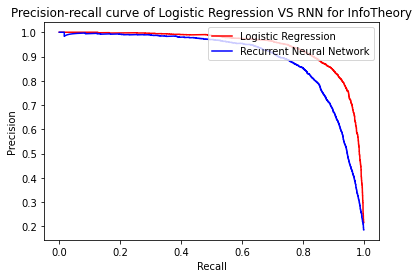

In [75]:
#Precision-recall curve for the Logistics Regression VS Recurrent Neural Networking, modelling InfoTheory
plt.plot(lr_recall_IT,lr_precision_IT,color='red',label='Logistic Regression')
plt.plot(rnn_recall_IT,rnn_precision_IT,color='blue',label='Recurrent Neural Network')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="upper right")
plt.title('Precision-recall curve of Logistic Regression VS RNN for InfoTheory')
plt.show()

In [76]:
print('AUC of Logistic Regression is: ',auc(lr_recall_IT,lr_precision_IT))
print('AUC of Recurrent Neural Network is: ',auc(rnn_recall_IT,rnn_precision_IT))

AUC of Logistic Regression is:  0.9449131759677816
AUC of Recurrent Neural Network is:  0.8970250566136058


#### Model Performance Comparison for CompVis

In [72]:
#Logistic regression
CV_predict_test=CV_model.predict(x_test)
print(confusion_matrix(y_test_CV,CV_predict_test))

#Report F1,recall,precision
recall_CV_predict_test=recall_score(y_test_CV,CV_predict_test)
precision_CV_predict_test=precision_score(y_test_CV,CV_predict_test)
f1score_CV_predict_test=f1_score(y_test_CV,CV_predict_test)
print('Precision of Logistic Regression: '+str(precision_CV_predict_test))
print('Recall of Logistic Regression: '+str(recall_CV_predict_test))
print('F1 score of Logistic Regression:'+str(f1score_CV_predict_test))

[[17470    56]
 [  908  1244]]
Precision of Logistic Regression: 0.9569230769230769
Recall of Logistic Regression: 0.5780669144981413
F1 score of Logistic Regression:0.7207415990730011


In [73]:
#RNN
print(confusion_matrix(y_test_CV_rnn,y_predict_CV))

#Report F1,recall,precision
recall_CV_predict_rnn=recall_score(y_test_CV_rnn,y_predict_CV)
precision_CV_predict_rnn=precision_score(y_test_CV_rnn,y_predict_CV)
f1score_CV_predict_rnn=f1_score(y_test_CV_rnn,y_predict_CV)
print('Precision of RNN: '+str(precision_CV_predict_rnn))
print('Recall of RNN: '+str(recall_CV_predict_rnn))
print('F1 score of RNN:'+str(f1score_CV_predict_rnn))

[[17360   166]
 [  825  1327]]
Precision of RNN: 0.8888144675150703
Recall of RNN: 0.616635687732342
F1 score of RNN:0.7281207133058984


In [74]:
#Get precision-recall curve for logistic regression
lr_precision_CV,lr_recall_CV,_=precision_recall_curve(y_test_CV,CV_model.predict_proba(x_test)[:,1])


#Get precision-recall curve for RNN
rnn_pred_CV=[]

for batch in test_iterator_CV:
    predictions = model_CV(batch.Abstract)
    rounded_preds = torch.sigmoid(predictions)
    rnn_pred_CV+=rounded_preds.tolist()

rnn_precision_CV,rnn_recall_CV,_=precision_recall_curve(y_test_CV_rnn,
                                                np.asarray([i[0] for i in rnn_pred_CV]))

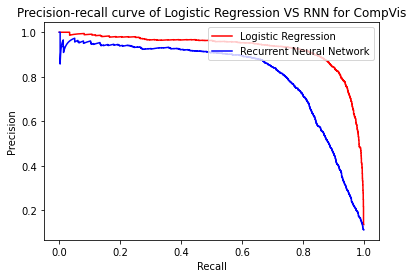

In [77]:
#Precision-recall curve for the Logistics Regression VS Recurrent Neural Networking, modelling CompVis
plt.plot(lr_recall_CV,lr_precision_CV,color='red',label='Logistic Regression')
plt.plot(rnn_recall_CV,rnn_precision_CV,color='blue',label='Recurrent Neural Network')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="upper right")
plt.title('Precision-recall curve of Logistic Regression VS RNN for CompVis')
plt.show()

In [78]:
print('AUC of Logistic Regression is: ',auc(lr_recall_CV,lr_precision_CV))
print('AUC of Recurrent Neural Network is: ',auc(rnn_recall_CV,rnn_precision_CV))

AUC of Logistic Regression is:  0.9291191926613459
AUC of Recurrent Neural Network is:  0.8117752009481692


#### Model Performance Comparison for Math

In [79]:
#Logistic regression
MA_predict_test=MA_model.predict(x_test)
print(confusion_matrix(y_test_MA,MA_predict_test))

#Report F1,recall,precision
recall_MA_predict_test=recall_score(y_test_MA,MA_predict_test)
precision_MA_predict_test=precision_score(y_test_MA,MA_predict_test)
f1score_MA_predict_test=f1_score(y_test_MA,MA_predict_test)
print('Precision of Logistic Regression: '+str(precision_MA_predict_test))
print('Recall of Logistic Regression: '+str(recall_MA_predict_test))
print('F1 score of Logistic Regression:'+str(f1score_MA_predict_test))

[[13043   705]
 [ 1763  4167]]
Precision of Logistic Regression: 0.8552955665024631
Recall of Logistic Regression: 0.7026981450252952
F1 score of Logistic Regression:0.7715237918903908


In [80]:
#RNN
print(confusion_matrix(y_test_MA_rnn,y_predict_MA))

#Report F1,recall,precision
recall_MA_predict_rnn=recall_score(y_test_MA_rnn,y_predict_MA)
precision_MA_predict_rnn=precision_score(y_test_MA_rnn,y_predict_MA)
f1score_MA_predict_rnn=f1_score(y_test_MA_rnn,y_predict_MA)
print('Precision of RNN: '+str(precision_MA_predict_rnn))
print('Recall of RNN: '+str(recall_MA_predict_rnn))
print('F1 score of RNN:'+str(f1score_MA_predict_rnn))

[[13189   559]
 [ 2635  3295]]
Precision of RNN: 0.8549558899844317
Recall of RNN: 0.5556492411467117
F1 score of RNN:0.6735486508585445


In [81]:
#Get precision-recall curve for logistic regression
lr_precision_MA,lr_recall_MA,_=precision_recall_curve(y_test_MA,MA_model.predict_proba(x_test)[:,1])


#Get precision-recall curve for RNN
rnn_pred_MA=[]

for batch in test_iterator_MA:
    predictions = model_MA(batch.Abstract)
    rounded_preds = torch.sigmoid(predictions)
    rnn_pred_MA+=rounded_preds.tolist()

rnn_precision_MA,rnn_recall_MA,_=precision_recall_curve(y_test_MA_rnn,
                                                np.asarray([i[0] for i in rnn_pred_MA]))

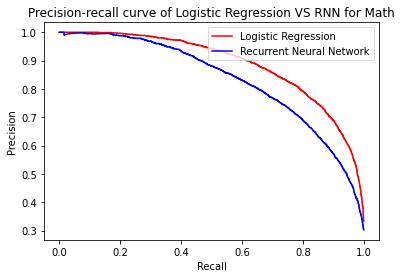

In [82]:
#Precision-recall curve for the Logistics Regression VS Recurrent Neural Networking, modelling Math
plt.plot(lr_recall_MA,lr_precision_MA,color='red',label='Logistic Regression')
plt.plot(rnn_recall_MA,rnn_precision_MA,color='blue',label='Recurrent Neural Network')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="upper right")
plt.title('Precision-recall curve of Logistic Regression VS RNN for Math')
plt.show()

In [83]:
print('AUC of Logistic Regression is: ',auc(lr_recall_MA,lr_precision_MA))
print('AUC of Recurrent Neural Network is: ',auc(rnn_recall_MA,rnn_precision_MA))

AUC of Logistic Regression is:  0.8881414334234919
AUC of Recurrent Neural Network is:  0.8323226453568793


## 2.Topic Modelling <a class="anchor" id="2"></a>

In [2]:
#To record your training process
logging.basicConfig(format='%(asctime)s: %(levelname)s : %(message)s',level=logging.INFO)

For preprocessing of Topic Modelling, we do the following:
+ Tokenize with RegexpTokenizer, convert to lowercase, remove numbers but not words with numbers, remove words that have 2 characters or less, use WordNet lemmatizer from NLTK
+ Add bi-grams, remove too rare or too common words
+ Number of topics=10

In [6]:
docs=train['Abstract'].tolist()
raw_docs=docs.copy()
len(docs)

54731

In [8]:
#Split the documenents into tokens
tokenizer_regex=RegexpTokenizer(r'\w+')

for idx in range(len(docs)):
    docs[idx]=docs[idx].lower()  #Convert to lowercase
    docs[idx]=tokenizer_regex.tokenize(docs[idx])  #Split into words

In [9]:
#Remove numbers, but not words that contain numbers
docs=[[token for token in doc if not token.isnumeric()] for doc in docs]

#Remove words that are only 1 character
docs=[[token for token in doc if len(token)>2] for doc in docs]

In [10]:
#Use Wordnet lemmetizer from NLTK
nltk.download('wordnet')

#Lemmatize the documents
lemmatizer_wn=WordNetLemmatizer()
docs=[[lemmatizer_wn.lemmatize(token) for token in doc] for doc in docs]

[nltk_data] Downloading package wordnet to C:\Users\Daniel
[nltk_data]     Tran\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [11]:
#Add bi-gram
bigram=Phrases(docs,min_count=10)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            docs[idx].append(token)

2021-10-02 20:58:58,039: INFO : collecting all words and their counts
2021-10-02 20:58:58,040: INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2021-10-02 20:58:59,279: INFO : PROGRESS: at sentence #10000, processed 1070479 words and 451922 word types
2021-10-02 20:59:00,817: INFO : PROGRESS: at sentence #20000, processed 2260425 words and 787346 word types
2021-10-02 20:59:02,211: INFO : PROGRESS: at sentence #30000, processed 3488474 words and 1089273 word types
2021-10-02 20:59:03,798: INFO : PROGRESS: at sentence #40000, processed 4714061 words and 1358918 word types
2021-10-02 20:59:05,427: INFO : PROGRESS: at sentence #50000, processed 5982188 words and 1619865 word types
2021-10-02 20:59:06,198: INFO : collected 1738512 token types (unigram + bigrams) from a corpus of 6589965 words and 54731 sentences
2021-10-02 20:59:06,198: INFO : merged Phrases<1738512 vocab, min_count=10, threshold=10.0, max_vocab_size=40000000>
2021-10-02 20:59:06,198: INFO : Phrases life

In [12]:
#Create a dictionary representation of the documents
dictionary=Dictionary(docs)

#Remove too rare or too common words
dictionary.filter_extremes(no_below=2,no_above=0.5)
print(dictionary)

2021-10-02 20:59:29,991: INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-10-02 20:59:31,225: INFO : adding document #10000 to Dictionary(32335 unique tokens: ['assuming', 'been', 'case', 'clause', 'convenient']...)
2021-10-02 20:59:32,701: INFO : adding document #20000 to Dictionary(45018 unique tokens: ['assuming', 'been', 'case', 'clause', 'convenient']...)
2021-10-02 20:59:34,159: INFO : adding document #30000 to Dictionary(54918 unique tokens: ['assuming', 'been', 'case', 'clause', 'convenient']...)
2021-10-02 20:59:35,554: INFO : adding document #40000 to Dictionary(63505 unique tokens: ['assuming', 'been', 'case', 'clause', 'convenient']...)
2021-10-02 20:59:37,052: INFO : adding document #50000 to Dictionary(71110 unique tokens: ['assuming', 'been', 'case', 'clause', 'convenient']...)
2021-10-02 20:59:37,688: INFO : built Dictionary(74645 unique tokens: ['assuming', 'been', 'case', 'clause', 'convenient']...) from 54731 documents (total 7133071 corpus positions

Dictionary(40202 unique tokens: ['assuming', 'been', 'case', 'clause', 'convenient']...)


In [13]:
#Transform documents to a vectorized form
#Bag-of-words representation of the documents
corpus=[dictionary.doc2bow(doc) for doc in docs]

In [14]:
#Check for the number of tokens and documents we have to train on
print(f'Number of unique tokens: {len(dictionary)}')
print(f'Number of documents: {len(corpus)}')

Number of unique tokens: 40202
Number of documents: 54731


Now we are ready to train LDA model

In [15]:
#Set training parameters
NUM_TOPICS=10
chunksize=1000
passes=20
iterations=400


# #Make an index to word dictionary
temp=dictionary[0]  #This is only to 'load' the dictionary
id2word=dictionary.id2token

lda_model=LdaModel(corpus=corpus,
                    id2word=id2word,
                    chunksize=chunksize,
                    alpha='auto',
                    eta='auto',
                    iterations=iterations,
                    num_topics=NUM_TOPICS,
                    passes=passes,
                    eval_every=None)

2021-10-02 21:01:04,355: INFO : using autotuned alpha, starting with [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
2021-10-02 21:01:04,361: INFO : using serial LDA version on this node
2021-10-02 21:01:04,407: INFO : running online (multi-pass) LDA training, 10 topics, 20 passes over the supplied corpus of 54731 documents, updating model once every 1000 documents, evaluating perplexity every 0 documents, iterating 400x with a convergence threshold of 0.001000
2021-10-02 21:01:04,408: INFO : PROGRESS: pass 0, at document #1000/54731
2021-10-02 21:01:06,885: INFO : optimized alpha [0.0540493, 0.074225284, 0.052814037, 0.0698396, 0.067875795, 0.064416595, 0.057056073, 0.054190185, 0.06911153, 0.06856941]
2021-10-02 21:01:06,907: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:01:06,942: INFO : topic #2 (0.053): 0.012*"learning" + 0.011*"based" + 0.010*"system" + 0.010*"language" + 0.009*"which" + 0.009*"problem" + 0.008*"grammar" + 0.007*"pape

2021-10-02 21:01:10,776: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:01:10,812: INFO : topic #7 (0.068): 0.028*"capacity" + 0.024*"program" + 0.013*"receiver" + 0.011*"mobile" + 0.009*"wireless" + 0.009*"network" + 0.008*"analysis" + 0.007*"filter" + 0.006*"paper" + 0.006*"two"
2021-10-02 21:01:10,812: INFO : topic #0 (0.070): 0.021*"bound" + 0.017*"relay" + 0.014*"transmission" + 0.012*"routing" + 0.011*"network" + 0.011*"constraint" + 0.008*"node" + 0.008*"theory" + 0.008*"message" + 0.007*"law"
2021-10-02 21:01:10,812: INFO : topic #1 (0.155): 0.014*"channel" + 0.009*"information" + 0.009*"set" + 0.008*"coding" + 0.008*"which" + 0.007*"model" + 0.007*"can" + 0.006*"result" + 0.006*"paper" + 0.005*"from"
2021-10-02 21:01:10,812: INFO : topic #9 (0.156): 0.019*"channel" + 0.010*"system" + 0.008*"model" + 0.006*"problem" + 0.006*"can" + 0.006*"information" + 0.005*"which" + 0.005*"paper" + 0.005*"block" + 0.005*"these"
2021-10-02 21:01:10,82

2021-10-02 21:01:14,004: INFO : topic #1 (0.252): 0.018*"channel" + 0.010*"coding" + 0.010*"set" + 0.008*"which" + 0.008*"information" + 0.007*"can" + 0.006*"problem" + 0.006*"result" + 0.006*"two" + 0.006*"source"
2021-10-02 21:01:14,005: INFO : topic #9 (0.252): 0.023*"channel" + 0.010*"system" + 0.007*"model" + 0.006*"user" + 0.006*"can" + 0.006*"performance" + 0.005*"information" + 0.005*"paper" + 0.005*"block" + 0.005*"design"
2021-10-02 21:01:14,007: INFO : topic diff=0.081240, rho=0.301511
2021-10-02 21:01:14,048: INFO : PROGRESS: pass 0, at document #12000/54731
2021-10-02 21:01:14,613: INFO : optimized alpha [0.10087675, 0.26727933, 0.11292051, 0.25514317, 0.16645364, 0.1319871, 0.2003247, 0.0864293, 0.13683796, 0.27458102]
2021-10-02 21:01:14,640: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:01:14,669: INFO : topic #7 (0.086): 0.046*"capacity" + 0.026*"receiver" + 0.018*"wireless" + 0.018*"user" + 0.014*"transmitter" + 0.014*"networ

2021-10-02 21:01:17,684: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:01:17,710: INFO : topic #7 (0.101): 0.037*"capacity" + 0.025*"user" + 0.025*"wireless" + 0.025*"network" + 0.024*"mobile" + 0.020*"receiver" + 0.013*"region" + 0.011*"access" + 0.010*"transmitter" + 0.008*"filter"
2021-10-02 21:01:17,711: INFO : topic #0 (0.116): 0.024*"network" + 0.019*"bound" + 0.019*"interference" + 0.018*"relay" + 0.017*"transmission" + 0.016*"rate" + 0.012*"node" + 0.012*"scheme" + 0.010*"routing" + 0.010*"constraint"
2021-10-02 21:01:17,712: INFO : topic #3 (0.337): 0.021*"network" + 0.014*"graph" + 0.010*"problem" + 0.010*"time" + 0.008*"can" + 0.007*"which" + 0.007*"number" + 0.007*"node" + 0.007*"quantum" + 0.007*"algorithm"
2021-10-02 21:01:17,714: INFO : topic #1 (0.345): 0.016*"channel" + 0.010*"set" + 0.008*"which" + 0.008*"coding" + 0.007*"information" + 0.007*"problem" + 0.007*"can" + 0.006*"two" + 0.006*"result" + 0.006*"show"
2021-10-02 21:

2021-10-02 21:01:20,668: INFO : topic #1 (0.456): 0.014*"channel" + 0.010*"set" + 0.008*"which" + 0.007*"result" + 0.007*"problem" + 0.007*"two" + 0.006*"function" + 0.006*"can" + 0.006*"show" + 0.006*"matrix"
2021-10-02 21:01:20,669: INFO : topic #9 (0.481): 0.012*"channel" + 0.009*"system" + 0.009*"model" + 0.007*"performance" + 0.007*"can" + 0.007*"information" + 0.005*"have" + 0.005*"from" + 0.005*"which" + 0.005*"paper"
2021-10-02 21:01:20,672: INFO : topic diff=0.054410, rho=0.213201
2021-10-02 21:01:20,706: INFO : PROGRESS: pass 0, at document #23000/54731
2021-10-02 21:01:21,197: INFO : optimized alpha [0.12859195, 0.47636122, 0.17170903, 0.43001693, 0.25335652, 0.22314638, 0.3353874, 0.11007198, 0.23244779, 0.5056238]
2021-10-02 21:01:21,221: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:01:21,248: INFO : topic #7 (0.110): 0.036*"capacity" + 0.029*"user" + 0.028*"network" + 0.024*"wireless" + 0.020*"mobile" + 0.019*"receiver" + 0.017*

2021-10-02 21:01:23,910: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:01:23,937: INFO : topic #7 (0.117): 0.035*"capacity" + 0.031*"network" + 0.030*"user" + 0.026*"wireless" + 0.022*"mobile" + 0.018*"receiver" + 0.015*"region" + 0.015*"access" + 0.012*"layer" + 0.012*"coding"
2021-10-02 21:01:23,940: INFO : topic #0 (0.138): 0.025*"rate" + 0.019*"relay" + 0.018*"scheme" + 0.017*"network" + 0.015*"interference" + 0.015*"bound" + 0.014*"transmission" + 0.012*"node" + 0.012*"message" + 0.011*"routing"
2021-10-02 21:01:23,942: INFO : topic #3 (0.497): 0.028*"network" + 0.020*"graph" + 0.011*"node" + 0.010*"time" + 0.008*"problem" + 0.008*"energy" + 0.008*"number" + 0.008*"can" + 0.007*"which" + 0.007*"quantum"
2021-10-02 21:01:23,943: INFO : topic #1 (0.565): 0.014*"channel" + 0.009*"set" + 0.008*"which" + 0.007*"function" + 0.007*"two" + 0.007*"result" + 0.007*"matrix" + 0.006*"problem" + 0.006*"distribution" + 0.006*"can"
2021-10-02 21:01:23,9

2021-10-02 21:01:26,606: INFO : topic #1 (0.664): 0.014*"channel" + 0.009*"set" + 0.008*"which" + 0.008*"function" + 0.007*"two" + 0.007*"distribution" + 0.007*"result" + 0.007*"matrix" + 0.006*"can" + 0.006*"show"
2021-10-02 21:01:26,608: INFO : topic #9 (0.700): 0.010*"model" + 0.008*"system" + 0.007*"information" + 0.007*"can" + 0.006*"performance" + 0.006*"channel" + 0.006*"social" + 0.006*"study" + 0.005*"from" + 0.005*"which"
2021-10-02 21:01:26,611: INFO : topic diff=0.035908, rho=0.174078
2021-10-02 21:01:26,648: INFO : PROGRESS: pass 0, at document #34000/54731
2021-10-02 21:01:27,073: INFO : optimized alpha [0.14518654, 0.6790102, 0.2083625, 0.55119663, 0.32597426, 0.28442836, 0.4522021, 0.12523066, 0.35730413, 0.7116532]
2021-10-02 21:01:27,095: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:01:27,120: INFO : topic #7 (0.125): 0.035*"capacity" + 0.034*"network" + 0.030*"user" + 0.024*"wireless" + 0.019*"mobile" + 0.019*"receiver" + 0

2021-10-02 21:01:29,686: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:01:29,712: INFO : topic #7 (0.130): 0.034*"network" + 0.033*"user" + 0.030*"capacity" + 0.025*"wireless" + 0.020*"mobile" + 0.018*"receiver" + 0.015*"region" + 0.014*"access" + 0.013*"coding" + 0.011*"interference"
2021-10-02 21:01:29,714: INFO : topic #0 (0.151): 0.028*"rate" + 0.019*"scheme" + 0.017*"relay" + 0.015*"transmission" + 0.013*"bound" + 0.013*"interference" + 0.012*"routing" + 0.011*"network" + 0.010*"noise" + 0.009*"proposed"
2021-10-02 21:01:29,715: INFO : topic #3 (0.584): 0.034*"network" + 0.022*"graph" + 0.011*"energy" + 0.011*"node" + 0.010*"time" + 0.009*"number" + 0.008*"can" + 0.007*"which" + 0.007*"quantum" + 0.007*"problem"
2021-10-02 21:01:29,716: INFO : topic #1 (0.740): 0.014*"channel" + 0.009*"set" + 0.009*"which" + 0.008*"function" + 0.007*"matrix" + 0.007*"distribution" + 0.007*"two" + 0.007*"probability" + 0.007*"result" + 0.006*"can"
2021-10-

2021-10-02 21:01:32,256: INFO : topic #1 (0.784): 0.014*"channel" + 0.009*"set" + 0.009*"which" + 0.008*"function" + 0.007*"matrix" + 0.007*"two" + 0.007*"result" + 0.007*"distribution" + 0.006*"can" + 0.006*"linear"
2021-10-02 21:01:32,257: INFO : topic #9 (0.839): 0.010*"model" + 0.008*"information" + 0.007*"system" + 0.007*"can" + 0.006*"study" + 0.006*"social" + 0.006*"from" + 0.006*"performance" + 0.006*"have" + 0.005*"which"
2021-10-02 21:01:32,261: INFO : topic diff=0.031989, rho=0.150756
2021-10-02 21:01:32,297: INFO : PROGRESS: pass 0, at document #45000/54731
2021-10-02 21:01:32,718: INFO : optimized alpha [0.1552375, 0.79041237, 0.24898915, 0.6163331, 0.39276156, 0.345545, 0.5223841, 0.13844691, 0.46790364, 0.8538059]
2021-10-02 21:01:32,740: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:01:32,766: INFO : topic #7 (0.138): 0.037*"user" + 0.035*"network" + 0.028*"capacity" + 0.023*"wireless" + 0.021*"mobile" + 0.018*"receiver" + 0.01

2021-10-02 21:01:35,158: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:01:35,186: INFO : topic #7 (0.145): 0.041*"user" + 0.035*"network" + 0.028*"capacity" + 0.023*"wireless" + 0.019*"mobile" + 0.015*"receiver" + 0.015*"region" + 0.014*"access" + 0.012*"coding" + 0.012*"layer"
2021-10-02 21:01:35,187: INFO : topic #0 (0.160): 0.027*"rate" + 0.019*"scheme" + 0.018*"transmission" + 0.013*"relay" + 0.013*"noise" + 0.012*"interference" + 0.011*"performance" + 0.011*"mimo" + 0.011*"bound" + 0.010*"signal"
2021-10-02 21:01:35,188: INFO : topic #3 (0.640): 0.032*"network" + 0.025*"graph" + 0.012*"node" + 0.011*"energy" + 0.011*"time" + 0.009*"number" + 0.008*"quantum" + 0.008*"can" + 0.008*"which" + 0.007*"edge"
2021-10-02 21:01:35,190: INFO : topic #1 (0.826): 0.015*"channel" + 0.009*"matrix" + 0.009*"which" + 0.008*"set" + 0.008*"function" + 0.007*"two" + 0.007*"distribution" + 0.007*"result" + 0.007*"can" + 0.006*"linear"
2021-10-02 21:01:35,191:

2021-10-02 21:01:37,483: INFO : topic #1 (0.874): 0.015*"channel" + 0.010*"matrix" + 0.009*"function" + 0.009*"which" + 0.008*"set" + 0.007*"result" + 0.007*"two" + 0.007*"distribution" + 0.007*"linear" + 0.007*"can"
2021-10-02 21:01:37,485: INFO : topic #9 (0.963): 0.010*"model" + 0.007*"information" + 0.007*"can" + 0.006*"social" + 0.006*"study" + 0.006*"from" + 0.006*"system" + 0.006*"network" + 0.006*"their" + 0.006*"have"
2021-10-02 21:01:37,488: INFO : topic diff=0.022820, rho=0.134840
2021-10-02 21:01:37,521: INFO : PROGRESS: pass 1, at document #1000/54731
2021-10-02 21:01:37,909: INFO : optimized alpha [0.1553051, 0.82081556, 0.26892313, 0.5893696, 0.44010103, 0.3921436, 0.52384955, 0.14399211, 0.6193653, 0.9109974]
2021-10-02 21:01:37,944: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:01:37,956: INFO : topic #7 (0.144): 0.040*"user" + 0.036*"network" + 0.025*"capacity" + 0.023*"wireless" + 0.020*"mobile" + 0.015*"region" + 0.014*"acc

2021-10-02 21:01:40,475: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:01:40,498: INFO : topic #7 (0.141): 0.038*"capacity" + 0.036*"user" + 0.032*"network" + 0.021*"wireless" + 0.018*"mobile" + 0.017*"region" + 0.016*"coding" + 0.016*"access" + 0.016*"receiver" + 0.011*"feedback"
2021-10-02 21:01:40,498: INFO : topic #0 (0.156): 0.029*"rate" + 0.019*"code" + 0.017*"scheme" + 0.014*"transmission" + 0.013*"bound" + 0.012*"relay" + 0.012*"performance" + 0.012*"noise" + 0.010*"message" + 0.010*"source"
2021-10-02 21:01:40,498: INFO : topic #8 (0.596): 0.021*"model" + 0.016*"method" + 0.015*"data" + 0.013*"based" + 0.012*"approach" + 0.011*"from" + 0.011*"language" + 0.011*"learning" + 0.009*"using" + 0.008*"feature"
2021-10-02 21:01:40,511: INFO : topic #1 (0.828): 0.018*"channel" + 0.009*"which" + 0.009*"function" + 0.008*"set" + 0.008*"matrix" + 0.008*"distribution" + 0.007*"two" + 0.007*"result" + 0.007*"can" + 0.006*"show"
2021-10-02 21:01:40

2021-10-02 21:01:43,050: INFO : topic #9 (0.844): 0.010*"model" + 0.008*"information" + 0.007*"can" + 0.007*"system" + 0.006*"from" + 0.006*"have" + 0.006*"study" + 0.006*"their" + 0.005*"which" + 0.005*"between"
2021-10-02 21:01:43,051: INFO : topic #1 (0.884): 0.026*"channel" + 0.009*"which" + 0.008*"matrix" + 0.008*"function" + 0.008*"two" + 0.007*"set" + 0.007*"distribution" + 0.007*"result" + 0.007*"can" + 0.006*"linear"
2021-10-02 21:01:43,055: INFO : topic diff=0.030683, rho=0.132767
2021-10-02 21:01:43,096: INFO : PROGRESS: pass 1, at document #12000/54731
2021-10-02 21:01:43,497: INFO : optimized alpha [0.17367125, 0.88300323, 0.27643386, 0.601621, 0.50967276, 0.39598027, 0.51788926, 0.1486799, 0.5465278, 0.8490274]
2021-10-02 21:01:43,523: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:01:43,554: INFO : topic #7 (0.149): 0.048*"capacity" + 0.040*"user" + 0.034*"network" + 0.024*"wireless" + 0.020*"coding" + 0.019*"region" + 0.019*"rec

2021-10-02 21:01:45,932: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:01:45,964: INFO : topic #7 (0.157): 0.043*"network" + 0.040*"capacity" + 0.038*"user" + 0.028*"wireless" + 0.021*"interference" + 0.020*"mobile" + 0.019*"region" + 0.019*"coding" + 0.015*"receiver" + 0.014*"access"
2021-10-02 21:01:45,965: INFO : topic #0 (0.181): 0.031*"rate" + 0.020*"code" + 0.017*"relay" + 0.016*"scheme" + 0.015*"transmission" + 0.013*"bound" + 0.011*"source" + 0.011*"performance" + 0.011*"noise" + 0.011*"signal"
2021-10-02 21:01:45,966: INFO : topic #3 (0.627): 0.034*"network" + 0.024*"graph" + 0.014*"node" + 0.011*"quantum" + 0.010*"number" + 0.010*"time" + 0.008*"can" + 0.008*"energy" + 0.007*"which" + 0.007*"scheme"
2021-10-02 21:01:45,967: INFO : topic #1 (0.877): 0.028*"channel" + 0.009*"which" + 0.009*"matrix" + 0.008*"two" + 0.008*"function" + 0.007*"result" + 0.007*"set" + 0.007*"distribution" + 0.007*"can" + 0.006*"show"
2021-10-02 21:01:45,969

2021-10-02 21:01:48,693: INFO : topic #1 (0.922): 0.025*"channel" + 0.009*"which" + 0.009*"matrix" + 0.008*"function" + 0.008*"two" + 0.008*"result" + 0.007*"distribution" + 0.007*"set" + 0.007*"can" + 0.006*"state"
2021-10-02 21:01:48,695: INFO : topic #9 (0.927): 0.011*"model" + 0.008*"information" + 0.007*"can" + 0.006*"system" + 0.006*"have" + 0.006*"network" + 0.006*"study" + 0.006*"their" + 0.006*"from" + 0.006*"which"
2021-10-02 21:01:48,699: INFO : topic diff=0.024796, rho=0.132767
2021-10-02 21:01:48,744: INFO : PROGRESS: pass 1, at document #23000/54731
2021-10-02 21:01:49,223: INFO : optimized alpha [0.1861577, 0.9297472, 0.2836118, 0.6542623, 0.5369582, 0.42547706, 0.56589746, 0.16053732, 0.5646188, 0.9412143]
2021-10-02 21:01:49,256: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:01:49,301: INFO : topic #7 (0.161): 0.044*"network" + 0.037*"user" + 0.037*"capacity" + 0.027*"wireless" + 0.023*"interference" + 0.021*"region" + 0.018*"

2021-10-02 21:01:51,440: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:01:51,461: INFO : topic #7 (0.163): 0.045*"network" + 0.035*"capacity" + 0.035*"user" + 0.028*"wireless" + 0.022*"interference" + 0.020*"coding" + 0.019*"mobile" + 0.019*"region" + 0.015*"access" + 0.014*"feedback"
2021-10-02 21:01:51,461: INFO : topic #0 (0.190): 0.031*"rate" + 0.019*"code" + 0.018*"relay" + 0.018*"scheme" + 0.014*"transmission" + 0.013*"performance" + 0.013*"source" + 0.012*"bound" + 0.011*"signal" + 0.011*"noise"
2021-10-02 21:01:51,461: INFO : topic #3 (0.674): 0.037*"network" + 0.028*"graph" + 0.018*"node" + 0.010*"number" + 0.010*"time" + 0.009*"quantum" + 0.009*"energy" + 0.008*"can" + 0.008*"edge" + 0.007*"vertex"
2021-10-02 21:01:51,468: INFO : topic #1 (0.951): 0.022*"channel" + 0.009*"which" + 0.009*"matrix" + 0.009*"function" + 0.008*"two" + 0.008*"distribution" + 0.008*"result" + 0.007*"state" + 0.007*"set" + 0.006*"can"
2021-10-02 21:01:51,469

2021-10-02 21:01:53,730: INFO : topic #1 (0.998): 0.020*"channel" + 0.009*"which" + 0.009*"function" + 0.008*"matrix" + 0.008*"distribution" + 0.008*"two" + 0.008*"result" + 0.007*"state" + 0.007*"can" + 0.006*"set"
2021-10-02 21:01:53,732: INFO : topic #9 (1.034): 0.012*"model" + 0.008*"information" + 0.007*"network" + 0.007*"can" + 0.007*"study" + 0.006*"have" + 0.006*"their" + 0.006*"from" + 0.006*"which" + 0.006*"system"
2021-10-02 21:01:53,735: INFO : topic diff=0.021571, rho=0.132767
2021-10-02 21:01:53,772: INFO : PROGRESS: pass 1, at document #34000/54731
2021-10-02 21:01:54,134: INFO : optimized alpha [0.19253062, 1.0042944, 0.2851617, 0.68115216, 0.5526691, 0.44189402, 0.6164398, 0.16422422, 0.6416414, 1.0375468]
2021-10-02 21:01:54,168: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:01:54,210: INFO : topic #7 (0.164): 0.046*"network" + 0.035*"capacity" + 0.034*"user" + 0.026*"wireless" + 0.023*"interference" + 0.020*"coding" + 0.019*

2021-10-02 21:01:56,562: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:01:56,590: INFO : topic #7 (0.165): 0.045*"network" + 0.036*"user" + 0.031*"capacity" + 0.027*"wireless" + 0.023*"interference" + 0.019*"mobile" + 0.019*"coding" + 0.018*"region" + 0.014*"access" + 0.014*"feedback"
2021-10-02 21:01:56,592: INFO : topic #0 (0.194): 0.032*"rate" + 0.018*"scheme" + 0.017*"relay" + 0.017*"code" + 0.015*"transmission" + 0.015*"performance" + 0.013*"noise" + 0.012*"source" + 0.012*"signal" + 0.011*"proposed"
2021-10-02 21:01:56,593: INFO : topic #3 (0.683): 0.040*"network" + 0.028*"graph" + 0.016*"node" + 0.012*"energy" + 0.011*"number" + 0.009*"time" + 0.009*"quantum" + 0.008*"edge" + 0.008*"can" + 0.007*"which"
2021-10-02 21:01:56,595: INFO : topic #1 (1.014): 0.018*"channel" + 0.009*"function" + 0.009*"which" + 0.009*"probability" + 0.009*"matrix" + 0.008*"distribution" + 0.008*"two" + 0.007*"result" + 0.007*"state" + 0.007*"can"
2021-10-02 21

2021-10-02 21:01:59,043: INFO : topic #1 (1.016): 0.018*"channel" + 0.009*"which" + 0.009*"function" + 0.009*"matrix" + 0.008*"two" + 0.008*"distribution" + 0.008*"probability" + 0.008*"state" + 0.008*"result" + 0.007*"linear"
2021-10-02 21:01:59,045: INFO : topic #9 (1.092): 0.011*"model" + 0.008*"information" + 0.008*"network" + 0.007*"can" + 0.007*"study" + 0.007*"have" + 0.006*"their" + 0.006*"from" + 0.006*"which" + 0.006*"social"
2021-10-02 21:01:59,047: INFO : topic diff=0.023116, rho=0.132767
2021-10-02 21:01:59,082: INFO : PROGRESS: pass 1, at document #45000/54731
2021-10-02 21:01:59,440: INFO : optimized alpha [0.19404803, 1.0131103, 0.30395326, 0.6877056, 0.57452434, 0.47266766, 0.639106, 0.16744204, 0.69322413, 1.1024123]
2021-10-02 21:01:59,464: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:01:59,493: INFO : topic #7 (0.167): 0.044*"network" + 0.039*"user" + 0.028*"capacity" + 0.025*"wireless" + 0.021*"interference" + 0.021*"mobi

2021-10-02 21:02:01,927: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:02:01,957: INFO : topic #7 (0.170): 0.043*"user" + 0.043*"network" + 0.029*"capacity" + 0.025*"wireless" + 0.019*"interference" + 0.018*"mobile" + 0.016*"region" + 0.016*"coding" + 0.015*"access" + 0.012*"feedback"
2021-10-02 21:02:01,958: INFO : topic #0 (0.196): 0.029*"rate" + 0.018*"scheme" + 0.017*"transmission" + 0.016*"code" + 0.016*"performance" + 0.015*"signal" + 0.014*"noise" + 0.013*"relay" + 0.011*"proposed" + 0.011*"source"
2021-10-02 21:02:01,959: INFO : topic #8 (0.719): 0.021*"method" + 0.020*"model" + 0.019*"data" + 0.015*"based" + 0.015*"approach" + 0.014*"learning" + 0.011*"from" + 0.010*"using" + 0.010*"feature" + 0.007*"our"
2021-10-02 21:02:01,961: INFO : topic #1 (1.021): 0.018*"channel" + 0.010*"matrix" + 0.009*"which" + 0.009*"function" + 0.008*"two" + 0.008*"state" + 0.008*"distribution" + 0.008*"result" + 0.007*"can" + 0.007*"probability"
2021-10-0

2021-10-02 21:02:04,152: INFO : topic #1 (1.048): 0.016*"channel" + 0.010*"matrix" + 0.010*"function" + 0.009*"which" + 0.008*"state" + 0.008*"result" + 0.008*"two" + 0.007*"distribution" + 0.007*"linear" + 0.007*"can"
2021-10-02 21:02:04,153: INFO : topic #9 (1.169): 0.012*"model" + 0.008*"network" + 0.008*"information" + 0.007*"can" + 0.007*"study" + 0.007*"from" + 0.007*"their" + 0.007*"have" + 0.006*"social" + 0.006*"different"
2021-10-02 21:02:04,156: INFO : topic diff=0.018813, rho=0.132767
2021-10-02 21:02:04,192: INFO : PROGRESS: pass 2, at document #1000/54731
2021-10-02 21:02:04,527: INFO : optimized alpha [0.18570474, 0.9794202, 0.30956262, 0.6308173, 0.58934236, 0.4933243, 0.606025, 0.16479006, 0.8166656, 1.1169186]
2021-10-02 21:02:04,568: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:02:04,594: INFO : topic #7 (0.165): 0.043*"user" + 0.042*"network" + 0.026*"capacity" + 0.026*"wireless" + 0.020*"mobile" + 0.018*"interference" + 0

2021-10-02 21:02:06,581: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:02:06,609: INFO : topic #7 (0.160): 0.038*"capacity" + 0.038*"network" + 0.037*"user" + 0.023*"wireless" + 0.020*"coding" + 0.018*"mobile" + 0.018*"region" + 0.016*"access" + 0.015*"feedback" + 0.014*"interference"
2021-10-02 21:02:06,611: INFO : topic #0 (0.183): 0.030*"rate" + 0.025*"code" + 0.017*"scheme" + 0.015*"performance" + 0.014*"transmission" + 0.014*"noise" + 0.013*"signal" + 0.012*"relay" + 0.012*"source" + 0.012*"bound"
2021-10-02 21:02:06,612: INFO : topic #8 (0.756): 0.020*"model" + 0.018*"method" + 0.015*"based" + 0.015*"data" + 0.013*"approach" + 0.011*"from" + 0.010*"learning" + 0.010*"language" + 0.010*"using" + 0.008*"feature"
2021-10-02 21:02:06,613: INFO : topic #1 (0.970): 0.019*"channel" + 0.009*"function" + 0.009*"which" + 0.008*"distribution" + 0.008*"matrix" + 0.008*"two" + 0.008*"state" + 0.008*"result" + 0.007*"error" + 0.007*"probability"
2021-

2021-10-02 21:02:09,050: INFO : topic #9 (1.002): 0.011*"model" + 0.009*"information" + 0.007*"can" + 0.007*"have" + 0.007*"from" + 0.007*"network" + 0.007*"study" + 0.007*"their" + 0.006*"these" + 0.006*"which"
2021-10-02 21:02:09,051: INFO : topic #1 (1.019): 0.027*"channel" + 0.009*"which" + 0.009*"matrix" + 0.008*"function" + 0.008*"error" + 0.008*"distribution" + 0.008*"two" + 0.008*"result" + 0.007*"state" + 0.007*"can"
2021-10-02 21:02:09,054: INFO : topic diff=0.028480, rho=0.131612
2021-10-02 21:02:09,095: INFO : PROGRESS: pass 2, at document #12000/54731
2021-10-02 21:02:09,445: INFO : optimized alpha [0.20133266, 1.0152792, 0.30484638, 0.634901, 0.6423131, 0.47563106, 0.5804431, 0.16625804, 0.6708437, 1.0047362]
2021-10-02 21:02:09,468: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:02:09,496: INFO : topic #7 (0.166): 0.048*"capacity" + 0.040*"user" + 0.039*"network" + 0.025*"wireless" + 0.024*"coding" + 0.022*"interference" + 0.021*

2021-10-02 21:02:11,580: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:02:11,608: INFO : topic #7 (0.174): 0.049*"network" + 0.040*"capacity" + 0.038*"user" + 0.029*"wireless" + 0.026*"interference" + 0.022*"coding" + 0.020*"region" + 0.020*"mobile" + 0.016*"feedback" + 0.014*"access"
2021-10-02 21:02:11,609: INFO : topic #0 (0.207): 0.032*"rate" + 0.023*"code" + 0.017*"relay" + 0.016*"transmission" + 0.015*"scheme" + 0.013*"signal" + 0.013*"performance" + 0.013*"source" + 0.013*"bound" + 0.012*"noise"
2021-10-02 21:02:11,610: INFO : topic #8 (0.668): 0.019*"model" + 0.019*"method" + 0.016*"based" + 0.016*"data" + 0.013*"approach" + 0.011*"from" + 0.011*"using" + 0.010*"learning" + 0.009*"feature" + 0.008*"gaussian"
2021-10-02 21:02:11,611: INFO : topic #1 (0.993): 0.028*"channel" + 0.010*"which" + 0.009*"matrix" + 0.009*"error" + 0.008*"function" + 0.008*"two" + 0.008*"result" + 0.008*"distribution" + 0.007*"state" + 0.007*"case"
2021-10-02 2

2021-10-02 21:02:14,065: INFO : topic #1 (1.031): 0.025*"channel" + 0.009*"which" + 0.009*"matrix" + 0.009*"function" + 0.008*"result" + 0.008*"error" + 0.008*"two" + 0.008*"distribution" + 0.008*"state" + 0.007*"can"
2021-10-02 21:02:14,066: INFO : topic #9 (1.067): 0.012*"model" + 0.008*"information" + 0.008*"network" + 0.007*"can" + 0.007*"have" + 0.007*"study" + 0.007*"their" + 0.006*"from" + 0.006*"different" + 0.006*"which"
2021-10-02 21:02:14,069: INFO : topic diff=0.023054, rho=0.131612
2021-10-02 21:02:14,107: INFO : PROGRESS: pass 2, at document #23000/54731
2021-10-02 21:02:14,467: INFO : optimized alpha [0.20907193, 1.0368046, 0.3039819, 0.6783865, 0.64486897, 0.49149933, 0.61975265, 0.17505074, 0.67003626, 1.0800124]
2021-10-02 21:02:14,490: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:02:14,518: INFO : topic #7 (0.175): 0.049*"network" + 0.037*"user" + 0.037*"capacity" + 0.029*"wireless" + 0.027*"interference" + 0.022*"region" +

2021-10-02 21:02:16,491: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:02:16,517: INFO : topic #7 (0.176): 0.050*"network" + 0.036*"user" + 0.035*"capacity" + 0.029*"wireless" + 0.027*"interference" + 0.022*"coding" + 0.020*"region" + 0.019*"mobile" + 0.016*"feedback" + 0.015*"access"
2021-10-02 21:02:16,518: INFO : topic #0 (0.212): 0.032*"rate" + 0.022*"code" + 0.019*"relay" + 0.017*"scheme" + 0.015*"performance" + 0.015*"source" + 0.014*"transmission" + 0.014*"signal" + 0.013*"noise" + 0.011*"routing"
2021-10-02 21:02:16,519: INFO : topic #8 (0.697): 0.022*"method" + 0.021*"model" + 0.018*"data" + 0.017*"based" + 0.014*"approach" + 0.012*"learning" + 0.011*"using" + 0.011*"from" + 0.009*"feature" + 0.008*"technique"
2021-10-02 21:02:16,520: INFO : topic #1 (1.052): 0.022*"channel" + 0.009*"which" + 0.009*"function" + 0.009*"matrix" + 0.008*"two" + 0.008*"state" + 0.008*"distribution" + 0.008*"result" + 0.008*"error" + 0.007*"condition"
2021

2021-10-02 21:02:18,625: INFO : topic #1 (1.092): 0.020*"channel" + 0.009*"which" + 0.009*"function" + 0.009*"matrix" + 0.009*"state" + 0.009*"distribution" + 0.008*"two" + 0.008*"result" + 0.008*"error" + 0.007*"probability"
2021-10-02 21:02:18,626: INFO : topic #9 (1.161): 0.013*"model" + 0.009*"network" + 0.009*"information" + 0.007*"have" + 0.007*"study" + 0.007*"can" + 0.007*"their" + 0.007*"from" + 0.006*"which" + 0.006*"different"
2021-10-02 21:02:18,628: INFO : topic diff=0.019824, rho=0.131612
2021-10-02 21:02:18,664: INFO : PROGRESS: pass 2, at document #34000/54731
2021-10-02 21:02:19,095: INFO : optimized alpha [0.21136312, 1.0977982, 0.2998579, 0.6953644, 0.6396136, 0.49604613, 0.66120136, 0.17709847, 0.73813903, 1.1617446]
2021-10-02 21:02:19,129: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:02:19,157: INFO : topic #7 (0.177): 0.050*"network" + 0.035*"capacity" + 0.035*"user" + 0.028*"wireless" + 0.027*"interference" + 0.022*"co

2021-10-02 21:02:21,351: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:02:21,385: INFO : topic #7 (0.176): 0.048*"network" + 0.036*"user" + 0.031*"capacity" + 0.028*"wireless" + 0.026*"interference" + 0.021*"coding" + 0.019*"mobile" + 0.018*"region" + 0.016*"feedback" + 0.014*"access"
2021-10-02 21:02:21,388: INFO : topic #0 (0.212): 0.033*"rate" + 0.019*"code" + 0.018*"scheme" + 0.018*"relay" + 0.016*"performance" + 0.015*"transmission" + 0.014*"signal" + 0.014*"noise" + 0.013*"source" + 0.012*"proposed"
2021-10-02 21:02:21,392: INFO : topic #8 (0.759): 0.022*"method" + 0.021*"model" + 0.018*"data" + 0.017*"based" + 0.015*"approach" + 0.012*"learning" + 0.011*"using" + 0.010*"from" + 0.009*"feature" + 0.008*"technique"
2021-10-02 21:02:21,393: INFO : topic #1 (1.098): 0.018*"channel" + 0.010*"probability" + 0.010*"function" + 0.009*"which" + 0.009*"matrix" + 0.009*"state" + 0.009*"distribution" + 0.008*"error" + 0.008*"two" + 0.008*"result"
2

2021-10-02 21:02:23,849: INFO : topic #1 (1.091): 0.018*"channel" + 0.009*"function" + 0.009*"which" + 0.009*"state" + 0.009*"matrix" + 0.009*"probability" + 0.008*"distribution" + 0.008*"two" + 0.008*"result" + 0.008*"error"
2021-10-02 21:02:23,850: INFO : topic #9 (1.200): 0.012*"model" + 0.009*"network" + 0.009*"information" + 0.007*"have" + 0.007*"study" + 0.007*"can" + 0.007*"their" + 0.007*"from" + 0.006*"which" + 0.006*"these"
2021-10-02 21:02:23,853: INFO : topic diff=0.021527, rho=0.131612
2021-10-02 21:02:23,888: INFO : PROGRESS: pass 2, at document #45000/54731
2021-10-02 21:02:24,273: INFO : optimized alpha [0.20877092, 1.0861857, 0.31446776, 0.6945095, 0.64612573, 0.518511, 0.67621505, 0.17851132, 0.7761632, 1.2091419]
2021-10-02 21:02:24,298: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:02:24,320: INFO : topic #7 (0.179): 0.047*"network" + 0.040*"user" + 0.028*"capacity" + 0.026*"wireless" + 0.023*"interference" + 0.020*"mobile"

2021-10-02 21:02:26,300: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:02:26,326: INFO : topic #7 (0.181): 0.045*"network" + 0.044*"user" + 0.029*"capacity" + 0.026*"wireless" + 0.021*"interference" + 0.018*"mobile" + 0.017*"coding" + 0.016*"region" + 0.015*"access" + 0.013*"feedback"
2021-10-02 21:02:26,327: INFO : topic #0 (0.209): 0.029*"rate" + 0.018*"code" + 0.018*"scheme" + 0.018*"signal" + 0.018*"transmission" + 0.017*"performance" + 0.015*"noise" + 0.013*"relay" + 0.013*"system" + 0.012*"proposed"
2021-10-02 21:02:26,328: INFO : topic #8 (0.797): 0.022*"method" + 0.020*"model" + 0.018*"data" + 0.017*"based" + 0.016*"approach" + 0.013*"learning" + 0.011*"from" + 0.011*"using" + 0.010*"feature" + 0.008*"our"
2021-10-02 21:02:26,329: INFO : topic #1 (1.088): 0.018*"channel" + 0.010*"matrix" + 0.009*"function" + 0.009*"which" + 0.009*"state" + 0.008*"distribution" + 0.008*"result" + 0.008*"two" + 0.008*"error" + 0.008*"probability"
2021-10

2021-10-02 21:02:28,441: INFO : topic #1 (1.110): 0.016*"channel" + 0.010*"matrix" + 0.010*"function" + 0.009*"which" + 0.009*"state" + 0.008*"result" + 0.008*"error" + 0.008*"two" + 0.008*"distribution" + 0.007*"probability"
2021-10-02 21:02:28,442: INFO : topic #9 (1.264): 0.012*"model" + 0.009*"network" + 0.008*"information" + 0.007*"study" + 0.007*"have" + 0.007*"can" + 0.007*"from" + 0.007*"their" + 0.006*"different" + 0.006*"which"
2021-10-02 21:02:28,445: INFO : topic diff=0.017803, rho=0.131612
2021-10-02 21:02:28,483: INFO : PROGRESS: pass 3, at document #1000/54731
2021-10-02 21:02:28,787: INFO : optimized alpha [0.19727416, 1.0359154, 0.31569734, 0.6347399, 0.6509814, 0.5320137, 0.6360798, 0.17381167, 0.89649105, 1.2137284]
2021-10-02 21:02:28,817: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:02:28,843: INFO : topic #7 (0.174): 0.045*"network" + 0.043*"user" + 0.027*"wireless" + 0.026*"capacity" + 0.020*"interference" + 0.020*"mobi

2021-10-02 21:02:30,810: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:02:30,836: INFO : topic #7 (0.168): 0.040*"network" + 0.038*"capacity" + 0.037*"user" + 0.024*"wireless" + 0.022*"coding" + 0.018*"mobile" + 0.018*"region" + 0.016*"feedback" + 0.016*"access" + 0.015*"interference"
2021-10-02 21:02:30,837: INFO : topic #0 (0.194): 0.031*"rate" + 0.026*"code" + 0.017*"scheme" + 0.016*"performance" + 0.015*"signal" + 0.014*"transmission" + 0.014*"noise" + 0.013*"source" + 0.013*"relay" + 0.012*"system"
2021-10-02 21:02:30,839: INFO : topic #8 (0.824): 0.020*"model" + 0.019*"method" + 0.016*"based" + 0.015*"data" + 0.014*"approach" + 0.011*"from" + 0.010*"learning" + 0.010*"using" + 0.009*"language" + 0.008*"feature"
2021-10-02 21:02:30,840: INFO : topic #1 (1.022): 0.020*"channel" + 0.010*"function" + 0.009*"which" + 0.009*"error" + 0.009*"state" + 0.008*"distribution" + 0.008*"matrix" + 0.008*"result" + 0.008*"two" + 0.008*"probability"
2021

2021-10-02 21:02:32,890: INFO : topic #1 (1.070): 0.027*"channel" + 0.010*"error" + 0.010*"which" + 0.009*"matrix" + 0.009*"function" + 0.008*"distribution" + 0.008*"result" + 0.008*"two" + 0.008*"state" + 0.007*"case"
2021-10-02 21:02:32,891: INFO : topic #9 (1.080): 0.012*"model" + 0.009*"information" + 0.008*"have" + 0.007*"can" + 0.007*"network" + 0.007*"from" + 0.007*"their" + 0.007*"study" + 0.007*"these" + 0.006*"which"
2021-10-02 21:02:32,894: INFO : topic diff=0.027331, rho=0.130487
2021-10-02 21:02:32,936: INFO : PROGRESS: pass 3, at document #12000/54731
2021-10-02 21:02:33,280: INFO : optimized alpha [0.21104819, 1.0653424, 0.30777007, 0.63724935, 0.6997399, 0.5074946, 0.60428524, 0.17481162, 0.7269662, 1.0816073]
2021-10-02 21:02:33,304: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:02:33,331: INFO : topic #7 (0.175): 0.047*"capacity" + 0.042*"network" + 0.040*"user" + 0.026*"wireless" + 0.026*"coding" + 0.023*"interference" + 0.0

2021-10-02 21:02:35,286: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:02:35,321: INFO : topic #7 (0.183): 0.052*"network" + 0.039*"capacity" + 0.038*"user" + 0.030*"wireless" + 0.027*"interference" + 0.023*"coding" + 0.020*"region" + 0.019*"mobile" + 0.017*"feedback" + 0.014*"access"
2021-10-02 21:02:35,322: INFO : topic #0 (0.216): 0.032*"rate" + 0.025*"code" + 0.017*"relay" + 0.016*"transmission" + 0.015*"scheme" + 0.015*"signal" + 0.014*"performance" + 0.013*"source" + 0.013*"noise" + 0.012*"bound"
2021-10-02 21:02:35,323: INFO : topic #8 (0.721): 0.021*"method" + 0.019*"model" + 0.017*"based" + 0.016*"data" + 0.014*"approach" + 0.011*"using" + 0.011*"from" + 0.010*"learning" + 0.009*"feature" + 0.008*"technique"
2021-10-02 21:02:35,324: INFO : topic #1 (1.039): 0.028*"channel" + 0.010*"error" + 0.010*"which" + 0.009*"matrix" + 0.009*"function" + 0.008*"result" + 0.008*"two" + 0.008*"distribution" + 0.008*"state" + 0.007*"case"
2021-10-02 

2021-10-02 21:02:37,282: INFO : topic #1 (1.075): 0.025*"channel" + 0.010*"which" + 0.009*"error" + 0.009*"matrix" + 0.009*"function" + 0.009*"result" + 0.008*"state" + 0.008*"two" + 0.008*"distribution" + 0.007*"case"
2021-10-02 21:02:37,284: INFO : topic #9 (1.139): 0.013*"model" + 0.009*"information" + 0.008*"network" + 0.008*"have" + 0.007*"can" + 0.007*"their" + 0.007*"study" + 0.007*"from" + 0.007*"which" + 0.007*"different"
2021-10-02 21:02:37,287: INFO : topic diff=0.022214, rho=0.130487
2021-10-02 21:02:37,323: INFO : PROGRESS: pass 3, at document #23000/54731
2021-10-02 21:02:37,638: INFO : optimized alpha [0.21750471, 1.0800996, 0.30520114, 0.67952144, 0.69382614, 0.5194798, 0.64193803, 0.18351167, 0.7215327, 1.1515675]
2021-10-02 21:02:37,672: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:02:37,706: INFO : topic #7 (0.184): 0.051*"network" + 0.037*"user" + 0.036*"capacity" + 0.029*"wireless" + 0.028*"interference" + 0.022*"region" 

2021-10-02 21:02:40,396: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:02:40,431: INFO : topic #7 (0.185): 0.052*"network" + 0.035*"user" + 0.035*"capacity" + 0.030*"wireless" + 0.027*"interference" + 0.023*"coding" + 0.019*"region" + 0.019*"mobile" + 0.016*"feedback" + 0.015*"sensor"
2021-10-02 21:02:40,431: INFO : topic #0 (0.219): 0.032*"rate" + 0.023*"code" + 0.019*"relay" + 0.017*"scheme" + 0.016*"performance" + 0.015*"signal" + 0.015*"source" + 0.014*"transmission" + 0.013*"noise" + 0.011*"routing"
2021-10-02 21:02:40,431: INFO : topic #8 (0.748): 0.023*"method" + 0.020*"model" + 0.018*"based" + 0.018*"data" + 0.015*"approach" + 0.012*"learning" + 0.011*"using" + 0.011*"from" + 0.009*"feature" + 0.008*"technique"
2021-10-02 21:02:40,438: INFO : topic #1 (1.094): 0.022*"channel" + 0.010*"which" + 0.009*"function" + 0.009*"state" + 0.009*"matrix" + 0.009*"error" + 0.008*"distribution" + 0.008*"two" + 0.008*"result" + 0.007*"case"
2021-10-0

2021-10-02 21:02:42,281: INFO : topic #1 (1.133): 0.020*"channel" + 0.010*"function" + 0.010*"which" + 0.009*"state" + 0.009*"distribution" + 0.009*"error" + 0.009*"matrix" + 0.008*"result" + 0.008*"two" + 0.008*"probability"
2021-10-02 21:02:42,288: INFO : topic #9 (1.228): 0.013*"model" + 0.009*"network" + 0.009*"information" + 0.008*"have" + 0.007*"study" + 0.007*"their" + 0.007*"can" + 0.007*"from" + 0.007*"which" + 0.006*"these"
2021-10-02 21:02:42,291: INFO : topic diff=0.019049, rho=0.130487
2021-10-02 21:02:42,323: INFO : PROGRESS: pass 3, at document #34000/54731
2021-10-02 21:02:42,607: INFO : optimized alpha [0.21856582, 1.1383545, 0.30097064, 0.6936328, 0.68115985, 0.52018696, 0.6805646, 0.1851284, 0.7874003, 1.228294]
2021-10-02 21:02:42,635: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:02:42,663: INFO : topic #7 (0.185): 0.053*"network" + 0.034*"capacity" + 0.034*"user" + 0.028*"wireless" + 0.027*"interference" + 0.022*"coding" 

2021-10-02 21:02:44,988: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:02:45,022: INFO : topic #7 (0.184): 0.051*"network" + 0.036*"user" + 0.030*"capacity" + 0.028*"wireless" + 0.026*"interference" + 0.021*"coding" + 0.019*"sensor" + 0.018*"mobile" + 0.017*"region" + 0.016*"feedback"
2021-10-02 21:02:45,024: INFO : topic #0 (0.218): 0.033*"rate" + 0.020*"code" + 0.018*"relay" + 0.018*"scheme" + 0.017*"performance" + 0.016*"signal" + 0.015*"transmission" + 0.014*"noise" + 0.014*"source" + 0.012*"proposed"
2021-10-02 21:02:45,025: INFO : topic #8 (0.806): 0.023*"method" + 0.021*"model" + 0.018*"based" + 0.018*"data" + 0.016*"approach" + 0.012*"learning" + 0.011*"using" + 0.010*"from" + 0.009*"feature" + 0.008*"technique"
2021-10-02 21:02:45,026: INFO : topic #1 (1.136): 0.018*"channel" + 0.010*"probability" + 0.010*"function" + 0.010*"which" + 0.009*"state" + 0.009*"error" + 0.009*"matrix" + 0.009*"distribution" + 0.008*"result" + 0.008*"two"
2

2021-10-02 21:02:47,268: INFO : topic #1 (1.125): 0.018*"channel" + 0.010*"function" + 0.010*"which" + 0.009*"state" + 0.009*"probability" + 0.009*"error" + 0.009*"matrix" + 0.008*"result" + 0.008*"distribution" + 0.008*"two"
2021-10-02 21:02:47,269: INFO : topic #9 (1.261): 0.013*"model" + 0.009*"network" + 0.009*"information" + 0.008*"have" + 0.008*"study" + 0.007*"can" + 0.007*"their" + 0.007*"from" + 0.007*"which" + 0.006*"these"
2021-10-02 21:02:47,272: INFO : topic diff=0.020633, rho=0.130487
2021-10-02 21:02:47,308: INFO : PROGRESS: pass 3, at document #45000/54731
2021-10-02 21:02:47,612: INFO : optimized alpha [0.21511878, 1.1197866, 0.31432956, 0.6915079, 0.68134594, 0.5404016, 0.6935415, 0.18593584, 0.82122177, 1.2700698]
2021-10-02 21:02:47,655: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:02:47,689: INFO : topic #7 (0.186): 0.049*"network" + 0.039*"user" + 0.028*"capacity" + 0.027*"wireless" + 0.023*"interference" + 0.020*"mobile

2021-10-02 21:02:49,843: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:02:49,866: INFO : topic #7 (0.188): 0.047*"network" + 0.043*"user" + 0.028*"capacity" + 0.027*"wireless" + 0.021*"interference" + 0.019*"sensor" + 0.018*"mobile" + 0.017*"coding" + 0.016*"region" + 0.015*"access"
2021-10-02 21:02:49,866: INFO : topic #0 (0.215): 0.029*"rate" + 0.019*"code" + 0.019*"signal" + 0.018*"scheme" + 0.018*"transmission" + 0.018*"performance" + 0.016*"noise" + 0.013*"system" + 0.013*"relay" + 0.012*"source"
2021-10-02 21:02:49,866: INFO : topic #8 (0.840): 0.023*"method" + 0.020*"model" + 0.018*"data" + 0.018*"based" + 0.016*"approach" + 0.013*"learning" + 0.011*"using" + 0.011*"from" + 0.010*"feature" + 0.008*"our"
2021-10-02 21:02:49,866: INFO : topic #1 (1.119): 0.018*"channel" + 0.010*"matrix" + 0.010*"function" + 0.010*"state" + 0.009*"which" + 0.008*"error" + 0.008*"result" + 0.008*"distribution" + 0.008*"two" + 0.008*"probability"
2021-10-02 

2021-10-02 21:02:51,845: INFO : topic #1 (1.140): 0.016*"channel" + 0.010*"matrix" + 0.010*"function" + 0.009*"which" + 0.009*"state" + 0.008*"error" + 0.008*"result" + 0.008*"distribution" + 0.008*"two" + 0.007*"probability"
2021-10-02 21:02:51,846: INFO : topic #9 (1.320): 0.013*"model" + 0.009*"network" + 0.008*"information" + 0.008*"have" + 0.008*"study" + 0.007*"from" + 0.007*"can" + 0.007*"their" + 0.007*"different" + 0.007*"which"
2021-10-02 21:02:51,849: INFO : topic diff=0.017251, rho=0.130487
2021-10-02 21:02:51,897: INFO : PROGRESS: pass 4, at document #1000/54731
2021-10-02 21:02:52,275: INFO : optimized alpha [0.20231456, 1.0635183, 0.31433862, 0.6330468, 0.6826245, 0.55188984, 0.6534407, 0.18030491, 0.94147915, 1.2739199]
2021-10-02 21:02:52,311: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:02:52,341: INFO : topic #7 (0.180): 0.047*"network" + 0.042*"user" + 0.027*"wireless" + 0.026*"capacity" + 0.021*"sensor" + 0.020*"interfere

2021-10-02 21:02:54,384: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:02:54,400: INFO : topic #7 (0.174): 0.042*"network" + 0.037*"capacity" + 0.037*"user" + 0.025*"wireless" + 0.022*"coding" + 0.019*"sensor" + 0.018*"mobile" + 0.018*"region" + 0.017*"feedback" + 0.016*"access"
2021-10-02 21:02:54,400: INFO : topic #0 (0.198): 0.031*"rate" + 0.027*"code" + 0.017*"scheme" + 0.016*"performance" + 0.015*"signal" + 0.014*"transmission" + 0.014*"noise" + 0.013*"source" + 0.013*"relay" + 0.012*"system"
2021-10-02 21:02:54,400: INFO : topic #8 (0.863): 0.020*"method" + 0.020*"model" + 0.017*"based" + 0.015*"approach" + 0.015*"data" + 0.011*"from" + 0.010*"using" + 0.010*"learning" + 0.009*"language" + 0.008*"feature"
2021-10-02 21:02:54,400: INFO : topic #1 (1.047): 0.020*"channel" + 0.010*"function" + 0.010*"error" + 0.010*"which" + 0.009*"state" + 0.009*"distribution" + 0.008*"result" + 0.008*"matrix" + 0.008*"two" + 0.008*"probability"
2021-10-02

2021-10-02 21:02:56,594: INFO : topic #1 (1.095): 0.027*"channel" + 0.010*"error" + 0.010*"which" + 0.009*"function" + 0.009*"matrix" + 0.008*"distribution" + 0.008*"result" + 0.008*"state" + 0.008*"two" + 0.008*"case"
2021-10-02 21:02:56,595: INFO : topic #9 (1.130): 0.012*"model" + 0.009*"information" + 0.009*"have" + 0.008*"from" + 0.007*"can" + 0.007*"network" + 0.007*"their" + 0.007*"study" + 0.007*"these" + 0.007*"which"
2021-10-02 21:02:56,598: INFO : topic diff=0.026663, rho=0.129390
2021-10-02 21:02:56,635: INFO : PROGRESS: pass 4, at document #12000/54731
2021-10-02 21:02:56,981: INFO : optimized alpha [0.21562943, 1.091012, 0.30591685, 0.63470024, 0.73084766, 0.52493024, 0.6201463, 0.18090028, 0.7609809, 1.1310998]
2021-10-02 21:02:57,004: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:02:57,032: INFO : topic #7 (0.181): 0.046*"capacity" + 0.043*"network" + 0.039*"user" + 0.027*"wireless" + 0.026*"coding" + 0.023*"interference" + 0.0

2021-10-02 21:02:59,119: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:02:59,144: INFO : topic #7 (0.188): 0.053*"network" + 0.039*"capacity" + 0.038*"user" + 0.030*"wireless" + 0.026*"interference" + 0.023*"coding" + 0.020*"sensor" + 0.020*"region" + 0.019*"mobile" + 0.017*"feedback"
2021-10-02 21:02:59,146: INFO : topic #0 (0.221): 0.032*"rate" + 0.025*"code" + 0.017*"relay" + 0.016*"transmission" + 0.015*"signal" + 0.015*"scheme" + 0.014*"performance" + 0.014*"source" + 0.013*"noise" + 0.012*"system"
2021-10-02 21:02:59,148: INFO : topic #8 (0.754): 0.021*"method" + 0.019*"model" + 0.018*"based" + 0.016*"data" + 0.015*"approach" + 0.011*"using" + 0.011*"from" + 0.009*"learning" + 0.009*"feature" + 0.009*"technique"
2021-10-02 21:02:59,150: INFO : topic #1 (1.063): 0.028*"channel" + 0.011*"error" + 0.010*"which" + 0.009*"matrix" + 0.009*"function" + 0.008*"result" + 0.008*"two" + 0.008*"state" + 0.008*"case" + 0.008*"distribution"
2021-10-02

2021-10-02 21:03:01,176: INFO : topic #1 (1.098): 0.025*"channel" + 0.010*"which" + 0.010*"error" + 0.009*"function" + 0.009*"matrix" + 0.009*"result" + 0.009*"state" + 0.008*"two" + 0.008*"distribution" + 0.008*"case"
2021-10-02 21:03:01,177: INFO : topic #9 (1.186): 0.013*"model" + 0.009*"information" + 0.009*"have" + 0.008*"network" + 0.008*"can" + 0.007*"their" + 0.007*"study" + 0.007*"from" + 0.007*"these" + 0.007*"which"
2021-10-02 21:03:01,180: INFO : topic diff=0.021765, rho=0.129390
2021-10-02 21:03:01,216: INFO : PROGRESS: pass 4, at document #23000/54731
2021-10-02 21:03:01,513: INFO : optimized alpha [0.22146212, 1.1035013, 0.30332553, 0.67726016, 0.7211914, 0.5357106, 0.65877944, 0.18899935, 0.7541395, 1.1987696]
2021-10-02 21:03:01,537: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:03:01,563: INFO : topic #7 (0.189): 0.052*"network" + 0.036*"user" + 0.036*"capacity" + 0.029*"wireless" + 0.027*"interference" + 0.022*"sensor" + 0.0

2021-10-02 21:03:03,609: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:03:03,634: INFO : topic #7 (0.190): 0.053*"network" + 0.035*"user" + 0.034*"capacity" + 0.030*"wireless" + 0.026*"interference" + 0.022*"coding" + 0.021*"sensor" + 0.019*"region" + 0.019*"mobile" + 0.017*"feedback"
2021-10-02 21:03:03,636: INFO : topic #0 (0.223): 0.032*"rate" + 0.023*"code" + 0.019*"relay" + 0.017*"scheme" + 0.016*"performance" + 0.016*"signal" + 0.015*"source" + 0.015*"transmission" + 0.013*"noise" + 0.011*"routing"
2021-10-02 21:03:03,637: INFO : topic #8 (0.780): 0.024*"method" + 0.020*"model" + 0.019*"based" + 0.018*"data" + 0.016*"approach" + 0.012*"learning" + 0.012*"using" + 0.010*"from" + 0.009*"feature" + 0.008*"technique"
2021-10-02 21:03:03,637: INFO : topic #1 (1.118): 0.022*"channel" + 0.010*"which" + 0.010*"function" + 0.009*"state" + 0.009*"error" + 0.009*"matrix" + 0.009*"result" + 0.009*"distribution" + 0.008*"two" + 0.007*"case"
2021-10-0

2021-10-02 21:03:05,553: INFO : topic #1 (1.156): 0.020*"channel" + 0.010*"function" + 0.010*"which" + 0.010*"state" + 0.009*"error" + 0.009*"distribution" + 0.009*"matrix" + 0.008*"result" + 0.008*"two" + 0.008*"probability"
2021-10-02 21:03:05,554: INFO : topic #9 (1.274): 0.014*"model" + 0.009*"information" + 0.009*"network" + 0.009*"have" + 0.008*"their" + 0.008*"study" + 0.007*"can" + 0.007*"from" + 0.007*"which" + 0.007*"these"
2021-10-02 21:03:05,556: INFO : topic diff=0.018619, rho=0.129390
2021-10-02 21:03:05,590: INFO : PROGRESS: pass 4, at document #34000/54731
2021-10-02 21:03:05,892: INFO : optimized alpha [0.2219151, 1.161904, 0.2991149, 0.691169, 0.70517296, 0.53496724, 0.6968562, 0.18997556, 0.819634, 1.2734827]
2021-10-02 21:03:05,919: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:03:05,945: INFO : topic #7 (0.190): 0.054*"network" + 0.034*"capacity" + 0.034*"user" + 0.028*"wireless" + 0.026*"interference" + 0.022*"sensor" + 0

2021-10-02 21:03:08,072: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:03:08,099: INFO : topic #7 (0.189): 0.052*"network" + 0.036*"user" + 0.030*"capacity" + 0.029*"wireless" + 0.025*"interference" + 0.024*"sensor" + 0.021*"coding" + 0.018*"mobile" + 0.017*"region" + 0.016*"feedback"
2021-10-02 21:03:08,100: INFO : topic #0 (0.221): 0.033*"rate" + 0.020*"code" + 0.018*"relay" + 0.018*"scheme" + 0.017*"performance" + 0.016*"signal" + 0.015*"transmission" + 0.014*"noise" + 0.014*"source" + 0.012*"proposed"
2021-10-02 21:03:08,101: INFO : topic #8 (0.838): 0.024*"method" + 0.020*"model" + 0.019*"based" + 0.018*"data" + 0.016*"approach" + 0.012*"learning" + 0.011*"using" + 0.010*"from" + 0.009*"feature" + 0.008*"technique"
2021-10-02 21:03:08,102: INFO : topic #1 (1.158): 0.018*"channel" + 0.010*"probability" + 0.010*"function" + 0.010*"which" + 0.009*"state" + 0.009*"error" + 0.009*"matrix" + 0.009*"distribution" + 0.008*"result" + 0.008*"two"
2

2021-10-02 21:03:09,988: INFO : topic #1 (1.145): 0.018*"channel" + 0.010*"function" + 0.010*"which" + 0.010*"state" + 0.009*"probability" + 0.009*"error" + 0.009*"matrix" + 0.008*"result" + 0.008*"distribution" + 0.008*"two"
2021-10-02 21:03:09,989: INFO : topic #9 (1.304): 0.013*"model" + 0.009*"information" + 0.009*"network" + 0.009*"have" + 0.008*"study" + 0.007*"can" + 0.007*"their" + 0.007*"from" + 0.007*"which" + 0.007*"these"
2021-10-02 21:03:09,992: INFO : topic diff=0.020069, rho=0.129390
2021-10-02 21:03:10,025: INFO : PROGRESS: pass 4, at document #45000/54731
2021-10-02 21:03:10,312: INFO : optimized alpha [0.21797308, 1.1401095, 0.31216905, 0.6894252, 0.70200425, 0.5542332, 0.7089793, 0.19009951, 0.85183793, 1.3126664]
2021-10-02 21:03:10,334: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:03:10,361: INFO : topic #7 (0.190): 0.050*"network" + 0.039*"user" + 0.028*"capacity" + 0.027*"wireless" + 0.024*"sensor" + 0.023*"interference

2021-10-02 21:03:12,410: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:03:12,440: INFO : topic #7 (0.192): 0.048*"network" + 0.043*"user" + 0.028*"capacity" + 0.027*"wireless" + 0.022*"sensor" + 0.021*"interference" + 0.018*"mobile" + 0.017*"coding" + 0.015*"region" + 0.015*"access"
2021-10-02 21:03:12,441: INFO : topic #0 (0.218): 0.029*"rate" + 0.019*"code" + 0.019*"signal" + 0.018*"scheme" + 0.018*"performance" + 0.018*"transmission" + 0.016*"noise" + 0.014*"system" + 0.014*"relay" + 0.012*"source"
2021-10-02 21:03:12,443: INFO : topic #8 (0.870): 0.024*"method" + 0.019*"model" + 0.019*"based" + 0.018*"data" + 0.017*"approach" + 0.013*"learning" + 0.011*"using" + 0.011*"from" + 0.010*"feature" + 0.008*"our"
2021-10-02 21:03:12,444: INFO : topic #1 (1.139): 0.018*"channel" + 0.010*"state" + 0.010*"matrix" + 0.010*"function" + 0.009*"which" + 0.009*"error" + 0.009*"result" + 0.008*"distribution" + 0.008*"two" + 0.008*"probability"
2021-10-02 

2021-10-02 21:03:14,687: INFO : topic #1 (1.159): 0.016*"channel" + 0.010*"matrix" + 0.010*"function" + 0.010*"state" + 0.010*"which" + 0.009*"error" + 0.009*"result" + 0.008*"distribution" + 0.008*"two" + 0.007*"probability"
2021-10-02 21:03:14,689: INFO : topic #9 (1.361): 0.013*"model" + 0.009*"network" + 0.008*"have" + 0.008*"information" + 0.008*"study" + 0.008*"from" + 0.008*"their" + 0.008*"can" + 0.007*"different" + 0.007*"which"
2021-10-02 21:03:14,693: INFO : topic diff=0.016835, rho=0.129390
2021-10-02 21:03:14,742: INFO : PROGRESS: pass 5, at document #1000/54731
2021-10-02 21:03:15,145: INFO : optimized alpha [0.20462185, 1.080883, 0.31198645, 0.63209474, 0.70140094, 0.5648335, 0.6687392, 0.18350992, 0.97231966, 1.3178917]
2021-10-02 21:03:15,173: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:03:15,203: INFO : topic #7 (0.184): 0.047*"network" + 0.043*"user" + 0.028*"wireless" + 0.026*"capacity" + 0.023*"sensor" + 0.019*"interfere

2021-10-02 21:03:17,562: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:03:17,588: INFO : topic #7 (0.176): 0.042*"network" + 0.037*"capacity" + 0.037*"user" + 0.025*"wireless" + 0.021*"coding" + 0.021*"sensor" + 0.018*"mobile" + 0.018*"region" + 0.017*"feedback" + 0.016*"access"
2021-10-02 21:03:17,588: INFO : topic #0 (0.200): 0.030*"rate" + 0.027*"code" + 0.017*"scheme" + 0.016*"performance" + 0.015*"signal" + 0.015*"transmission" + 0.014*"noise" + 0.013*"source" + 0.013*"system" + 0.013*"relay"
2021-10-02 21:03:17,588: INFO : topic #8 (0.890): 0.021*"method" + 0.019*"model" + 0.017*"based" + 0.015*"approach" + 0.015*"data" + 0.011*"using" + 0.011*"from" + 0.010*"learning" + 0.009*"language" + 0.008*"feature"
2021-10-02 21:03:17,599: INFO : topic #1 (1.063): 0.020*"channel" + 0.010*"function" + 0.010*"error" + 0.010*"which" + 0.009*"state" + 0.009*"distribution" + 0.009*"result" + 0.008*"matrix" + 0.008*"probability" + 0.008*"two"
2021-10-02

2021-10-02 21:03:19,745: INFO : topic #1 (1.111): 0.027*"channel" + 0.011*"error" + 0.010*"which" + 0.009*"function" + 0.009*"matrix" + 0.008*"result" + 0.008*"state" + 0.008*"distribution" + 0.008*"two" + 0.008*"case"
2021-10-02 21:03:19,747: INFO : topic #9 (1.167): 0.013*"model" + 0.009*"information" + 0.009*"have" + 0.008*"from" + 0.008*"can" + 0.007*"their" + 0.007*"these" + 0.007*"study" + 0.007*"network" + 0.007*"which"
2021-10-02 21:03:19,750: INFO : topic diff=0.026259, rho=0.128320
2021-10-02 21:03:19,784: INFO : PROGRESS: pass 5, at document #12000/54731
2021-10-02 21:03:20,063: INFO : optimized alpha [0.21743293, 1.1072509, 0.3032801, 0.6327219, 0.74953777, 0.5361149, 0.6341844, 0.18367901, 0.78491557, 1.1672293]
2021-10-02 21:03:20,092: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:03:20,118: INFO : topic #7 (0.184): 0.046*"capacity" + 0.044*"network" + 0.040*"user" + 0.027*"wireless" + 0.025*"coding" + 0.023*"interference" + 0.02

2021-10-02 21:03:22,438: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:03:22,472: INFO : topic #7 (0.191): 0.054*"network" + 0.039*"capacity" + 0.038*"user" + 0.030*"wireless" + 0.026*"interference" + 0.022*"coding" + 0.021*"sensor" + 0.020*"region" + 0.019*"mobile" + 0.018*"feedback"
2021-10-02 21:03:22,474: INFO : topic #0 (0.222): 0.032*"rate" + 0.025*"code" + 0.017*"relay" + 0.016*"transmission" + 0.015*"signal" + 0.015*"scheme" + 0.014*"performance" + 0.014*"source" + 0.013*"noise" + 0.012*"system"
2021-10-02 21:03:22,476: INFO : topic #8 (0.777): 0.022*"method" + 0.019*"based" + 0.018*"model" + 0.016*"data" + 0.015*"approach" + 0.012*"using" + 0.011*"from" + 0.009*"learning" + 0.009*"technique" + 0.009*"feature"
2021-10-02 21:03:22,477: INFO : topic #1 (1.078): 0.028*"channel" + 0.011*"error" + 0.010*"which" + 0.009*"matrix" + 0.009*"function" + 0.008*"result" + 0.008*"state" + 0.008*"case" + 0.008*"two" + 0.008*"distribution"
2021-10-02

2021-10-02 21:03:24,549: INFO : topic #1 (1.113): 0.025*"channel" + 0.010*"error" + 0.010*"which" + 0.009*"function" + 0.009*"matrix" + 0.009*"state" + 0.009*"result" + 0.008*"distribution" + 0.008*"two" + 0.008*"case"
2021-10-02 21:03:24,550: INFO : topic #9 (1.220): 0.013*"model" + 0.009*"information" + 0.009*"have" + 0.008*"can" + 0.008*"their" + 0.008*"network" + 0.007*"study" + 0.007*"from" + 0.007*"these" + 0.007*"ha"
2021-10-02 21:03:24,553: INFO : topic diff=0.021403, rho=0.128320
2021-10-02 21:03:24,587: INFO : PROGRESS: pass 5, at document #23000/54731
2021-10-02 21:03:24,854: INFO : optimized alpha [0.2230041, 1.1183696, 0.30111456, 0.67545027, 0.73788273, 0.5458828, 0.67250687, 0.19119269, 0.77725303, 1.2330621]
2021-10-02 21:03:24,888: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:03:24,913: INFO : topic #7 (0.191): 0.053*"network" + 0.037*"user" + 0.036*"capacity" + 0.029*"wireless" + 0.027*"interference" + 0.023*"sensor" + 0.022

2021-10-02 21:03:26,821: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:03:26,861: INFO : topic #7 (0.192): 0.054*"network" + 0.036*"user" + 0.035*"capacity" + 0.030*"wireless" + 0.026*"interference" + 0.022*"coding" + 0.022*"sensor" + 0.019*"region" + 0.019*"mobile" + 0.017*"feedback"
2021-10-02 21:03:26,863: INFO : topic #0 (0.224): 0.032*"rate" + 0.024*"code" + 0.019*"relay" + 0.017*"scheme" + 0.016*"performance" + 0.016*"signal" + 0.016*"source" + 0.015*"transmission" + 0.013*"noise" + 0.011*"routing"
2021-10-02 21:03:26,866: INFO : topic #8 (0.803): 0.024*"method" + 0.020*"based" + 0.020*"model" + 0.018*"data" + 0.016*"approach" + 0.012*"using" + 0.012*"learning" + 0.010*"from" + 0.009*"feature" + 0.009*"technique"
2021-10-02 21:03:26,867: INFO : topic #1 (1.133): 0.022*"channel" + 0.010*"which" + 0.010*"function" + 0.009*"state" + 0.009*"error" + 0.009*"matrix" + 0.009*"result" + 0.009*"distribution" + 0.008*"two" + 0.008*"case"
2021-10-0

2021-10-02 21:03:28,934: INFO : topic #1 (1.171): 0.020*"channel" + 0.010*"function" + 0.010*"state" + 0.010*"which" + 0.009*"error" + 0.009*"distribution" + 0.009*"matrix" + 0.009*"result" + 0.008*"two" + 0.008*"probability"
2021-10-02 21:03:28,935: INFO : topic #9 (1.307): 0.014*"model" + 0.009*"information" + 0.009*"have" + 0.008*"network" + 0.008*"their" + 0.008*"study" + 0.007*"can" + 0.007*"from" + 0.007*"which" + 0.007*"ha"
2021-10-02 21:03:28,937: INFO : topic diff=0.018197, rho=0.128320
2021-10-02 21:03:28,970: INFO : PROGRESS: pass 5, at document #34000/54731
2021-10-02 21:03:29,243: INFO : optimized alpha [0.22337975, 1.1773015, 0.29717347, 0.69016033, 0.720408, 0.54434407, 0.70949966, 0.1919621, 0.8429144, 1.3069363]
2021-10-02 21:03:29,267: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:03:29,292: INFO : topic #7 (0.192): 0.054*"network" + 0.034*"user" + 0.034*"capacity" + 0.029*"wireless" + 0.026*"interference" + 0.023*"sensor" + 

2021-10-02 21:03:31,162: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:03:31,188: INFO : topic #7 (0.190): 0.052*"network" + 0.036*"user" + 0.030*"capacity" + 0.029*"wireless" + 0.025*"interference" + 0.025*"sensor" + 0.020*"coding" + 0.019*"mobile" + 0.017*"region" + 0.016*"feedback"
2021-10-02 21:03:31,190: INFO : topic #0 (0.223): 0.033*"rate" + 0.020*"code" + 0.018*"relay" + 0.018*"scheme" + 0.017*"performance" + 0.016*"signal" + 0.015*"transmission" + 0.014*"noise" + 0.014*"source" + 0.013*"system"
2021-10-02 21:03:31,191: INFO : topic #8 (0.861): 0.025*"method" + 0.020*"model" + 0.019*"based" + 0.018*"data" + 0.017*"approach" + 0.012*"learning" + 0.012*"using" + 0.010*"from" + 0.009*"feature" + 0.009*"technique"
2021-10-02 21:03:31,192: INFO : topic #1 (1.173): 0.018*"channel" + 0.011*"probability" + 0.010*"function" + 0.010*"state" + 0.010*"which" + 0.009*"error" + 0.009*"matrix" + 0.009*"distribution" + 0.009*"result" + 0.008*"two"
202

2021-10-02 21:03:33,311: INFO : topic #1 (1.159): 0.018*"channel" + 0.010*"function" + 0.010*"state" + 0.010*"which" + 0.009*"probability" + 0.009*"error" + 0.009*"matrix" + 0.009*"result" + 0.008*"distribution" + 0.008*"two"
2021-10-02 21:03:33,312: INFO : topic #9 (1.336): 0.014*"model" + 0.009*"have" + 0.009*"information" + 0.008*"network" + 0.008*"study" + 0.008*"their" + 0.008*"can" + 0.007*"from" + 0.007*"these" + 0.007*"which"
2021-10-02 21:03:33,315: INFO : topic diff=0.019594, rho=0.128320
2021-10-02 21:03:33,353: INFO : PROGRESS: pass 5, at document #45000/54731
2021-10-02 21:03:33,660: INFO : optimized alpha [0.21946566, 1.1538556, 0.310325, 0.68854624, 0.7153402, 0.5629524, 0.7206717, 0.1918605, 0.8740872, 1.3448796]
2021-10-02 21:03:33,683: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:03:33,710: INFO : topic #7 (0.192): 0.051*"network" + 0.039*"user" + 0.028*"capacity" + 0.027*"wireless" + 0.024*"sensor" + 0.023*"interference" + 

2021-10-02 21:03:35,517: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:03:35,543: INFO : topic #7 (0.193): 0.048*"network" + 0.043*"user" + 0.028*"capacity" + 0.027*"wireless" + 0.023*"sensor" + 0.021*"interference" + 0.018*"mobile" + 0.017*"coding" + 0.015*"region" + 0.015*"access"
2021-10-02 21:03:35,544: INFO : topic #0 (0.219): 0.029*"rate" + 0.019*"code" + 0.019*"signal" + 0.018*"scheme" + 0.018*"performance" + 0.018*"transmission" + 0.016*"noise" + 0.014*"system" + 0.014*"relay" + 0.012*"source"
2021-10-02 21:03:35,545: INFO : topic #8 (0.892): 0.024*"method" + 0.019*"model" + 0.019*"based" + 0.018*"data" + 0.017*"approach" + 0.013*"learning" + 0.012*"using" + 0.011*"from" + 0.010*"feature" + 0.008*"proposed"
2021-10-02 21:03:35,546: INFO : topic #1 (1.152): 0.018*"channel" + 0.010*"state" + 0.010*"function" + 0.010*"matrix" + 0.010*"which" + 0.009*"error" + 0.009*"result" + 0.008*"distribution" + 0.008*"probability" + 0.008*"two"
2021-1

2021-10-02 21:03:37,399: INFO : topic #1 (1.171): 0.016*"channel" + 0.010*"matrix" + 0.010*"function" + 0.010*"state" + 0.010*"which" + 0.009*"result" + 0.009*"error" + 0.008*"distribution" + 0.008*"two" + 0.008*"probability"
2021-10-02 21:03:37,401: INFO : topic #9 (1.392): 0.013*"model" + 0.009*"have" + 0.008*"information" + 0.008*"network" + 0.008*"from" + 0.008*"study" + 0.008*"their" + 0.008*"can" + 0.007*"these" + 0.007*"which"
2021-10-02 21:03:37,404: INFO : topic diff=0.016526, rho=0.128320
2021-10-02 21:03:37,442: INFO : PROGRESS: pass 6, at document #1000/54731
2021-10-02 21:03:37,766: INFO : optimized alpha [0.20586637, 1.0928509, 0.3103968, 0.6319484, 0.71365553, 0.5731477, 0.68033236, 0.18526906, 0.99453044, 1.3515671]
2021-10-02 21:03:37,796: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:03:37,824: INFO : topic #7 (0.185): 0.048*"network" + 0.043*"user" + 0.028*"wireless" + 0.026*"capacity" + 0.024*"sensor" + 0.019*"interference"

2021-10-02 21:03:39,954: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:03:39,992: INFO : topic #7 (0.178): 0.042*"network" + 0.038*"capacity" + 0.037*"user" + 0.025*"wireless" + 0.022*"sensor" + 0.021*"coding" + 0.018*"mobile" + 0.018*"region" + 0.017*"feedback" + 0.016*"access"
2021-10-02 21:03:39,994: INFO : topic #0 (0.202): 0.030*"rate" + 0.027*"code" + 0.017*"scheme" + 0.017*"performance" + 0.015*"signal" + 0.015*"transmission" + 0.014*"noise" + 0.013*"source" + 0.013*"system" + 0.013*"relay"
2021-10-02 21:03:39,996: INFO : topic #8 (0.910): 0.021*"method" + 0.019*"model" + 0.018*"based" + 0.015*"approach" + 0.015*"data" + 0.011*"using" + 0.011*"from" + 0.010*"learning" + 0.008*"language" + 0.008*"feature"
2021-10-02 21:03:39,998: INFO : topic #1 (1.073): 0.020*"channel" + 0.010*"function" + 0.010*"error" + 0.010*"which" + 0.009*"state" + 0.009*"result" + 0.009*"distribution" + 0.008*"matrix" + 0.008*"probability" + 0.008*"two"
2021-10-02

2021-10-02 21:03:42,461: INFO : topic #1 (1.122): 0.027*"channel" + 0.011*"error" + 0.010*"which" + 0.009*"function" + 0.009*"matrix" + 0.009*"result" + 0.009*"state" + 0.008*"distribution" + 0.008*"case" + 0.008*"two"
2021-10-02 21:03:42,462: INFO : topic #9 (1.195): 0.013*"model" + 0.010*"information" + 0.009*"have" + 0.008*"from" + 0.008*"can" + 0.008*"their" + 0.008*"these" + 0.007*"study" + 0.007*"which" + 0.007*"ha"
2021-10-02 21:03:42,466: INFO : topic diff=0.025934, rho=0.127277
2021-10-02 21:03:42,517: INFO : PROGRESS: pass 6, at document #12000/54731
2021-10-02 21:03:42,943: INFO : optimized alpha [0.21858646, 1.1182004, 0.30183163, 0.63136834, 0.76193184, 0.54338944, 0.64485127, 0.18494084, 0.8024463, 1.1952288]
2021-10-02 21:03:42,994: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:03:43,014: INFO : topic #7 (0.185): 0.046*"capacity" + 0.044*"network" + 0.040*"user" + 0.027*"wireless" + 0.025*"coding" + 0.023*"interference" + 0.022*

2021-10-02 21:03:45,416: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:03:45,447: INFO : topic #7 (0.192): 0.053*"network" + 0.039*"capacity" + 0.038*"user" + 0.031*"wireless" + 0.026*"interference" + 0.022*"coding" + 0.022*"sensor" + 0.020*"region" + 0.019*"mobile" + 0.018*"feedback"
2021-10-02 21:03:45,448: INFO : topic #0 (0.223): 0.031*"rate" + 0.025*"code" + 0.018*"relay" + 0.016*"transmission" + 0.015*"scheme" + 0.015*"signal" + 0.014*"performance" + 0.014*"source" + 0.013*"noise" + 0.013*"system"
2021-10-02 21:03:45,449: INFO : topic #8 (0.793): 0.022*"method" + 0.019*"based" + 0.018*"model" + 0.016*"data" + 0.016*"approach" + 0.012*"using" + 0.011*"from" + 0.009*"learning" + 0.009*"technique" + 0.008*"feature"
2021-10-02 21:03:45,451: INFO : topic #1 (1.089): 0.028*"channel" + 0.011*"error" + 0.010*"which" + 0.009*"matrix" + 0.009*"function" + 0.009*"result" + 0.008*"state" + 0.008*"case" + 0.008*"two" + 0.008*"distribution"
2021-10-02

2021-10-02 21:03:47,979: INFO : topic #1 (1.123): 0.025*"channel" + 0.010*"error" + 0.010*"which" + 0.009*"function" + 0.009*"matrix" + 0.009*"state" + 0.009*"result" + 0.008*"distribution" + 0.008*"case" + 0.008*"two"
2021-10-02 21:03:47,990: INFO : topic #9 (1.247): 0.014*"model" + 0.010*"have" + 0.009*"information" + 0.008*"their" + 0.008*"can" + 0.007*"ha" + 0.007*"these" + 0.007*"from" + 0.007*"study" + 0.007*"which"
2021-10-02 21:03:47,993: INFO : topic diff=0.021140, rho=0.127277
2021-10-02 21:03:48,016: INFO : PROGRESS: pass 6, at document #23000/54731
2021-10-02 21:03:48,380: INFO : optimized alpha [0.22393881, 1.1282277, 0.2997834, 0.6739267, 0.7492332, 0.55270815, 0.68266535, 0.19224332, 0.7937151, 1.2595339]
2021-10-02 21:03:48,404: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:03:48,425: INFO : topic #7 (0.192): 0.052*"network" + 0.037*"user" + 0.036*"capacity" + 0.030*"wireless" + 0.027*"interference" + 0.024*"sensor" + 0.022*"re

2021-10-02 21:03:50,363: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:03:50,389: INFO : topic #7 (0.193): 0.053*"network" + 0.036*"user" + 0.035*"capacity" + 0.031*"wireless" + 0.026*"interference" + 0.022*"sensor" + 0.022*"coding" + 0.019*"region" + 0.019*"mobile" + 0.017*"feedback"
2021-10-02 21:03:50,390: INFO : topic #0 (0.225): 0.032*"rate" + 0.024*"code" + 0.019*"relay" + 0.017*"scheme" + 0.016*"performance" + 0.015*"source" + 0.015*"signal" + 0.015*"transmission" + 0.013*"noise" + 0.012*"routing"
2021-10-02 21:03:50,391: INFO : topic #8 (0.820): 0.025*"method" + 0.020*"based" + 0.019*"model" + 0.018*"data" + 0.016*"approach" + 0.012*"using" + 0.012*"learning" + 0.010*"from" + 0.009*"technique" + 0.009*"feature"
2021-10-02 21:03:50,392: INFO : topic #1 (1.143): 0.022*"channel" + 0.010*"which" + 0.010*"function" + 0.010*"state" + 0.009*"error" + 0.009*"matrix" + 0.009*"result" + 0.009*"distribution" + 0.008*"two" + 0.008*"case"
2021-10-0

2021-10-02 21:03:52,580: INFO : topic #1 (1.181): 0.020*"channel" + 0.010*"function" + 0.010*"state" + 0.010*"which" + 0.009*"error" + 0.009*"distribution" + 0.009*"result" + 0.009*"matrix" + 0.008*"two" + 0.008*"probability"
2021-10-02 21:03:52,581: INFO : topic #9 (1.334): 0.014*"model" + 0.010*"information" + 0.009*"have" + 0.008*"their" + 0.008*"study" + 0.008*"can" + 0.007*"from" + 0.007*"ha" + 0.007*"network" + 0.007*"which"
2021-10-02 21:03:52,584: INFO : topic diff=0.017865, rho=0.127277
2021-10-02 21:03:52,621: INFO : PROGRESS: pass 6, at document #34000/54731
2021-10-02 21:03:53,006: INFO : optimized alpha [0.22410162, 1.187497, 0.29596865, 0.6897345, 0.73099476, 0.5508554, 0.71896666, 0.19285461, 0.8597778, 1.3328822]
2021-10-02 21:03:53,044: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:03:53,075: INFO : topic #7 (0.193): 0.054*"network" + 0.035*"user" + 0.034*"capacity" + 0.029*"wireless" + 0.026*"interference" + 0.023*"sensor" + 

2021-10-02 21:03:55,354: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:03:55,385: INFO : topic #7 (0.191): 0.052*"network" + 0.036*"user" + 0.030*"capacity" + 0.029*"wireless" + 0.025*"interference" + 0.025*"sensor" + 0.020*"coding" + 0.019*"mobile" + 0.017*"region" + 0.017*"feedback"
2021-10-02 21:03:55,386: INFO : topic #0 (0.223): 0.032*"rate" + 0.020*"code" + 0.018*"relay" + 0.018*"scheme" + 0.017*"performance" + 0.015*"signal" + 0.015*"transmission" + 0.015*"noise" + 0.014*"source" + 0.013*"system"
2021-10-02 21:03:55,388: INFO : topic #8 (0.877): 0.025*"method" + 0.020*"model" + 0.020*"based" + 0.018*"data" + 0.017*"approach" + 0.012*"using" + 0.012*"learning" + 0.010*"from" + 0.009*"technique" + 0.009*"feature"
2021-10-02 21:03:55,389: INFO : topic #1 (1.182): 0.018*"channel" + 0.011*"probability" + 0.010*"function" + 0.010*"state" + 0.010*"which" + 0.009*"error" + 0.009*"matrix" + 0.009*"distribution" + 0.009*"result" + 0.008*"two"
202

2021-10-02 21:03:57,534: INFO : topic #1 (1.169): 0.018*"channel" + 0.010*"function" + 0.010*"state" + 0.010*"which" + 0.009*"probability" + 0.009*"error" + 0.009*"result" + 0.009*"matrix" + 0.008*"distribution" + 0.008*"two"
2021-10-02 21:03:57,536: INFO : topic #9 (1.361): 0.014*"model" + 0.010*"have" + 0.009*"information" + 0.008*"their" + 0.008*"study" + 0.008*"can" + 0.008*"from" + 0.007*"these" + 0.007*"network" + 0.007*"which"
2021-10-02 21:03:57,538: INFO : topic diff=0.019231, rho=0.127277
2021-10-02 21:03:57,578: INFO : PROGRESS: pass 6, at document #45000/54731
2021-10-02 21:03:57,907: INFO : optimized alpha [0.22004287, 1.1630938, 0.30898705, 0.68833154, 0.72473174, 0.569109, 0.7294878, 0.19272354, 0.8902212, 1.3701915]
2021-10-02 21:03:57,934: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:03:57,962: INFO : topic #7 (0.193): 0.050*"network" + 0.040*"user" + 0.028*"capacity" + 0.027*"wireless" + 0.025*"sensor" + 0.023*"interference"

2021-10-02 21:03:59,959: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:03:59,989: INFO : topic #7 (0.194): 0.048*"network" + 0.044*"user" + 0.029*"capacity" + 0.028*"wireless" + 0.023*"sensor" + 0.021*"interference" + 0.018*"mobile" + 0.016*"coding" + 0.016*"region" + 0.015*"access"
2021-10-02 21:03:59,991: INFO : topic #0 (0.220): 0.029*"rate" + 0.019*"code" + 0.018*"scheme" + 0.018*"signal" + 0.018*"performance" + 0.018*"transmission" + 0.016*"noise" + 0.015*"system" + 0.014*"relay" + 0.012*"source"
2021-10-02 21:03:59,993: INFO : topic #8 (0.908): 0.025*"method" + 0.019*"based" + 0.019*"model" + 0.018*"data" + 0.017*"approach" + 0.013*"learning" + 0.012*"using" + 0.011*"from" + 0.010*"feature" + 0.008*"proposed"
2021-10-02 21:03:59,994: INFO : topic #1 (1.161): 0.018*"channel" + 0.010*"state" + 0.010*"function" + 0.010*"matrix" + 0.010*"which" + 0.009*"result" + 0.009*"error" + 0.008*"distribution" + 0.008*"probability" + 0.008*"two"
2021-1

2021-10-02 21:04:01,928: INFO : topic #1 (1.180): 0.017*"channel" + 0.010*"matrix" + 0.010*"function" + 0.010*"state" + 0.010*"which" + 0.009*"result" + 0.009*"error" + 0.008*"distribution" + 0.008*"two" + 0.008*"probability"
2021-10-02 21:04:01,929: INFO : topic #9 (1.417): 0.014*"model" + 0.009*"have" + 0.008*"information" + 0.008*"from" + 0.008*"their" + 0.008*"study" + 0.008*"can" + 0.007*"these" + 0.007*"which" + 0.007*"network"
2021-10-02 21:04:01,932: INFO : topic diff=0.016267, rho=0.127277
2021-10-02 21:04:01,976: INFO : PROGRESS: pass 7, at document #1000/54731
2021-10-02 21:04:02,305: INFO : optimized alpha [0.20644726, 1.101037, 0.30914015, 0.6323862, 0.72238386, 0.57914305, 0.68918777, 0.18611287, 1.0104988, 1.3782561]
2021-10-02 21:04:02,331: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:04:02,360: INFO : topic #7 (0.186): 0.047*"network" + 0.043*"user" + 0.028*"wireless" + 0.026*"capacity" + 0.024*"sensor" + 0.019*"interference"

2021-10-02 21:04:04,702: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:04:04,734: INFO : topic #7 (0.179): 0.042*"network" + 0.038*"user" + 0.038*"capacity" + 0.026*"wireless" + 0.022*"sensor" + 0.021*"coding" + 0.018*"mobile" + 0.018*"region" + 0.017*"feedback" + 0.016*"access"
2021-10-02 21:04:04,736: INFO : topic #0 (0.202): 0.030*"rate" + 0.027*"code" + 0.017*"scheme" + 0.017*"performance" + 0.015*"transmission" + 0.015*"noise" + 0.015*"signal" + 0.014*"system" + 0.013*"source" + 0.013*"relay"
2021-10-02 21:04:04,737: INFO : topic #8 (0.924): 0.022*"method" + 0.019*"model" + 0.018*"based" + 0.016*"approach" + 0.015*"data" + 0.011*"using" + 0.011*"from" + 0.010*"learning" + 0.008*"language" + 0.008*"feature"
2021-10-02 21:04:04,739: INFO : topic #1 (1.080): 0.020*"channel" + 0.010*"function" + 0.010*"error" + 0.010*"which" + 0.010*"state" + 0.009*"result" + 0.009*"distribution" + 0.008*"matrix" + 0.008*"probability" + 0.008*"two"
2021-10-02

2021-10-02 21:04:07,372: INFO : topic #1 (1.129): 0.027*"channel" + 0.011*"error" + 0.010*"which" + 0.009*"function" + 0.009*"matrix" + 0.009*"result" + 0.009*"state" + 0.008*"distribution" + 0.008*"case" + 0.008*"two"
2021-10-02 21:04:07,374: INFO : topic #9 (1.218): 0.013*"model" + 0.010*"information" + 0.010*"have" + 0.008*"from" + 0.008*"can" + 0.008*"these" + 0.008*"their" + 0.007*"ha" + 0.007*"study" + 0.007*"which"
2021-10-02 21:04:07,377: INFO : topic diff=0.025659, rho=0.126258
2021-10-02 21:04:07,418: INFO : PROGRESS: pass 7, at document #12000/54731
2021-10-02 21:04:07,709: INFO : optimized alpha [0.21897826, 1.1255193, 0.30076918, 0.63057166, 0.77079624, 0.54864734, 0.652905, 0.18551639, 0.8153389, 1.2178329]
2021-10-02 21:04:07,739: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:04:07,783: INFO : topic #7 (0.186): 0.047*"capacity" + 0.043*"network" + 0.040*"user" + 0.028*"wireless" + 0.025*"coding" + 0.023*"interference" + 0.022*"s

2021-10-02 21:04:10,046: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:04:10,076: INFO : topic #7 (0.192): 0.052*"network" + 0.039*"capacity" + 0.039*"user" + 0.031*"wireless" + 0.026*"interference" + 0.022*"sensor" + 0.022*"coding" + 0.020*"region" + 0.019*"mobile" + 0.018*"feedback"
2021-10-02 21:04:10,078: INFO : topic #0 (0.224): 0.031*"rate" + 0.026*"code" + 0.018*"relay" + 0.016*"transmission" + 0.015*"scheme" + 0.014*"performance" + 0.014*"signal" + 0.014*"source" + 0.013*"noise" + 0.013*"system"
2021-10-02 21:04:10,080: INFO : topic #8 (0.806): 0.023*"method" + 0.020*"based" + 0.018*"model" + 0.016*"data" + 0.016*"approach" + 0.012*"using" + 0.011*"from" + 0.009*"learning" + 0.009*"technique" + 0.008*"feature"
2021-10-02 21:04:10,081: INFO : topic #1 (1.096): 0.028*"channel" + 0.011*"error" + 0.010*"which" + 0.009*"matrix" + 0.009*"function" + 0.009*"result" + 0.008*"case" + 0.008*"state" + 0.008*"bound" + 0.008*"two"
2021-10-02 21:04:

2021-10-02 21:04:12,212: INFO : topic #1 (1.129): 0.025*"channel" + 0.010*"error" + 0.010*"which" + 0.009*"function" + 0.009*"matrix" + 0.009*"result" + 0.009*"state" + 0.008*"case" + 0.008*"distribution" + 0.008*"two"
2021-10-02 21:04:12,223: INFO : topic #9 (1.268): 0.014*"model" + 0.010*"have" + 0.010*"information" + 0.008*"their" + 0.008*"can" + 0.008*"ha" + 0.008*"these" + 0.008*"from" + 0.007*"study" + 0.007*"which"
2021-10-02 21:04:12,226: INFO : topic diff=0.020815, rho=0.126258
2021-10-02 21:04:12,263: INFO : PROGRESS: pass 7, at document #23000/54731
2021-10-02 21:04:12,551: INFO : optimized alpha [0.2244174, 1.1346947, 0.29864833, 0.672901, 0.7574892, 0.557594, 0.6902164, 0.19262412, 0.8055012, 1.2809594]
2021-10-02 21:04:12,574: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:04:12,595: INFO : topic #7 (0.193): 0.051*"network" + 0.037*"user" + 0.036*"capacity" + 0.030*"wireless" + 0.027*"interference" + 0.024*"sensor" + 0.022*"region

2021-10-02 21:04:14,643: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:04:14,669: INFO : topic #7 (0.193): 0.052*"network" + 0.036*"user" + 0.035*"capacity" + 0.031*"wireless" + 0.026*"interference" + 0.022*"sensor" + 0.022*"coding" + 0.019*"region" + 0.019*"mobile" + 0.017*"feedback"
2021-10-02 21:04:14,670: INFO : topic #0 (0.226): 0.032*"rate" + 0.024*"code" + 0.020*"relay" + 0.018*"scheme" + 0.017*"performance" + 0.015*"source" + 0.015*"transmission" + 0.015*"signal" + 0.014*"noise" + 0.012*"routing"
2021-10-02 21:04:14,671: INFO : topic #8 (0.832): 0.025*"method" + 0.020*"based" + 0.019*"model" + 0.018*"data" + 0.016*"approach" + 0.012*"using" + 0.012*"learning" + 0.010*"from" + 0.009*"technique" + 0.009*"feature"
2021-10-02 21:04:14,673: INFO : topic #1 (1.150): 0.022*"channel" + 0.010*"which" + 0.010*"function" + 0.010*"state" + 0.009*"error" + 0.009*"result" + 0.009*"matrix" + 0.009*"distribution" + 0.008*"two" + 0.008*"case"
2021-10-0

2021-10-02 21:04:16,510: INFO : topic #1 (1.188): 0.020*"channel" + 0.010*"function" + 0.010*"state" + 0.010*"which" + 0.009*"error" + 0.009*"distribution" + 0.009*"result" + 0.009*"matrix" + 0.008*"two" + 0.008*"case"
2021-10-02 21:04:16,511: INFO : topic #9 (1.355): 0.014*"model" + 0.010*"have" + 0.010*"information" + 0.008*"their" + 0.008*"ha" + 0.008*"study" + 0.008*"can" + 0.008*"from" + 0.007*"which" + 0.007*"these"
2021-10-02 21:04:16,513: INFO : topic diff=0.017647, rho=0.126258
2021-10-02 21:04:16,548: INFO : PROGRESS: pass 7, at document #34000/54731
2021-10-02 21:04:16,827: INFO : optimized alpha [0.22436778, 1.1941092, 0.29483205, 0.6897598, 0.73887587, 0.5555226, 0.7262363, 0.19328232, 0.87182516, 1.3539072]
2021-10-02 21:04:16,856: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:04:16,890: INFO : topic #7 (0.193): 0.053*"network" + 0.035*"user" + 0.035*"capacity" + 0.029*"wireless" + 0.026*"interference" + 0.023*"sensor" + 0.021*"c

2021-10-02 21:04:18,861: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:04:18,887: INFO : topic #7 (0.192): 0.050*"network" + 0.037*"user" + 0.030*"capacity" + 0.030*"wireless" + 0.025*"interference" + 0.025*"sensor" + 0.020*"coding" + 0.019*"mobile" + 0.017*"region" + 0.017*"feedback"
2021-10-02 21:04:18,889: INFO : topic #0 (0.224): 0.032*"rate" + 0.020*"code" + 0.018*"scheme" + 0.018*"relay" + 0.017*"performance" + 0.015*"transmission" + 0.015*"signal" + 0.015*"noise" + 0.014*"source" + 0.013*"system"
2021-10-02 21:04:18,890: INFO : topic #8 (0.889): 0.025*"method" + 0.020*"based" + 0.020*"model" + 0.018*"data" + 0.017*"approach" + 0.012*"using" + 0.012*"learning" + 0.010*"from" + 0.009*"technique" + 0.009*"feature"
2021-10-02 21:04:18,891: INFO : topic #1 (1.189): 0.018*"channel" + 0.011*"probability" + 0.010*"function" + 0.010*"state" + 0.010*"which" + 0.009*"error" + 0.009*"distribution" + 0.009*"matrix" + 0.009*"result" + 0.008*"bound"
2

2021-10-02 21:04:20,700: INFO : topic #1 (1.175): 0.018*"channel" + 0.010*"state" + 0.010*"function" + 0.010*"which" + 0.009*"probability" + 0.009*"error" + 0.009*"result" + 0.009*"matrix" + 0.008*"distribution" + 0.008*"two"
2021-10-02 21:04:20,701: INFO : topic #9 (1.382): 0.014*"model" + 0.010*"have" + 0.010*"information" + 0.008*"their" + 0.008*"can" + 0.008*"study" + 0.008*"from" + 0.007*"these" + 0.007*"ha" + 0.007*"which"
2021-10-02 21:04:20,704: INFO : topic diff=0.018931, rho=0.126258
2021-10-02 21:04:20,740: INFO : PROGRESS: pass 7, at document #45000/54731
2021-10-02 21:04:21,012: INFO : optimized alpha [0.22024842, 1.1692605, 0.30772802, 0.6886056, 0.73182636, 0.57362694, 0.7363631, 0.19311501, 0.9019593, 1.3909662]
2021-10-02 21:04:21,040: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:04:21,065: INFO : topic #7 (0.193): 0.049*"network" + 0.040*"user" + 0.028*"capacity" + 0.028*"wireless" + 0.025*"sensor" + 0.023*"interference" + 0

2021-10-02 21:04:23,177: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:04:23,205: INFO : topic #7 (0.194): 0.047*"network" + 0.044*"user" + 0.029*"capacity" + 0.028*"wireless" + 0.023*"sensor" + 0.021*"interference" + 0.018*"mobile" + 0.016*"coding" + 0.016*"region" + 0.015*"access"
2021-10-02 21:04:23,206: INFO : topic #0 (0.220): 0.029*"rate" + 0.019*"code" + 0.018*"scheme" + 0.018*"performance" + 0.018*"transmission" + 0.018*"signal" + 0.016*"noise" + 0.015*"system" + 0.014*"relay" + 0.013*"mimo"
2021-10-02 21:04:23,208: INFO : topic #8 (0.920): 0.025*"method" + 0.020*"based" + 0.019*"model" + 0.018*"data" + 0.018*"approach" + 0.013*"learning" + 0.012*"using" + 0.011*"from" + 0.010*"feature" + 0.008*"proposed"
2021-10-02 21:04:23,209: INFO : topic #1 (1.167): 0.018*"channel" + 0.010*"state" + 0.010*"function" + 0.010*"matrix" + 0.009*"which" + 0.009*"result" + 0.009*"error" + 0.008*"distribution" + 0.008*"probability" + 0.008*"two"
2021-10-

2021-10-02 21:04:25,299: INFO : topic #1 (1.185): 0.017*"channel" + 0.010*"matrix" + 0.010*"function" + 0.010*"state" + 0.010*"which" + 0.009*"result" + 0.009*"error" + 0.008*"distribution" + 0.008*"probability" + 0.008*"two"
2021-10-02 21:04:25,300: INFO : topic #9 (1.437): 0.014*"model" + 0.010*"have" + 0.009*"information" + 0.008*"from" + 0.008*"their" + 0.008*"study" + 0.008*"can" + 0.007*"these" + 0.007*"which" + 0.007*"ha"
2021-10-02 21:04:25,303: INFO : topic diff=0.016042, rho=0.126258
2021-10-02 21:04:25,350: INFO : PROGRESS: pass 8, at document #1000/54731
2021-10-02 21:04:25,913: INFO : optimized alpha [0.20669705, 1.1064637, 0.3079034, 0.6332569, 0.72896016, 0.58356094, 0.6961705, 0.18651903, 1.0219641, 1.4003285]
2021-10-02 21:04:25,957: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:04:26,000: INFO : topic #7 (0.187): 0.046*"network" + 0.044*"user" + 0.029*"wireless" + 0.026*"capacity" + 0.024*"sensor" + 0.020*"interference" + 0.0

2021-10-02 21:04:28,429: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:04:28,468: INFO : topic #7 (0.179): 0.041*"network" + 0.038*"user" + 0.038*"capacity" + 0.026*"wireless" + 0.022*"sensor" + 0.020*"coding" + 0.018*"mobile" + 0.018*"region" + 0.017*"feedback" + 0.016*"access"
2021-10-02 21:04:28,470: INFO : topic #0 (0.202): 0.030*"rate" + 0.027*"code" + 0.017*"scheme" + 0.017*"performance" + 0.015*"transmission" + 0.015*"noise" + 0.014*"signal" + 0.014*"system" + 0.013*"source" + 0.013*"relay"
2021-10-02 21:04:28,473: INFO : topic #8 (0.934): 0.022*"method" + 0.019*"model" + 0.018*"based" + 0.016*"approach" + 0.015*"data" + 0.011*"using" + 0.011*"from" + 0.010*"learning" + 0.008*"language" + 0.008*"feature"
2021-10-02 21:04:28,474: INFO : topic #1 (1.085): 0.020*"channel" + 0.010*"function" + 0.010*"error" + 0.010*"which" + 0.010*"state" + 0.009*"result" + 0.009*"distribution" + 0.008*"matrix" + 0.008*"probability" + 0.008*"bound"
2021-10-

2021-10-02 21:04:30,430: INFO : topic #1 (1.134): 0.027*"channel" + 0.011*"error" + 0.010*"which" + 0.009*"function" + 0.009*"matrix" + 0.009*"result" + 0.009*"state" + 0.009*"bound" + 0.008*"case" + 0.008*"distribution"
2021-10-02 21:04:30,431: INFO : topic #9 (1.238): 0.013*"model" + 0.010*"have" + 0.010*"information" + 0.008*"from" + 0.008*"these" + 0.008*"can" + 0.008*"their" + 0.008*"ha" + 0.007*"been" + 0.007*"which"
2021-10-02 21:04:30,434: INFO : topic diff=0.025438, rho=0.125264
2021-10-02 21:04:30,466: INFO : PROGRESS: pass 8, at document #12000/54731
2021-10-02 21:04:30,747: INFO : optimized alpha [0.21885683, 1.1301863, 0.29975855, 0.6302075, 0.77747524, 0.55251473, 0.65927684, 0.18571858, 0.82480204, 1.2369742]
2021-10-02 21:04:30,773: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:04:30,798: INFO : topic #7 (0.186): 0.047*"capacity" + 0.042*"network" + 0.041*"user" + 0.028*"wireless" + 0.024*"coding" + 0.023*"interference" + 0.023

2021-10-02 21:04:33,044: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:04:33,072: INFO : topic #7 (0.192): 0.051*"network" + 0.039*"capacity" + 0.039*"user" + 0.031*"wireless" + 0.026*"interference" + 0.022*"sensor" + 0.021*"coding" + 0.020*"region" + 0.019*"mobile" + 0.018*"feedback"
2021-10-02 21:04:33,073: INFO : topic #0 (0.224): 0.031*"rate" + 0.026*"code" + 0.018*"relay" + 0.017*"transmission" + 0.016*"scheme" + 0.015*"performance" + 0.014*"source" + 0.013*"signal" + 0.013*"noise" + 0.013*"system"
2021-10-02 21:04:33,074: INFO : topic #8 (0.814): 0.023*"method" + 0.020*"based" + 0.018*"model" + 0.016*"approach" + 0.016*"data" + 0.012*"using" + 0.011*"from" + 0.009*"learning" + 0.009*"technique" + 0.008*"feature"
2021-10-02 21:04:33,075: INFO : topic #1 (1.100): 0.028*"channel" + 0.011*"error" + 0.010*"which" + 0.009*"matrix" + 0.009*"result" + 0.009*"bound" + 0.009*"function" + 0.009*"case" + 0.008*"state" + 0.008*"distribution"
2021-10-

2021-10-02 21:04:35,456: INFO : topic #1 (1.134): 0.025*"channel" + 0.010*"error" + 0.010*"which" + 0.009*"result" + 0.009*"function" + 0.009*"matrix" + 0.009*"state" + 0.008*"bound" + 0.008*"case" + 0.008*"distribution"
2021-10-02 21:04:35,457: INFO : topic #9 (1.287): 0.014*"model" + 0.010*"have" + 0.010*"information" + 0.008*"ha" + 0.008*"their" + 0.008*"can" + 0.008*"these" + 0.008*"from" + 0.008*"been" + 0.008*"which"
2021-10-02 21:04:35,459: INFO : topic diff=0.020589, rho=0.125264
2021-10-02 21:04:35,499: INFO : PROGRESS: pass 8, at document #23000/54731
2021-10-02 21:04:35,823: INFO : optimized alpha [0.2245209, 1.1387551, 0.29778302, 0.67246765, 0.7639276, 0.56115204, 0.6961876, 0.19286598, 0.8140892, 1.2992396]
2021-10-02 21:04:35,846: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:04:35,872: INFO : topic #7 (0.193): 0.050*"network" + 0.038*"user" + 0.036*"capacity" + 0.030*"wireless" + 0.027*"interference" + 0.024*"sensor" + 0.022*"r

2021-10-02 21:04:38,261: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:04:38,291: INFO : topic #7 (0.194): 0.051*"network" + 0.036*"user" + 0.035*"capacity" + 0.031*"wireless" + 0.026*"interference" + 0.023*"sensor" + 0.021*"coding" + 0.019*"region" + 0.019*"mobile" + 0.017*"feedback"
2021-10-02 21:04:38,292: INFO : topic #0 (0.226): 0.032*"rate" + 0.024*"code" + 0.020*"relay" + 0.018*"scheme" + 0.017*"performance" + 0.015*"source" + 0.015*"transmission" + 0.014*"signal" + 0.014*"noise" + 0.012*"routing"
2021-10-02 21:04:38,293: INFO : topic #8 (0.841): 0.025*"method" + 0.021*"based" + 0.019*"model" + 0.018*"data" + 0.017*"approach" + 0.013*"using" + 0.012*"learning" + 0.010*"from" + 0.009*"technique" + 0.009*"feature"
2021-10-02 21:04:38,294: INFO : topic #1 (1.154): 0.022*"channel" + 0.010*"which" + 0.010*"function" + 0.010*"state" + 0.009*"error" + 0.009*"result" + 0.009*"matrix" + 0.009*"distribution" + 0.008*"bound" + 0.008*"two"
2021-10-

2021-10-02 21:04:40,179: INFO : topic #1 (1.192): 0.020*"channel" + 0.010*"state" + 0.010*"function" + 0.010*"which" + 0.009*"error" + 0.009*"distribution" + 0.009*"result" + 0.009*"matrix" + 0.008*"bound" + 0.008*"case"
2021-10-02 21:04:40,181: INFO : topic #9 (1.373): 0.014*"model" + 0.010*"have" + 0.010*"information" + 0.008*"their" + 0.008*"ha" + 0.008*"can" + 0.008*"from" + 0.008*"study" + 0.007*"these" + 0.007*"which"
2021-10-02 21:04:40,184: INFO : topic diff=0.017472, rho=0.125264
2021-10-02 21:04:40,229: INFO : PROGRESS: pass 8, at document #34000/54731
2021-10-02 21:04:40,514: INFO : optimized alpha [0.22440016, 1.198162, 0.2942871, 0.69020873, 0.7451681, 0.55888027, 0.73207074, 0.19358435, 0.88058317, 1.371785]
2021-10-02 21:04:40,536: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:04:40,563: INFO : topic #7 (0.194): 0.051*"network" + 0.035*"user" + 0.035*"capacity" + 0.029*"wireless" + 0.027*"interference" + 0.024*"sensor" + 0.021*"

2021-10-02 21:04:43,491: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:04:43,540: INFO : topic #7 (0.192): 0.049*"network" + 0.037*"user" + 0.030*"capacity" + 0.030*"wireless" + 0.026*"sensor" + 0.026*"interference" + 0.020*"coding" + 0.019*"mobile" + 0.017*"region" + 0.017*"feedback"
2021-10-02 21:04:43,542: INFO : topic #0 (0.224): 0.032*"rate" + 0.020*"code" + 0.019*"scheme" + 0.018*"relay" + 0.017*"performance" + 0.015*"transmission" + 0.015*"noise" + 0.014*"signal" + 0.014*"source" + 0.013*"system"
2021-10-02 21:04:43,544: INFO : topic #8 (0.898): 0.025*"method" + 0.020*"based" + 0.020*"model" + 0.018*"data" + 0.017*"approach" + 0.012*"using" + 0.012*"learning" + 0.010*"from" + 0.009*"technique" + 0.009*"feature"
2021-10-02 21:04:43,546: INFO : topic #1 (1.193): 0.019*"channel" + 0.011*"probability" + 0.010*"function" + 0.010*"state" + 0.010*"which" + 0.009*"error" + 0.009*"distribution" + 0.009*"matrix" + 0.009*"result" + 0.009*"bound"
2

2021-10-02 21:04:46,373: INFO : topic #1 (1.179): 0.018*"channel" + 0.010*"state" + 0.010*"function" + 0.010*"which" + 0.009*"probability" + 0.009*"error" + 0.009*"result" + 0.009*"matrix" + 0.008*"bound" + 0.008*"distribution"
2021-10-02 21:04:46,375: INFO : topic #9 (1.400): 0.014*"model" + 0.010*"have" + 0.010*"information" + 0.008*"their" + 0.008*"can" + 0.008*"from" + 0.008*"study" + 0.008*"ha" + 0.008*"these" + 0.007*"which"
2021-10-02 21:04:46,380: INFO : topic diff=0.018692, rho=0.125264
2021-10-02 21:04:46,440: INFO : PROGRESS: pass 8, at document #45000/54731
2021-10-02 21:04:46,863: INFO : optimized alpha [0.22046514, 1.1733155, 0.30718312, 0.68926734, 0.7376802, 0.57690597, 0.74201477, 0.19347978, 0.9106193, 1.408941]
2021-10-02 21:04:46,891: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:04:46,924: INFO : topic #7 (0.193): 0.047*"network" + 0.040*"user" + 0.028*"capacity" + 0.028*"wireless" + 0.025*"sensor" + 0.023*"interference" +

2021-10-02 21:04:49,102: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:04:49,130: INFO : topic #7 (0.195): 0.046*"network" + 0.044*"user" + 0.029*"capacity" + 0.028*"wireless" + 0.024*"sensor" + 0.021*"interference" + 0.018*"mobile" + 0.016*"coding" + 0.016*"region" + 0.015*"access"
2021-10-02 21:04:49,131: INFO : topic #0 (0.220): 0.029*"rate" + 0.019*"code" + 0.019*"scheme" + 0.018*"performance" + 0.018*"transmission" + 0.017*"signal" + 0.016*"noise" + 0.015*"system" + 0.014*"relay" + 0.013*"mimo"
2021-10-02 21:04:49,132: INFO : topic #8 (0.929): 0.025*"method" + 0.020*"based" + 0.019*"model" + 0.018*"data" + 0.018*"approach" + 0.013*"learning" + 0.012*"using" + 0.011*"from" + 0.010*"feature" + 0.009*"proposed"
2021-10-02 21:04:49,133: INFO : topic #1 (1.171): 0.018*"channel" + 0.010*"state" + 0.010*"matrix" + 0.010*"function" + 0.009*"which" + 0.009*"result" + 0.009*"error" + 0.008*"bound" + 0.008*"distribution" + 0.008*"probability"
2021-1

2021-10-02 21:04:50,833: INFO : topic #1 (1.189): 0.017*"channel" + 0.010*"matrix" + 0.010*"function" + 0.010*"state" + 0.009*"which" + 0.009*"result" + 0.009*"error" + 0.008*"distribution" + 0.008*"bound" + 0.008*"probability"
2021-10-02 21:04:50,834: INFO : topic #9 (1.454): 0.014*"model" + 0.010*"have" + 0.009*"information" + 0.008*"from" + 0.008*"their" + 0.008*"can" + 0.008*"study" + 0.007*"these" + 0.007*"ha" + 0.007*"which"
2021-10-02 21:04:50,836: INFO : topic diff=0.015809, rho=0.125264
2021-10-02 21:04:50,869: INFO : PROGRESS: pass 9, at document #1000/54731
2021-10-02 21:04:51,127: INFO : optimized alpha [0.20680514, 1.1100054, 0.30741465, 0.6343515, 0.73440397, 0.58681923, 0.7020957, 0.18693474, 1.0304446, 1.4194543]
2021-10-02 21:04:51,151: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:04:51,180: INFO : topic #7 (0.187): 0.045*"network" + 0.044*"user" + 0.029*"wireless" + 0.026*"capacity" + 0.024*"sensor" + 0.020*"interference" + 

2021-10-02 21:04:52,866: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:04:52,896: INFO : topic #7 (0.179): 0.040*"network" + 0.038*"user" + 0.038*"capacity" + 0.026*"wireless" + 0.022*"sensor" + 0.020*"coding" + 0.018*"mobile" + 0.018*"region" + 0.017*"feedback" + 0.016*"access"
2021-10-02 21:04:52,897: INFO : topic #0 (0.202): 0.030*"rate" + 0.027*"code" + 0.017*"scheme" + 0.017*"performance" + 0.015*"transmission" + 0.015*"noise" + 0.014*"system" + 0.013*"signal" + 0.013*"relay" + 0.013*"source"
2021-10-02 21:04:52,898: INFO : topic #8 (0.942): 0.022*"method" + 0.019*"model" + 0.019*"based" + 0.016*"approach" + 0.015*"data" + 0.011*"using" + 0.011*"from" + 0.010*"learning" + 0.008*"feature" + 0.008*"language"
2021-10-02 21:04:52,899: INFO : topic #1 (1.087): 0.020*"channel" + 0.010*"function" + 0.010*"error" + 0.010*"state" + 0.010*"which" + 0.009*"result" + 0.009*"distribution" + 0.008*"bound" + 0.008*"matrix" + 0.008*"probability"
2021-10-

2021-10-02 21:04:54,762: INFO : topic #1 (1.137): 0.027*"channel" + 0.011*"error" + 0.010*"which" + 0.009*"bound" + 0.009*"function" + 0.009*"matrix" + 0.009*"result" + 0.009*"state" + 0.008*"case" + 0.008*"distribution"
2021-10-02 21:04:54,763: INFO : topic #9 (1.255): 0.013*"model" + 0.010*"have" + 0.010*"information" + 0.008*"from" + 0.008*"these" + 0.008*"can" + 0.008*"ha" + 0.008*"their" + 0.008*"been" + 0.007*"which"
2021-10-02 21:04:54,766: INFO : topic diff=0.025237, rho=0.124292
2021-10-02 21:04:54,806: INFO : PROGRESS: pass 9, at document #12000/54731
2021-10-02 21:04:55,151: INFO : optimized alpha [0.21880865, 1.1331162, 0.29945603, 0.6300785, 0.78301036, 0.5554072, 0.6646773, 0.18592942, 0.8322469, 1.2540807]
2021-10-02 21:04:55,179: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:04:55,211: INFO : topic #7 (0.186): 0.047*"capacity" + 0.041*"user" + 0.040*"network" + 0.028*"wireless" + 0.024*"coding" + 0.023*"sensor" + 0.023*"interfe

2021-10-02 21:04:57,236: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:04:57,268: INFO : topic #7 (0.193): 0.049*"network" + 0.040*"capacity" + 0.039*"user" + 0.032*"wireless" + 0.026*"interference" + 0.022*"sensor" + 0.021*"coding" + 0.020*"region" + 0.020*"mobile" + 0.018*"feedback"
2021-10-02 21:04:57,269: INFO : topic #0 (0.224): 0.031*"rate" + 0.026*"code" + 0.018*"relay" + 0.017*"transmission" + 0.016*"scheme" + 0.015*"performance" + 0.014*"source" + 0.013*"noise" + 0.013*"system" + 0.013*"signal"
2021-10-02 21:04:57,271: INFO : topic #8 (0.821): 0.023*"method" + 0.020*"based" + 0.018*"model" + 0.016*"approach" + 0.016*"data" + 0.012*"using" + 0.011*"from" + 0.009*"learning" + 0.009*"technique" + 0.008*"feature"
2021-10-02 21:04:57,272: INFO : topic #1 (1.103): 0.028*"channel" + 0.011*"error" + 0.010*"which" + 0.009*"matrix" + 0.009*"bound" + 0.009*"result" + 0.009*"function" + 0.009*"case" + 0.008*"state" + 0.008*"distribution"
2021-10-

2021-10-02 21:04:59,095: INFO : topic #1 (1.136): 0.025*"channel" + 0.010*"error" + 0.010*"which" + 0.009*"result" + 0.009*"matrix" + 0.009*"function" + 0.009*"state" + 0.009*"bound" + 0.008*"case" + 0.008*"distribution"
2021-10-02 21:04:59,096: INFO : topic #9 (1.303): 0.014*"model" + 0.010*"have" + 0.010*"information" + 0.008*"ha" + 0.008*"their" + 0.008*"can" + 0.008*"these" + 0.008*"been" + 0.008*"from" + 0.008*"which"
2021-10-02 21:04:59,098: INFO : topic diff=0.020356, rho=0.124292
2021-10-02 21:04:59,132: INFO : PROGRESS: pass 9, at document #23000/54731
2021-10-02 21:04:59,402: INFO : optimized alpha [0.22445326, 1.1412259, 0.2975308, 0.672175, 0.7693934, 0.56383556, 0.7014346, 0.19315688, 0.8208338, 1.3154926]
2021-10-02 21:04:59,428: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:04:59,456: INFO : topic #7 (0.193): 0.048*"network" + 0.038*"user" + 0.036*"capacity" + 0.030*"wireless" + 0.027*"interference" + 0.024*"sensor" + 0.022*"reg

2021-10-02 21:05:01,391: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:05:01,419: INFO : topic #7 (0.194): 0.049*"network" + 0.037*"user" + 0.035*"capacity" + 0.031*"wireless" + 0.027*"interference" + 0.023*"sensor" + 0.021*"coding" + 0.019*"region" + 0.019*"mobile" + 0.017*"feedback"
2021-10-02 21:05:01,421: INFO : topic #0 (0.226): 0.031*"rate" + 0.024*"code" + 0.020*"relay" + 0.018*"scheme" + 0.017*"performance" + 0.015*"source" + 0.015*"transmission" + 0.014*"noise" + 0.013*"signal" + 0.012*"routing"
2021-10-02 21:05:01,422: INFO : topic #8 (0.847): 0.025*"method" + 0.021*"based" + 0.019*"model" + 0.018*"data" + 0.017*"approach" + 0.013*"using" + 0.011*"learning" + 0.010*"from" + 0.009*"technique" + 0.009*"feature"
2021-10-02 21:05:01,423: INFO : topic #1 (1.156): 0.022*"channel" + 0.010*"which" + 0.010*"state" + 0.010*"function" + 0.009*"error" + 0.009*"result" + 0.009*"matrix" + 0.009*"bound" + 0.009*"distribution" + 0.008*"two"
2021-10-

2021-10-02 21:05:03,840: INFO : topic #1 (1.195): 0.020*"channel" + 0.010*"state" + 0.010*"function" + 0.010*"which" + 0.009*"error" + 0.009*"result" + 0.009*"distribution" + 0.009*"bound" + 0.009*"matrix" + 0.008*"case"
2021-10-02 21:05:03,842: INFO : topic #9 (1.389): 0.014*"model" + 0.010*"have" + 0.010*"information" + 0.008*"ha" + 0.008*"their" + 0.008*"can" + 0.008*"from" + 0.008*"study" + 0.008*"these" + 0.008*"which"
2021-10-02 21:05:03,846: INFO : topic diff=0.017242, rho=0.124292
2021-10-02 21:05:03,905: INFO : PROGRESS: pass 9, at document #34000/54731
2021-10-02 21:05:04,525: INFO : optimized alpha [0.22438261, 1.2006133, 0.2941662, 0.69065195, 0.7505934, 0.56151044, 0.7372325, 0.1938974, 0.8872456, 1.3876975]
2021-10-02 21:05:04,558: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:05:04,596: INFO : topic #7 (0.194): 0.049*"network" + 0.035*"user" + 0.035*"capacity" + 0.030*"wireless" + 0.027*"interference" + 0.024*"sensor" + 0.020*"c

2021-10-02 21:05:07,349: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:05:07,380: INFO : topic #7 (0.192): 0.047*"network" + 0.037*"user" + 0.031*"capacity" + 0.030*"wireless" + 0.026*"sensor" + 0.026*"interference" + 0.019*"coding" + 0.019*"mobile" + 0.017*"region" + 0.017*"feedback"
2021-10-02 21:05:07,382: INFO : topic #0 (0.224): 0.032*"rate" + 0.021*"code" + 0.019*"scheme" + 0.018*"relay" + 0.017*"performance" + 0.016*"transmission" + 0.015*"noise" + 0.014*"source" + 0.014*"signal" + 0.013*"system"
2021-10-02 21:05:07,384: INFO : topic #8 (0.905): 0.026*"method" + 0.020*"based" + 0.020*"model" + 0.018*"data" + 0.017*"approach" + 0.012*"using" + 0.012*"learning" + 0.010*"from" + 0.009*"technique" + 0.009*"proposed"
2021-10-02 21:05:07,387: INFO : topic #1 (1.195): 0.019*"channel" + 0.011*"probability" + 0.010*"function" + 0.010*"state" + 0.010*"which" + 0.009*"bound" + 0.009*"error" + 0.009*"matrix" + 0.009*"distribution" + 0.009*"result"


2021-10-02 21:05:09,464: INFO : topic #1 (1.181): 0.018*"channel" + 0.010*"state" + 0.010*"function" + 0.010*"which" + 0.009*"probability" + 0.009*"error" + 0.009*"bound" + 0.009*"result" + 0.009*"matrix" + 0.008*"distribution"
2021-10-02 21:05:09,466: INFO : topic #9 (1.415): 0.014*"model" + 0.010*"have" + 0.010*"information" + 0.008*"their" + 0.008*"ha" + 0.008*"can" + 0.008*"from" + 0.008*"study" + 0.008*"these" + 0.008*"been"
2021-10-02 21:05:09,469: INFO : topic diff=0.018498, rho=0.124292
2021-10-02 21:05:09,503: INFO : PROGRESS: pass 9, at document #45000/54731
2021-10-02 21:05:09,806: INFO : optimized alpha [0.22042674, 1.1758219, 0.3068759, 0.689912, 0.7425857, 0.5794003, 0.7469593, 0.19378479, 0.91726977, 1.4247168]
2021-10-02 21:05:09,828: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:05:09,855: INFO : topic #7 (0.194): 0.046*"network" + 0.040*"user" + 0.029*"capacity" + 0.028*"wireless" + 0.025*"sensor" + 0.023*"interference" + 0.0

2021-10-02 21:05:11,950: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:05:11,977: INFO : topic #7 (0.195): 0.044*"user" + 0.044*"network" + 0.029*"capacity" + 0.028*"wireless" + 0.024*"sensor" + 0.021*"interference" + 0.018*"mobile" + 0.016*"coding" + 0.016*"region" + 0.015*"access"
2021-10-02 21:05:11,979: INFO : topic #0 (0.220): 0.028*"rate" + 0.019*"code" + 0.019*"scheme" + 0.018*"performance" + 0.018*"transmission" + 0.016*"signal" + 0.016*"noise" + 0.015*"system" + 0.014*"relay" + 0.013*"mimo"
2021-10-02 21:05:11,980: INFO : topic #8 (0.935): 0.025*"method" + 0.020*"based" + 0.019*"model" + 0.018*"data" + 0.018*"approach" + 0.012*"learning" + 0.012*"using" + 0.010*"from" + 0.010*"feature" + 0.009*"proposed"
2021-10-02 21:05:11,982: INFO : topic #1 (1.173): 0.018*"channel" + 0.010*"state" + 0.010*"matrix" + 0.010*"function" + 0.009*"which" + 0.009*"result" + 0.009*"bound" + 0.009*"error" + 0.008*"distribution" + 0.008*"probability"
2021-1

2021-10-02 21:05:14,087: INFO : topic #1 (1.191): 0.017*"channel" + 0.010*"matrix" + 0.010*"function" + 0.010*"state" + 0.009*"which" + 0.009*"result" + 0.009*"error" + 0.008*"bound" + 0.008*"distribution" + 0.008*"probability"
2021-10-02 21:05:14,088: INFO : topic #9 (1.470): 0.014*"model" + 0.010*"have" + 0.009*"information" + 0.008*"from" + 0.008*"their" + 0.008*"can" + 0.008*"study" + 0.008*"ha" + 0.008*"these" + 0.007*"which"
2021-10-02 21:05:14,090: INFO : topic diff=0.015709, rho=0.124292
2021-10-02 21:05:14,124: INFO : PROGRESS: pass 10, at document #1000/54731
2021-10-02 21:05:14,416: INFO : optimized alpha [0.20688197, 1.112479, 0.30707794, 0.63542676, 0.7388697, 0.58943754, 0.70729667, 0.18729158, 1.0370677, 1.4365145]
2021-10-02 21:05:14,439: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:05:14,465: INFO : topic #7 (0.187): 0.044*"user" + 0.044*"network" + 0.029*"wireless" + 0.026*"capacity" + 0.024*"sensor" + 0.020*"interference" +

2021-10-02 21:05:16,353: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:05:16,382: INFO : topic #7 (0.180): 0.039*"network" + 0.038*"user" + 0.038*"capacity" + 0.026*"wireless" + 0.023*"sensor" + 0.020*"coding" + 0.018*"mobile" + 0.018*"region" + 0.017*"feedback" + 0.016*"access"
2021-10-02 21:05:16,384: INFO : topic #0 (0.202): 0.029*"rate" + 0.027*"code" + 0.018*"scheme" + 0.017*"performance" + 0.015*"transmission" + 0.015*"noise" + 0.014*"system" + 0.013*"relay" + 0.013*"source" + 0.013*"signal"
2021-10-02 21:05:16,385: INFO : topic #8 (0.948): 0.022*"method" + 0.019*"model" + 0.019*"based" + 0.016*"approach" + 0.015*"data" + 0.011*"using" + 0.011*"from" + 0.010*"learning" + 0.008*"feature" + 0.008*"language"
2021-10-02 21:05:16,386: INFO : topic #1 (1.089): 0.020*"channel" + 0.010*"function" + 0.010*"error" + 0.010*"state" + 0.010*"which" + 0.009*"bound" + 0.009*"result" + 0.009*"distribution" + 0.008*"matrix" + 0.008*"probability"
2021-10-

2021-10-02 21:05:18,602: INFO : topic #1 (1.138): 0.027*"channel" + 0.011*"error" + 0.010*"bound" + 0.010*"which" + 0.009*"function" + 0.009*"matrix" + 0.009*"result" + 0.009*"state" + 0.008*"case" + 0.008*"distribution"
2021-10-02 21:05:18,603: INFO : topic #9 (1.271): 0.013*"model" + 0.011*"have" + 0.010*"information" + 0.008*"from" + 0.008*"ha" + 0.008*"these" + 0.008*"been" + 0.008*"can" + 0.008*"their" + 0.008*"which"
2021-10-02 21:05:18,606: INFO : topic diff=0.025033, rho=0.123343
2021-10-02 21:05:18,643: INFO : PROGRESS: pass 10, at document #12000/54731
2021-10-02 21:05:18,947: INFO : optimized alpha [0.21853381, 1.1349298, 0.2992035, 0.6299787, 0.78754485, 0.557661, 0.6693369, 0.18615302, 0.8382979, 1.2694167]
2021-10-02 21:05:18,970: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:05:18,998: INFO : topic #7 (0.186): 0.047*"capacity" + 0.041*"user" + 0.039*"network" + 0.029*"wireless" + 0.023*"coding" + 0.023*"sensor" + 0.023*"interfer

2021-10-02 21:05:20,904: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:05:20,932: INFO : topic #7 (0.193): 0.047*"network" + 0.040*"capacity" + 0.039*"user" + 0.032*"wireless" + 0.027*"interference" + 0.023*"sensor" + 0.021*"coding" + 0.020*"region" + 0.020*"mobile" + 0.018*"feedback"
2021-10-02 21:05:20,933: INFO : topic #0 (0.223): 0.031*"rate" + 0.026*"code" + 0.018*"relay" + 0.017*"transmission" + 0.016*"scheme" + 0.015*"performance" + 0.013*"source" + 0.013*"noise" + 0.013*"system" + 0.013*"signal"
2021-10-02 21:05:20,934: INFO : topic #8 (0.827): 0.024*"method" + 0.020*"based" + 0.018*"model" + 0.016*"approach" + 0.016*"data" + 0.012*"using" + 0.011*"from" + 0.009*"learning" + 0.009*"technique" + 0.008*"feature"
2021-10-02 21:05:20,935: INFO : topic #1 (1.105): 0.028*"channel" + 0.011*"error" + 0.010*"bound" + 0.010*"which" + 0.009*"matrix" + 0.009*"result" + 0.009*"case" + 0.009*"function" + 0.008*"state" + 0.008*"distribution"
2021-10-

2021-10-02 21:05:23,070: INFO : topic #1 (1.138): 0.025*"channel" + 0.010*"error" + 0.010*"which" + 0.010*"bound" + 0.009*"result" + 0.009*"matrix" + 0.009*"state" + 0.009*"function" + 0.008*"case" + 0.008*"distribution"
2021-10-02 21:05:23,071: INFO : topic #9 (1.317): 0.014*"model" + 0.011*"have" + 0.010*"information" + 0.009*"ha" + 0.008*"their" + 0.008*"can" + 0.008*"been" + 0.008*"these" + 0.008*"from" + 0.008*"which"
2021-10-02 21:05:23,074: INFO : topic diff=0.020159, rho=0.123343
2021-10-02 21:05:23,111: INFO : PROGRESS: pass 10, at document #23000/54731
2021-10-02 21:05:23,443: INFO : optimized alpha [0.22422175, 1.1426535, 0.29740807, 0.67175573, 0.7739195, 0.56594914, 0.7058395, 0.19334325, 0.82626396, 1.3299594]
2021-10-02 21:05:23,469: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:05:23,500: INFO : topic #7 (0.193): 0.047*"network" + 0.038*"user" + 0.037*"capacity" + 0.031*"wireless" + 0.028*"interference" + 0.024*"sensor" + 0.022

2021-10-02 21:05:26,175: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:05:26,203: INFO : topic #7 (0.194): 0.048*"network" + 0.037*"user" + 0.035*"capacity" + 0.032*"wireless" + 0.027*"interference" + 0.023*"sensor" + 0.021*"coding" + 0.020*"region" + 0.019*"mobile" + 0.018*"feedback"
2021-10-02 21:05:26,204: INFO : topic #0 (0.225): 0.031*"rate" + 0.024*"code" + 0.020*"relay" + 0.018*"scheme" + 0.017*"performance" + 0.015*"source" + 0.015*"transmission" + 0.014*"noise" + 0.013*"signal" + 0.012*"routing"
2021-10-02 21:05:26,205: INFO : topic #8 (0.853): 0.026*"method" + 0.021*"based" + 0.019*"model" + 0.018*"data" + 0.017*"approach" + 0.013*"using" + 0.011*"learning" + 0.010*"from" + 0.009*"technique" + 0.009*"feature"
2021-10-02 21:05:26,206: INFO : topic #1 (1.158): 0.022*"channel" + 0.010*"which" + 0.010*"state" + 0.010*"function" + 0.009*"bound" + 0.009*"error" + 0.009*"result" + 0.009*"matrix" + 0.009*"distribution" + 0.008*"case"
2021-10

2021-10-02 21:05:28,924: INFO : topic #1 (1.196): 0.020*"channel" + 0.010*"state" + 0.010*"function" + 0.010*"which" + 0.009*"bound" + 0.009*"error" + 0.009*"result" + 0.009*"distribution" + 0.009*"matrix" + 0.008*"case"
2021-10-02 21:05:28,926: INFO : topic #9 (1.403): 0.014*"model" + 0.010*"have" + 0.010*"information" + 0.008*"ha" + 0.008*"their" + 0.008*"can" + 0.008*"from" + 0.008*"been" + 0.008*"these" + 0.008*"which"
2021-10-02 21:05:28,929: INFO : topic diff=0.017041, rho=0.123343
2021-10-02 21:05:28,974: INFO : PROGRESS: pass 10, at document #34000/54731
2021-10-02 21:05:29,345: INFO : optimized alpha [0.2240926, 1.201921, 0.2940534, 0.6907969, 0.7551882, 0.56360054, 0.7415057, 0.19390285, 0.8925021, 1.4017873]
2021-10-02 21:05:29,368: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:05:29,395: INFO : topic #7 (0.194): 0.048*"network" + 0.036*"user" + 0.035*"capacity" + 0.030*"wireless" + 0.027*"interference" + 0.024*"sensor" + 0.020*"cod

2021-10-02 21:05:31,781: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:05:31,821: INFO : topic #7 (0.192): 0.046*"network" + 0.037*"user" + 0.031*"capacity" + 0.030*"wireless" + 0.026*"sensor" + 0.026*"interference" + 0.019*"coding" + 0.019*"mobile" + 0.017*"region" + 0.017*"feedback"
2021-10-02 21:05:31,822: INFO : topic #0 (0.224): 0.032*"rate" + 0.021*"code" + 0.019*"scheme" + 0.019*"relay" + 0.017*"performance" + 0.016*"transmission" + 0.015*"noise" + 0.014*"source" + 0.013*"system" + 0.013*"signal"
2021-10-02 21:05:31,824: INFO : topic #8 (0.910): 0.026*"method" + 0.021*"based" + 0.020*"model" + 0.018*"data" + 0.018*"approach" + 0.012*"using" + 0.011*"learning" + 0.010*"from" + 0.009*"technique" + 0.009*"proposed"
2021-10-02 21:05:31,825: INFO : topic #1 (1.197): 0.019*"channel" + 0.011*"probability" + 0.010*"function" + 0.010*"state" + 0.010*"bound" + 0.010*"which" + 0.009*"error" + 0.009*"result" + 0.009*"matrix" + 0.009*"distribution"


2021-10-02 21:05:34,609: INFO : topic #1 (1.183): 0.018*"channel" + 0.010*"state" + 0.010*"function" + 0.010*"which" + 0.009*"bound" + 0.009*"probability" + 0.009*"error" + 0.009*"result" + 0.009*"matrix" + 0.008*"distribution"
2021-10-02 21:05:34,612: INFO : topic #9 (1.429): 0.014*"model" + 0.011*"have" + 0.010*"information" + 0.008*"ha" + 0.008*"their" + 0.008*"can" + 0.008*"from" + 0.008*"been" + 0.008*"these" + 0.008*"study"
2021-10-02 21:05:34,617: INFO : topic diff=0.018318, rho=0.123343
2021-10-02 21:05:34,666: INFO : PROGRESS: pass 10, at document #45000/54731
2021-10-02 21:05:35,393: INFO : optimized alpha [0.22010677, 1.1774126, 0.30658516, 0.69045055, 0.7467215, 0.581431, 0.75112236, 0.1938323, 0.9226374, 1.4388349]
2021-10-02 21:05:35,434: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:05:35,476: INFO : topic #7 (0.194): 0.045*"network" + 0.041*"user" + 0.029*"capacity" + 0.028*"wireless" + 0.025*"sensor" + 0.023*"interference" + 0

2021-10-02 21:05:38,907: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:05:38,942: INFO : topic #7 (0.195): 0.045*"user" + 0.043*"network" + 0.029*"capacity" + 0.028*"wireless" + 0.024*"sensor" + 0.021*"interference" + 0.019*"mobile" + 0.016*"region" + 0.016*"coding" + 0.015*"access"
2021-10-02 21:05:38,944: INFO : topic #0 (0.219): 0.028*"rate" + 0.019*"code" + 0.019*"scheme" + 0.018*"performance" + 0.018*"transmission" + 0.016*"noise" + 0.016*"signal" + 0.015*"system" + 0.014*"relay" + 0.013*"mimo"
2021-10-02 21:05:38,947: INFO : topic #8 (0.941): 0.025*"method" + 0.020*"based" + 0.019*"model" + 0.018*"data" + 0.018*"approach" + 0.012*"learning" + 0.012*"using" + 0.010*"from" + 0.010*"feature" + 0.009*"proposed"
2021-10-02 21:05:38,949: INFO : topic #1 (1.175): 0.018*"channel" + 0.010*"state" + 0.010*"matrix" + 0.010*"function" + 0.009*"which" + 0.009*"bound" + 0.009*"result" + 0.009*"error" + 0.008*"distribution" + 0.008*"probability"
2021-1

2021-10-02 21:05:41,403: INFO : topic #1 (1.192): 0.017*"channel" + 0.010*"matrix" + 0.010*"function" + 0.010*"state" + 0.009*"which" + 0.009*"result" + 0.009*"bound" + 0.009*"error" + 0.008*"distribution" + 0.008*"probability"
2021-10-02 21:05:41,404: INFO : topic #9 (1.484): 0.014*"model" + 0.010*"have" + 0.009*"information" + 0.008*"from" + 0.008*"their" + 0.008*"can" + 0.008*"ha" + 0.008*"study" + 0.008*"these" + 0.008*"been"
2021-10-02 21:05:41,406: INFO : topic diff=0.015576, rho=0.123343
2021-10-02 21:05:41,446: INFO : PROGRESS: pass 11, at document #1000/54731
2021-10-02 21:05:41,834: INFO : optimized alpha [0.20648286, 1.1141956, 0.306974, 0.63646287, 0.74280196, 0.59165746, 0.71170676, 0.1873996, 1.0426526, 1.451907]
2021-10-02 21:05:41,865: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:05:41,896: INFO : topic #7 (0.187): 0.044*"user" + 0.042*"network" + 0.029*"wireless" + 0.026*"capacity" + 0.025*"sensor" + 0.020*"interference" + 0.

2021-10-02 21:05:44,387: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:05:44,413: INFO : topic #7 (0.180): 0.039*"user" + 0.038*"capacity" + 0.037*"network" + 0.027*"wireless" + 0.023*"sensor" + 0.019*"coding" + 0.019*"mobile" + 0.018*"region" + 0.018*"feedback" + 0.016*"access"
2021-10-02 21:05:44,415: INFO : topic #0 (0.202): 0.029*"rate" + 0.027*"code" + 0.018*"scheme" + 0.017*"performance" + 0.015*"transmission" + 0.015*"noise" + 0.014*"system" + 0.013*"relay" + 0.013*"source" + 0.013*"signal"
2021-10-02 21:05:44,416: INFO : topic #8 (0.953): 0.022*"method" + 0.019*"model" + 0.019*"based" + 0.016*"approach" + 0.015*"data" + 0.011*"using" + 0.011*"from" + 0.010*"learning" + 0.008*"feature" + 0.008*"language"
2021-10-02 21:05:44,418: INFO : topic #1 (1.090): 0.020*"channel" + 0.010*"function" + 0.010*"error" + 0.010*"state" + 0.010*"which" + 0.010*"bound" + 0.009*"result" + 0.009*"distribution" + 0.008*"matrix" + 0.008*"probability"
2021-10-

2021-10-02 21:05:46,316: INFO : topic #1 (1.139): 0.027*"channel" + 0.011*"error" + 0.010*"bound" + 0.010*"which" + 0.009*"matrix" + 0.009*"result" + 0.009*"function" + 0.009*"state" + 0.008*"case" + 0.008*"distribution"
2021-10-02 21:05:46,318: INFO : topic #9 (1.285): 0.013*"model" + 0.011*"have" + 0.010*"information" + 0.008*"from" + 0.008*"ha" + 0.008*"been" + 0.008*"these" + 0.008*"can" + 0.008*"their" + 0.008*"which"
2021-10-02 21:05:46,320: INFO : topic diff=0.024866, rho=0.122415
2021-10-02 21:05:46,354: INFO : PROGRESS: pass 11, at document #12000/54731
2021-10-02 21:05:46,636: INFO : optimized alpha [0.21802527, 1.1360257, 0.29906762, 0.629925, 0.79155654, 0.5595804, 0.67332673, 0.18616782, 0.84348553, 1.2834573]
2021-10-02 21:05:46,658: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:05:46,684: INFO : topic #7 (0.186): 0.047*"capacity" + 0.041*"user" + 0.038*"network" + 0.029*"wireless" + 0.023*"sensor" + 0.023*"coding" + 0.023*"inter

2021-10-02 21:05:48,765: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:05:48,793: INFO : topic #7 (0.193): 0.046*"network" + 0.040*"capacity" + 0.039*"user" + 0.032*"wireless" + 0.027*"interference" + 0.023*"sensor" + 0.020*"region" + 0.020*"coding" + 0.020*"mobile" + 0.018*"feedback"
2021-10-02 21:05:48,795: INFO : topic #0 (0.223): 0.031*"rate" + 0.026*"code" + 0.018*"relay" + 0.017*"transmission" + 0.016*"scheme" + 0.015*"performance" + 0.013*"noise" + 0.013*"system" + 0.013*"source" + 0.012*"signal"
2021-10-02 21:05:48,796: INFO : topic #8 (0.832): 0.024*"method" + 0.020*"based" + 0.018*"model" + 0.017*"approach" + 0.016*"data" + 0.012*"using" + 0.011*"from" + 0.009*"learning" + 0.009*"technique" + 0.008*"feature"
2021-10-02 21:05:48,797: INFO : topic #1 (1.107): 0.028*"channel" + 0.011*"error" + 0.011*"bound" + 0.010*"which" + 0.009*"matrix" + 0.009*"result" + 0.009*"case" + 0.009*"function" + 0.008*"state" + 0.008*"distribution"
2021-10-

2021-10-02 21:05:50,666: INFO : topic #1 (1.139): 0.025*"channel" + 0.010*"bound" + 0.010*"error" + 0.010*"which" + 0.009*"result" + 0.009*"matrix" + 0.009*"state" + 0.009*"function" + 0.008*"case" + 0.008*"distribution"
2021-10-02 21:05:50,668: INFO : topic #9 (1.330): 0.014*"model" + 0.011*"have" + 0.010*"information" + 0.009*"ha" + 0.008*"been" + 0.008*"can" + 0.008*"their" + 0.008*"these" + 0.008*"from" + 0.008*"which"
2021-10-02 21:05:50,671: INFO : topic diff=0.019945, rho=0.122415
2021-10-02 21:05:50,705: INFO : PROGRESS: pass 11, at document #23000/54731
2021-10-02 21:05:50,997: INFO : optimized alpha [0.22392827, 1.1433729, 0.29729494, 0.6713427, 0.7779682, 0.56766707, 0.7095515, 0.19324295, 0.8306121, 1.3431695]
2021-10-02 21:05:51,027: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:05:51,054: INFO : topic #7 (0.193): 0.045*"network" + 0.038*"user" + 0.037*"capacity" + 0.031*"wireless" + 0.028*"interference" + 0.024*"sensor" + 0.022*"

2021-10-02 21:05:53,096: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:05:53,127: INFO : topic #7 (0.194): 0.046*"network" + 0.037*"user" + 0.036*"capacity" + 0.032*"wireless" + 0.027*"interference" + 0.023*"sensor" + 0.020*"coding" + 0.020*"region" + 0.019*"mobile" + 0.018*"feedback"
2021-10-02 21:05:53,129: INFO : topic #0 (0.225): 0.031*"rate" + 0.024*"code" + 0.020*"relay" + 0.018*"scheme" + 0.017*"performance" + 0.015*"transmission" + 0.015*"source" + 0.014*"noise" + 0.013*"signal" + 0.012*"routing"
2021-10-02 21:05:53,131: INFO : topic #8 (0.857): 0.026*"method" + 0.021*"based" + 0.019*"model" + 0.018*"data" + 0.017*"approach" + 0.013*"using" + 0.011*"learning" + 0.010*"from" + 0.009*"technique" + 0.009*"feature"
2021-10-02 21:05:53,132: INFO : topic #1 (1.159): 0.022*"channel" + 0.010*"bound" + 0.010*"which" + 0.010*"state" + 0.010*"function" + 0.009*"error" + 0.009*"result" + 0.009*"matrix" + 0.009*"distribution" + 0.008*"case"
2021-10

2021-10-02 21:05:55,240: INFO : topic #1 (1.196): 0.020*"channel" + 0.010*"state" + 0.010*"function" + 0.010*"bound" + 0.010*"which" + 0.009*"error" + 0.009*"result" + 0.009*"distribution" + 0.009*"matrix" + 0.008*"case"
2021-10-02 21:05:55,242: INFO : topic #9 (1.416): 0.015*"model" + 0.011*"have" + 0.010*"information" + 0.009*"ha" + 0.008*"their" + 0.008*"been" + 0.008*"can" + 0.008*"from" + 0.008*"these" + 0.008*"which"
2021-10-02 21:05:55,248: INFO : topic diff=0.016868, rho=0.122415
2021-10-02 21:05:55,297: INFO : PROGRESS: pass 11, at document #34000/54731
2021-10-02 21:05:55,725: INFO : optimized alpha [0.2239667, 1.2024438, 0.29393002, 0.69073325, 0.75927675, 0.565272, 0.74503064, 0.19368656, 0.89645743, 1.4146054]
2021-10-02 21:05:55,758: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:05:55,799: INFO : topic #7 (0.194): 0.046*"network" + 0.036*"user" + 0.035*"capacity" + 0.030*"wireless" + 0.027*"interference" + 0.024*"sensor" + 0.020*

2021-10-02 21:05:58,906: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:05:58,936: INFO : topic #7 (0.192): 0.044*"network" + 0.038*"user" + 0.031*"capacity" + 0.030*"wireless" + 0.026*"sensor" + 0.026*"interference" + 0.019*"mobile" + 0.019*"coding" + 0.017*"region" + 0.017*"feedback"
2021-10-02 21:05:58,937: INFO : topic #0 (0.223): 0.032*"rate" + 0.021*"code" + 0.019*"scheme" + 0.019*"relay" + 0.018*"performance" + 0.016*"transmission" + 0.015*"noise" + 0.014*"source" + 0.013*"system" + 0.013*"signal"
2021-10-02 21:05:58,938: INFO : topic #8 (0.914): 0.026*"method" + 0.021*"based" + 0.020*"model" + 0.018*"data" + 0.018*"approach" + 0.012*"using" + 0.011*"learning" + 0.010*"from" + 0.009*"technique" + 0.009*"proposed"
2021-10-02 21:05:58,939: INFO : topic #1 (1.197): 0.019*"channel" + 0.011*"probability" + 0.010*"bound" + 0.010*"function" + 0.010*"state" + 0.009*"which" + 0.009*"error" + 0.009*"result" + 0.009*"matrix" + 0.009*"distribution"


2021-10-02 21:06:00,965: INFO : topic #1 (1.183): 0.018*"channel" + 0.010*"state" + 0.010*"bound" + 0.010*"function" + 0.010*"which" + 0.009*"probability" + 0.009*"error" + 0.009*"result" + 0.009*"matrix" + 0.008*"distribution"
2021-10-02 21:06:00,966: INFO : topic #9 (1.442): 0.014*"model" + 0.011*"have" + 0.010*"information" + 0.008*"ha" + 0.008*"been" + 0.008*"their" + 0.008*"can" + 0.008*"from" + 0.008*"these" + 0.008*"which"
2021-10-02 21:06:00,969: INFO : topic diff=0.018152, rho=0.122415
2021-10-02 21:06:01,005: INFO : PROGRESS: pass 11, at document #45000/54731
2021-10-02 21:06:01,285: INFO : optimized alpha [0.21996279, 1.178186, 0.30635488, 0.6907658, 0.75032246, 0.5829865, 0.7545324, 0.19365765, 0.9264308, 1.4515866]
2021-10-02 21:06:01,307: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:06:01,333: INFO : topic #7 (0.194): 0.043*"network" + 0.041*"user" + 0.029*"capacity" + 0.028*"wireless" + 0.025*"sensor" + 0.023*"interference" + 0

2021-10-02 21:06:03,281: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:06:03,310: INFO : topic #7 (0.195): 0.045*"user" + 0.042*"network" + 0.029*"capacity" + 0.029*"wireless" + 0.024*"sensor" + 0.021*"interference" + 0.019*"mobile" + 0.016*"region" + 0.015*"coding" + 0.015*"access"
2021-10-02 21:06:03,311: INFO : topic #0 (0.219): 0.028*"rate" + 0.019*"code" + 0.019*"scheme" + 0.018*"performance" + 0.018*"transmission" + 0.016*"noise" + 0.016*"signal" + 0.015*"system" + 0.014*"relay" + 0.013*"mimo"
2021-10-02 21:06:03,312: INFO : topic #8 (0.945): 0.026*"method" + 0.020*"based" + 0.019*"model" + 0.018*"data" + 0.018*"approach" + 0.012*"learning" + 0.012*"using" + 0.010*"from" + 0.010*"feature" + 0.009*"proposed"
2021-10-02 21:06:03,313: INFO : topic #1 (1.176): 0.018*"channel" + 0.010*"state" + 0.010*"matrix" + 0.010*"bound" + 0.010*"function" + 0.009*"which" + 0.009*"result" + 0.009*"error" + 0.008*"distribution" + 0.008*"probability"
2021-1

2021-10-02 21:06:05,139: INFO : topic #1 (1.193): 0.017*"channel" + 0.010*"matrix" + 0.010*"function" + 0.010*"state" + 0.009*"which" + 0.009*"bound" + 0.009*"result" + 0.009*"error" + 0.008*"distribution" + 0.008*"probability"
2021-10-02 21:06:05,140: INFO : topic #9 (1.497): 0.014*"model" + 0.010*"have" + 0.009*"information" + 0.008*"from" + 0.008*"their" + 0.008*"can" + 0.008*"ha" + 0.008*"study" + 0.008*"these" + 0.008*"been"
2021-10-02 21:06:05,144: INFO : topic diff=0.015407, rho=0.122415
2021-10-02 21:06:05,186: INFO : PROGRESS: pass 12, at document #1000/54731
2021-10-02 21:06:05,475: INFO : optimized alpha [0.20656401, 1.1151159, 0.30675864, 0.63717985, 0.74615484, 0.59331226, 0.7152871, 0.1873855, 1.0460299, 1.4656324]
2021-10-02 21:06:05,498: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:06:05,525: INFO : topic #7 (0.187): 0.044*"user" + 0.041*"network" + 0.029*"wireless" + 0.026*"capacity" + 0.025*"sensor" + 0.020*"interference" + 

2021-10-02 21:06:07,394: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:06:07,427: INFO : topic #7 (0.180): 0.039*"user" + 0.038*"capacity" + 0.036*"network" + 0.027*"wireless" + 0.023*"sensor" + 0.019*"mobile" + 0.019*"coding" + 0.018*"region" + 0.018*"feedback" + 0.017*"access"
2021-10-02 21:06:07,429: INFO : topic #0 (0.202): 0.029*"rate" + 0.027*"code" + 0.018*"scheme" + 0.017*"performance" + 0.015*"transmission" + 0.015*"noise" + 0.014*"system" + 0.013*"relay" + 0.013*"source" + 0.012*"signal"
2021-10-02 21:06:07,430: INFO : topic #8 (0.957): 0.023*"method" + 0.019*"based" + 0.019*"model" + 0.016*"approach" + 0.015*"data" + 0.012*"using" + 0.011*"from" + 0.010*"learning" + 0.008*"feature" + 0.008*"this_paper"
2021-10-02 21:06:07,432: INFO : topic #1 (1.091): 0.020*"channel" + 0.010*"error" + 0.010*"function" + 0.010*"bound" + 0.010*"state" + 0.010*"which" + 0.009*"result" + 0.009*"distribution" + 0.008*"matrix" + 0.008*"probability"
2021-1

2021-10-02 21:06:09,755: INFO : topic #1 (1.140): 0.027*"channel" + 0.011*"bound" + 0.011*"error" + 0.010*"which" + 0.009*"matrix" + 0.009*"result" + 0.009*"function" + 0.009*"state" + 0.009*"case" + 0.008*"distribution"
2021-10-02 21:06:09,756: INFO : topic #9 (1.298): 0.013*"model" + 0.011*"have" + 0.010*"information" + 0.009*"ha" + 0.008*"been" + 0.008*"from" + 0.008*"these" + 0.008*"can" + 0.008*"their" + 0.008*"which"
2021-10-02 21:06:09,760: INFO : topic diff=0.024699, rho=0.121508
2021-10-02 21:06:09,799: INFO : PROGRESS: pass 12, at document #12000/54731
2021-10-02 21:06:10,170: INFO : optimized alpha [0.2178824, 1.136443, 0.29892892, 0.6297566, 0.7949708, 0.5610785, 0.67665416, 0.18610074, 0.8471204, 1.2961838]
2021-10-02 21:06:10,197: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:06:10,230: INFO : topic #7 (0.186): 0.047*"capacity" + 0.041*"user" + 0.037*"network" + 0.029*"wireless" + 0.023*"sensor" + 0.023*"interference" + 0.022*"co

2021-10-02 21:06:12,708: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:06:12,744: INFO : topic #7 (0.193): 0.044*"network" + 0.040*"capacity" + 0.040*"user" + 0.032*"wireless" + 0.027*"interference" + 0.023*"sensor" + 0.021*"region" + 0.020*"coding" + 0.020*"mobile" + 0.018*"feedback"
2021-10-02 21:06:12,745: INFO : topic #0 (0.223): 0.031*"rate" + 0.026*"code" + 0.018*"relay" + 0.017*"transmission" + 0.016*"scheme" + 0.015*"performance" + 0.013*"system" + 0.013*"noise" + 0.013*"source" + 0.012*"signal"
2021-10-02 21:06:12,747: INFO : topic #8 (0.835): 0.024*"method" + 0.021*"based" + 0.018*"model" + 0.017*"approach" + 0.016*"data" + 0.013*"using" + 0.011*"from" + 0.009*"learning" + 0.009*"technique" + 0.008*"feature"
2021-10-02 21:06:12,748: INFO : topic #1 (1.107): 0.028*"channel" + 0.011*"bound" + 0.011*"error" + 0.010*"which" + 0.009*"matrix" + 0.009*"result" + 0.009*"case" + 0.009*"function" + 0.008*"state" + 0.008*"distribution"
2021-10-

2021-10-02 21:06:14,905: INFO : topic #1 (1.139): 0.026*"channel" + 0.010*"bound" + 0.010*"error" + 0.010*"which" + 0.009*"result" + 0.009*"matrix" + 0.009*"state" + 0.009*"function" + 0.008*"case" + 0.008*"distribution"
2021-10-02 21:06:14,907: INFO : topic #9 (1.342): 0.014*"model" + 0.011*"have" + 0.010*"information" + 0.009*"ha" + 0.008*"been" + 0.008*"can" + 0.008*"their" + 0.008*"these" + 0.008*"from" + 0.008*"which"
2021-10-02 21:06:14,910: INFO : topic diff=0.019759, rho=0.121508
2021-10-02 21:06:14,945: INFO : PROGRESS: pass 12, at document #23000/54731
2021-10-02 21:06:15,205: INFO : optimized alpha [0.22388326, 1.1435364, 0.29716748, 0.670817, 0.7814579, 0.56899416, 0.7126364, 0.19323318, 0.83368945, 1.3551301]
2021-10-02 21:06:15,236: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:06:15,262: INFO : topic #7 (0.193): 0.044*"network" + 0.038*"user" + 0.037*"capacity" + 0.031*"wireless" + 0.028*"interference" + 0.024*"sensor" + 0.022*"

2021-10-02 21:06:17,047: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:06:17,074: INFO : topic #7 (0.194): 0.045*"network" + 0.037*"user" + 0.036*"capacity" + 0.032*"wireless" + 0.027*"interference" + 0.023*"sensor" + 0.020*"coding" + 0.020*"region" + 0.019*"mobile" + 0.018*"feedback"
2021-10-02 21:06:17,075: INFO : topic #0 (0.225): 0.031*"rate" + 0.024*"code" + 0.020*"relay" + 0.018*"scheme" + 0.017*"performance" + 0.015*"transmission" + 0.015*"source" + 0.014*"noise" + 0.012*"signal" + 0.012*"system"
2021-10-02 21:06:17,076: INFO : topic #8 (0.860): 0.026*"method" + 0.021*"based" + 0.019*"model" + 0.018*"data" + 0.017*"approach" + 0.013*"using" + 0.011*"learning" + 0.010*"from" + 0.009*"technique" + 0.009*"proposed"
2021-10-02 21:06:17,077: INFO : topic #1 (1.159): 0.022*"channel" + 0.010*"bound" + 0.010*"which" + 0.010*"state" + 0.009*"function" + 0.009*"error" + 0.009*"result" + 0.009*"matrix" + 0.009*"distribution" + 0.008*"case"
2021-10

2021-10-02 21:06:19,177: INFO : topic #1 (1.196): 0.020*"channel" + 0.010*"bound" + 0.010*"state" + 0.010*"function" + 0.010*"which" + 0.009*"error" + 0.009*"result" + 0.009*"distribution" + 0.009*"matrix" + 0.008*"case"
2021-10-02 21:06:19,178: INFO : topic #9 (1.428): 0.015*"model" + 0.011*"have" + 0.010*"information" + 0.009*"ha" + 0.008*"their" + 0.008*"been" + 0.008*"can" + 0.008*"from" + 0.008*"these" + 0.008*"which"
2021-10-02 21:06:19,181: INFO : topic diff=0.016709, rho=0.121508
2021-10-02 21:06:19,219: INFO : PROGRESS: pass 12, at document #34000/54731
2021-10-02 21:06:19,486: INFO : optimized alpha [0.22390561, 1.2023251, 0.29368755, 0.6905009, 0.762728, 0.5666029, 0.7479126, 0.19356872, 0.89918727, 1.426125]
2021-10-02 21:06:19,508: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:06:19,534: INFO : topic #7 (0.194): 0.045*"network" + 0.036*"user" + 0.035*"capacity" + 0.030*"wireless" + 0.027*"interference" + 0.024*"sensor" + 0.019*"co

2021-10-02 21:06:21,422: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:06:21,454: INFO : topic #7 (0.192): 0.043*"network" + 0.038*"user" + 0.031*"capacity" + 0.031*"wireless" + 0.026*"sensor" + 0.026*"interference" + 0.019*"mobile" + 0.018*"coding" + 0.017*"region" + 0.017*"feedback"
2021-10-02 21:06:21,455: INFO : topic #0 (0.223): 0.031*"rate" + 0.021*"code" + 0.019*"scheme" + 0.019*"relay" + 0.018*"performance" + 0.016*"transmission" + 0.015*"noise" + 0.014*"system" + 0.014*"source" + 0.013*"proposed"
2021-10-02 21:06:21,456: INFO : topic #8 (0.917): 0.026*"method" + 0.021*"based" + 0.020*"model" + 0.018*"data" + 0.018*"approach" + 0.012*"using" + 0.011*"learning" + 0.010*"from" + 0.009*"technique" + 0.009*"proposed"
2021-10-02 21:06:21,458: INFO : topic #1 (1.197): 0.019*"channel" + 0.011*"probability" + 0.010*"bound" + 0.010*"function" + 0.010*"state" + 0.009*"which" + 0.009*"error" + 0.009*"result" + 0.009*"matrix" + 0.009*"distribution

2021-10-02 21:06:23,470: INFO : topic #1 (1.184): 0.018*"channel" + 0.010*"bound" + 0.010*"state" + 0.010*"function" + 0.010*"which" + 0.009*"probability" + 0.009*"error" + 0.009*"result" + 0.009*"matrix" + 0.008*"distribution"
2021-10-02 21:06:23,472: INFO : topic #9 (1.453): 0.014*"model" + 0.011*"have" + 0.010*"information" + 0.008*"ha" + 0.008*"been" + 0.008*"can" + 0.008*"from" + 0.008*"their" + 0.008*"these" + 0.008*"which"
2021-10-02 21:06:23,475: INFO : topic diff=0.017972, rho=0.121508
2021-10-02 21:06:23,512: INFO : PROGRESS: pass 12, at document #45000/54731
2021-10-02 21:06:23,797: INFO : optimized alpha [0.22000635, 1.1783913, 0.30614677, 0.6908683, 0.75346196, 0.58418083, 0.7573861, 0.19369955, 0.92908746, 1.463056]
2021-10-02 21:06:23,819: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:06:23,845: INFO : topic #7 (0.194): 0.042*"network" + 0.041*"user" + 0.029*"capacity" + 0.029*"wireless" + 0.026*"sensor" + 0.023*"interference" +

2021-10-02 21:06:25,617: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:06:25,647: INFO : topic #7 (0.195): 0.045*"user" + 0.041*"network" + 0.029*"capacity" + 0.029*"wireless" + 0.024*"sensor" + 0.022*"interference" + 0.019*"mobile" + 0.016*"region" + 0.015*"access" + 0.015*"coding"
2021-10-02 21:06:25,649: INFO : topic #0 (0.219): 0.028*"rate" + 0.019*"code" + 0.019*"scheme" + 0.018*"performance" + 0.018*"transmission" + 0.016*"noise" + 0.016*"system" + 0.015*"signal" + 0.014*"relay" + 0.013*"mimo"
2021-10-02 21:06:25,650: INFO : topic #8 (0.948): 0.026*"method" + 0.021*"based" + 0.019*"model" + 0.018*"data" + 0.018*"approach" + 0.012*"learning" + 0.012*"using" + 0.010*"from" + 0.010*"feature" + 0.009*"proposed"
2021-10-02 21:06:25,651: INFO : topic #1 (1.176): 0.018*"channel" + 0.010*"bound" + 0.010*"state" + 0.010*"matrix" + 0.010*"function" + 0.009*"which" + 0.009*"result" + 0.009*"error" + 0.008*"distribution" + 0.008*"probability"
2021-1

2021-10-02 21:06:27,897: INFO : topic #1 (1.193): 0.017*"channel" + 0.010*"matrix" + 0.010*"function" + 0.010*"state" + 0.009*"bound" + 0.009*"which" + 0.009*"result" + 0.009*"error" + 0.008*"distribution" + 0.008*"probability"
2021-10-02 21:06:27,898: INFO : topic #9 (1.508): 0.014*"model" + 0.010*"have" + 0.009*"information" + 0.008*"from" + 0.008*"ha" + 0.008*"their" + 0.008*"can" + 0.008*"been" + 0.008*"these" + 0.008*"study"
2021-10-02 21:06:27,901: INFO : topic diff=0.015267, rho=0.121508
2021-10-02 21:06:27,944: INFO : PROGRESS: pass 13, at document #1000/54731
2021-10-02 21:06:28,252: INFO : optimized alpha [0.20675911, 1.1155707, 0.30665493, 0.6376729, 0.74903345, 0.59458464, 0.7182841, 0.18751998, 1.0481776, 1.4778945]
2021-10-02 21:06:28,277: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:06:28,305: INFO : topic #7 (0.188): 0.045*"user" + 0.040*"network" + 0.029*"wireless" + 0.027*"capacity" + 0.025*"sensor" + 0.020*"interference" + 

2021-10-02 21:06:30,222: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:06:30,248: INFO : topic #7 (0.180): 0.039*"user" + 0.038*"capacity" + 0.036*"network" + 0.027*"wireless" + 0.023*"sensor" + 0.019*"mobile" + 0.018*"coding" + 0.018*"region" + 0.018*"feedback" + 0.017*"access"
2021-10-02 21:06:30,249: INFO : topic #0 (0.202): 0.029*"rate" + 0.027*"code" + 0.018*"scheme" + 0.017*"performance" + 0.015*"transmission" + 0.015*"noise" + 0.014*"system" + 0.013*"relay" + 0.013*"source" + 0.012*"signal"
2021-10-02 21:06:30,250: INFO : topic #8 (0.959): 0.023*"method" + 0.019*"based" + 0.019*"model" + 0.016*"approach" + 0.015*"data" + 0.012*"using" + 0.011*"from" + 0.010*"learning" + 0.008*"feature" + 0.008*"this_paper"
2021-10-02 21:06:30,251: INFO : topic #1 (1.091): 0.020*"channel" + 0.010*"bound" + 0.010*"error" + 0.010*"function" + 0.010*"state" + 0.009*"which" + 0.009*"result" + 0.009*"distribution" + 0.009*"matrix" + 0.008*"probability"
2021-1

2021-10-02 21:06:32,209: INFO : topic #1 (1.140): 0.027*"channel" + 0.011*"bound" + 0.011*"error" + 0.010*"which" + 0.009*"result" + 0.009*"matrix" + 0.009*"function" + 0.009*"state" + 0.009*"case" + 0.008*"distribution"
2021-10-02 21:06:32,210: INFO : topic #9 (1.309): 0.013*"model" + 0.011*"have" + 0.011*"information" + 0.009*"ha" + 0.009*"been" + 0.008*"from" + 0.008*"these" + 0.008*"can" + 0.008*"their" + 0.008*"which"
2021-10-02 21:06:32,212: INFO : topic diff=0.024555, rho=0.120621
2021-10-02 21:06:32,248: INFO : PROGRESS: pass 13, at document #12000/54731
2021-10-02 21:06:32,582: INFO : optimized alpha [0.21797225, 1.1363531, 0.29879224, 0.62951916, 0.7978742, 0.56229836, 0.679502, 0.18610752, 0.84980947, 1.3076459]
2021-10-02 21:06:32,612: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:06:32,641: INFO : topic #7 (0.186): 0.047*"capacity" + 0.042*"user" + 0.036*"network" + 0.029*"wireless" + 0.023*"sensor" + 0.023*"interference" + 0.022*

2021-10-02 21:06:34,663: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:06:34,692: INFO : topic #7 (0.193): 0.043*"network" + 0.040*"capacity" + 0.040*"user" + 0.032*"wireless" + 0.027*"interference" + 0.023*"sensor" + 0.021*"region" + 0.020*"mobile" + 0.020*"coding" + 0.019*"feedback"
2021-10-02 21:06:34,693: INFO : topic #0 (0.223): 0.031*"rate" + 0.026*"code" + 0.018*"relay" + 0.017*"transmission" + 0.016*"scheme" + 0.015*"performance" + 0.014*"system" + 0.013*"noise" + 0.013*"source" + 0.012*"signal"
2021-10-02 21:06:34,694: INFO : topic #8 (0.837): 0.024*"method" + 0.021*"based" + 0.018*"model" + 0.017*"approach" + 0.016*"data" + 0.013*"using" + 0.011*"from" + 0.009*"learning" + 0.009*"technique" + 0.008*"feature"
2021-10-02 21:06:34,695: INFO : topic #1 (1.107): 0.028*"channel" + 0.011*"bound" + 0.011*"error" + 0.010*"which" + 0.009*"matrix" + 0.009*"result" + 0.009*"case" + 0.009*"function" + 0.008*"state" + 0.008*"distribution"
2021-10-

2021-10-02 21:06:36,549: INFO : topic #1 (1.139): 0.026*"channel" + 0.011*"bound" + 0.010*"error" + 0.010*"which" + 0.009*"result" + 0.009*"matrix" + 0.009*"state" + 0.009*"function" + 0.008*"case" + 0.008*"distribution"
2021-10-02 21:06:36,550: INFO : topic #9 (1.353): 0.014*"model" + 0.011*"have" + 0.010*"information" + 0.009*"ha" + 0.009*"been" + 0.008*"can" + 0.008*"these" + 0.008*"their" + 0.008*"from" + 0.008*"which"
2021-10-02 21:06:36,552: INFO : topic diff=0.019590, rho=0.120621
2021-10-02 21:06:36,584: INFO : PROGRESS: pass 13, at document #23000/54731
2021-10-02 21:06:36,838: INFO : optimized alpha [0.22400357, 1.1431848, 0.2971001, 0.6702156, 0.78444743, 0.5700848, 0.7152431, 0.19319807, 0.83593005, 1.3658413]
2021-10-02 21:06:36,866: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:06:36,892: INFO : topic #7 (0.193): 0.043*"network" + 0.039*"user" + 0.037*"capacity" + 0.031*"wireless" + 0.028*"interference" + 0.024*"sensor" + 0.022*"

2021-10-02 21:06:38,890: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:06:38,920: INFO : topic #7 (0.194): 0.043*"network" + 0.037*"user" + 0.036*"capacity" + 0.032*"wireless" + 0.027*"interference" + 0.023*"sensor" + 0.020*"region" + 0.020*"coding" + 0.020*"mobile" + 0.018*"feedback"
2021-10-02 21:06:38,921: INFO : topic #0 (0.225): 0.031*"rate" + 0.024*"code" + 0.020*"relay" + 0.018*"scheme" + 0.017*"performance" + 0.015*"transmission" + 0.015*"source" + 0.014*"noise" + 0.012*"signal" + 0.012*"system"
2021-10-02 21:06:38,923: INFO : topic #8 (0.862): 0.026*"method" + 0.022*"based" + 0.019*"model" + 0.018*"data" + 0.017*"approach" + 0.013*"using" + 0.011*"learning" + 0.010*"from" + 0.009*"technique" + 0.009*"proposed"
2021-10-02 21:06:38,924: INFO : topic #1 (1.158): 0.022*"channel" + 0.011*"bound" + 0.010*"which" + 0.010*"state" + 0.009*"function" + 0.009*"error" + 0.009*"result" + 0.009*"matrix" + 0.009*"distribution" + 0.008*"case"
2021-10

2021-10-02 21:06:40,788: INFO : topic #1 (1.196): 0.021*"channel" + 0.010*"bound" + 0.010*"state" + 0.010*"function" + 0.010*"which" + 0.009*"error" + 0.009*"result" + 0.009*"distribution" + 0.009*"matrix" + 0.008*"case"
2021-10-02 21:06:40,790: INFO : topic #9 (1.438): 0.015*"model" + 0.011*"have" + 0.010*"information" + 0.009*"ha" + 0.008*"been" + 0.008*"their" + 0.008*"can" + 0.008*"from" + 0.008*"which" + 0.008*"these"
2021-10-02 21:06:40,792: INFO : topic diff=0.016514, rho=0.120621
2021-10-02 21:06:40,824: INFO : PROGRESS: pass 13, at document #34000/54731
2021-10-02 21:06:41,078: INFO : optimized alpha [0.22394146, 1.2017128, 0.2936414, 0.69007766, 0.7656344, 0.5676466, 0.7503045, 0.1935041, 0.9010979, 1.4364376]
2021-10-02 21:06:41,101: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:06:41,126: INFO : topic #7 (0.194): 0.044*"network" + 0.036*"user" + 0.035*"capacity" + 0.030*"wireless" + 0.027*"interference" + 0.024*"sensor" + 0.019*"re

2021-10-02 21:06:43,024: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:06:43,052: INFO : topic #7 (0.192): 0.042*"network" + 0.038*"user" + 0.031*"capacity" + 0.031*"wireless" + 0.026*"sensor" + 0.026*"interference" + 0.019*"mobile" + 0.018*"coding" + 0.018*"region" + 0.017*"feedback"
2021-10-02 21:06:43,053: INFO : topic #0 (0.223): 0.031*"rate" + 0.021*"code" + 0.019*"scheme" + 0.019*"relay" + 0.018*"performance" + 0.016*"transmission" + 0.015*"noise" + 0.014*"system" + 0.013*"source" + 0.013*"proposed"
2021-10-02 21:06:43,055: INFO : topic #8 (0.918): 0.026*"method" + 0.021*"based" + 0.020*"model" + 0.018*"data" + 0.018*"approach" + 0.012*"using" + 0.011*"learning" + 0.010*"from" + 0.009*"technique" + 0.009*"proposed"
2021-10-02 21:06:43,056: INFO : topic #1 (1.197): 0.019*"channel" + 0.011*"bound" + 0.011*"probability" + 0.010*"function" + 0.010*"state" + 0.009*"which" + 0.009*"error" + 0.009*"result" + 0.009*"matrix" + 0.009*"distribution

2021-10-02 21:06:44,812: INFO : topic #1 (1.183): 0.018*"channel" + 0.011*"bound" + 0.010*"state" + 0.010*"function" + 0.010*"which" + 0.009*"probability" + 0.009*"error" + 0.009*"result" + 0.009*"matrix" + 0.008*"distribution"
2021-10-02 21:06:44,813: INFO : topic #9 (1.464): 0.014*"model" + 0.011*"have" + 0.010*"information" + 0.009*"ha" + 0.008*"been" + 0.008*"can" + 0.008*"from" + 0.008*"their" + 0.008*"these" + 0.008*"which"
2021-10-02 21:06:44,815: INFO : topic diff=0.017758, rho=0.120621
2021-10-02 21:06:44,848: INFO : PROGRESS: pass 13, at document #45000/54731
2021-10-02 21:06:45,103: INFO : optimized alpha [0.22007167, 1.1780893, 0.30602697, 0.6907252, 0.7561303, 0.5851445, 0.7597356, 0.19362983, 0.93101895, 1.4733061]
2021-10-02 21:06:45,125: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:06:45,151: INFO : topic #7 (0.194): 0.041*"user" + 0.041*"network" + 0.029*"capacity" + 0.029*"wireless" + 0.026*"sensor" + 0.023*"interference" + 

2021-10-02 21:06:46,925: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:06:46,950: INFO : topic #7 (0.195): 0.045*"user" + 0.040*"network" + 0.029*"capacity" + 0.029*"wireless" + 0.024*"sensor" + 0.022*"interference" + 0.019*"mobile" + 0.016*"region" + 0.015*"access" + 0.015*"coding"
2021-10-02 21:06:46,951: INFO : topic #0 (0.219): 0.028*"rate" + 0.019*"code" + 0.019*"scheme" + 0.018*"performance" + 0.018*"transmission" + 0.016*"noise" + 0.016*"system" + 0.015*"signal" + 0.014*"relay" + 0.013*"mimo"
2021-10-02 21:06:46,952: INFO : topic #8 (0.950): 0.026*"method" + 0.021*"based" + 0.019*"model" + 0.018*"data" + 0.018*"approach" + 0.012*"learning" + 0.012*"using" + 0.010*"from" + 0.010*"feature" + 0.009*"proposed"
2021-10-02 21:06:46,954: INFO : topic #1 (1.176): 0.018*"channel" + 0.010*"bound" + 0.010*"state" + 0.010*"matrix" + 0.010*"function" + 0.009*"which" + 0.009*"result" + 0.009*"error" + 0.008*"distribution" + 0.008*"probability"
2021-1

2021-10-02 21:06:48,957: INFO : topic #1 (1.193): 0.017*"channel" + 0.011*"matrix" + 0.010*"function" + 0.010*"state" + 0.010*"bound" + 0.009*"which" + 0.009*"result" + 0.009*"error" + 0.008*"distribution" + 0.008*"probability"
2021-10-02 21:06:48,958: INFO : topic #9 (1.518): 0.014*"model" + 0.011*"have" + 0.009*"information" + 0.008*"from" + 0.008*"ha" + 0.008*"can" + 0.008*"their" + 0.008*"been" + 0.008*"these" + 0.008*"which"
2021-10-02 21:06:48,961: INFO : topic diff=0.015136, rho=0.120621
2021-10-02 21:06:48,993: INFO : PROGRESS: pass 14, at document #1000/54731
2021-10-02 21:06:49,256: INFO : optimized alpha [0.20697257, 1.1155546, 0.3065204, 0.63794404, 0.7514471, 0.5956363, 0.72075856, 0.18746288, 1.0495956, 1.4887968]
2021-10-02 21:06:49,277: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:06:49,304: INFO : topic #7 (0.187): 0.045*"user" + 0.039*"network" + 0.030*"wireless" + 0.027*"capacity" + 0.025*"sensor" + 0.020*"interference" + 0

2021-10-02 21:06:51,569: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:06:51,598: INFO : topic #7 (0.180): 0.039*"user" + 0.038*"capacity" + 0.035*"network" + 0.027*"wireless" + 0.023*"sensor" + 0.019*"mobile" + 0.018*"coding" + 0.018*"region" + 0.018*"feedback" + 0.017*"access"
2021-10-02 21:06:51,600: INFO : topic #0 (0.203): 0.029*"rate" + 0.027*"code" + 0.018*"scheme" + 0.017*"performance" + 0.015*"transmission" + 0.015*"noise" + 0.015*"system" + 0.013*"relay" + 0.013*"source" + 0.012*"signal"
2021-10-02 21:06:51,601: INFO : topic #8 (0.961): 0.023*"method" + 0.019*"based" + 0.019*"model" + 0.017*"approach" + 0.015*"data" + 0.012*"using" + 0.010*"from" + 0.010*"learning" + 0.008*"feature" + 0.008*"this_paper"
2021-10-02 21:06:51,602: INFO : topic #1 (1.091): 0.020*"channel" + 0.011*"bound" + 0.010*"error" + 0.010*"function" + 0.010*"state" + 0.009*"which" + 0.009*"result" + 0.009*"distribution" + 0.009*"matrix" + 0.008*"probability"
2021-1

2021-10-02 21:06:53,800: INFO : topic #1 (1.139): 0.027*"channel" + 0.012*"bound" + 0.011*"error" + 0.010*"which" + 0.009*"result" + 0.009*"matrix" + 0.009*"function" + 0.009*"state" + 0.009*"case" + 0.008*"distribution"
2021-10-02 21:06:53,803: INFO : topic #9 (1.320): 0.013*"model" + 0.011*"have" + 0.011*"information" + 0.009*"ha" + 0.009*"been" + 0.009*"from" + 0.008*"these" + 0.008*"can" + 0.008*"their" + 0.008*"which"
2021-10-02 21:06:53,807: INFO : topic diff=0.024402, rho=0.119753
2021-10-02 21:06:53,856: INFO : PROGRESS: pass 14, at document #12000/54731
2021-10-02 21:06:54,195: INFO : optimized alpha [0.2180968, 1.1358402, 0.29874572, 0.6292109, 0.8002778, 0.5633814, 0.68192375, 0.18597397, 0.8519692, 1.3179765]
2021-10-02 21:06:54,223: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:06:54,251: INFO : topic #7 (0.186): 0.048*"capacity" + 0.042*"user" + 0.035*"network" + 0.029*"wireless" + 0.023*"sensor" + 0.023*"interference" + 0.022*"f

2021-10-02 21:06:57,291: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:06:57,326: INFO : topic #7 (0.192): 0.042*"network" + 0.040*"capacity" + 0.040*"user" + 0.033*"wireless" + 0.027*"interference" + 0.023*"sensor" + 0.021*"region" + 0.020*"mobile" + 0.019*"coding" + 0.019*"feedback"
2021-10-02 21:06:57,327: INFO : topic #0 (0.223): 0.031*"rate" + 0.026*"code" + 0.018*"relay" + 0.017*"transmission" + 0.016*"scheme" + 0.015*"performance" + 0.014*"system" + 0.013*"noise" + 0.013*"source" + 0.012*"signal"
2021-10-02 21:06:57,329: INFO : topic #8 (0.839): 0.024*"method" + 0.021*"based" + 0.018*"model" + 0.017*"approach" + 0.016*"data" + 0.013*"using" + 0.011*"from" + 0.009*"learning" + 0.009*"technique" + 0.009*"feature"
2021-10-02 21:06:57,330: INFO : topic #1 (1.107): 0.028*"channel" + 0.012*"bound" + 0.011*"error" + 0.010*"which" + 0.010*"matrix" + 0.009*"result" + 0.009*"case" + 0.009*"function" + 0.008*"state" + 0.008*"distribution"
2021-10-

2021-10-02 21:06:59,712: INFO : topic #1 (1.138): 0.026*"channel" + 0.011*"bound" + 0.010*"error" + 0.010*"which" + 0.009*"result" + 0.009*"matrix" + 0.009*"state" + 0.009*"function" + 0.008*"case" + 0.008*"distribution"
2021-10-02 21:06:59,714: INFO : topic #9 (1.363): 0.014*"model" + 0.011*"have" + 0.010*"information" + 0.009*"ha" + 0.009*"been" + 0.008*"can" + 0.008*"these" + 0.008*"their" + 0.008*"from" + 0.008*"which"
2021-10-02 21:06:59,718: INFO : topic diff=0.019413, rho=0.119753
2021-10-02 21:06:59,763: INFO : PROGRESS: pass 14, at document #23000/54731
2021-10-02 21:07:00,273: INFO : optimized alpha [0.22410412, 1.142485, 0.29721418, 0.6695652, 0.7869889, 0.57102007, 0.7174545, 0.19309586, 0.83768713, 1.3755342]
2021-10-02 21:07:00,311: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:07:00,357: INFO : topic #7 (0.193): 0.042*"network" + 0.039*"user" + 0.037*"capacity" + 0.031*"wireless" + 0.028*"interference" + 0.025*"sensor" + 0.022*"

2021-10-02 21:07:02,974: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:07:03,008: INFO : topic #7 (0.194): 0.043*"network" + 0.037*"user" + 0.036*"capacity" + 0.032*"wireless" + 0.027*"interference" + 0.023*"sensor" + 0.020*"region" + 0.020*"coding" + 0.020*"mobile" + 0.018*"feedback"
2021-10-02 21:07:03,008: INFO : topic #0 (0.225): 0.031*"rate" + 0.024*"code" + 0.020*"relay" + 0.018*"scheme" + 0.017*"performance" + 0.015*"transmission" + 0.015*"source" + 0.014*"noise" + 0.012*"signal" + 0.012*"system"
2021-10-02 21:07:03,010: INFO : topic #8 (0.863): 0.026*"method" + 0.022*"based" + 0.019*"model" + 0.018*"data" + 0.017*"approach" + 0.013*"using" + 0.011*"learning" + 0.010*"from" + 0.009*"technique" + 0.009*"proposed"
2021-10-02 21:07:03,011: INFO : topic #1 (1.158): 0.022*"channel" + 0.011*"bound" + 0.010*"state" + 0.010*"which" + 0.009*"function" + 0.009*"error" + 0.009*"result" + 0.009*"matrix" + 0.009*"distribution" + 0.008*"case"
2021-10

2021-10-02 21:07:05,018: INFO : topic #1 (1.195): 0.021*"channel" + 0.011*"bound" + 0.010*"state" + 0.010*"function" + 0.010*"which" + 0.009*"error" + 0.009*"result" + 0.009*"distribution" + 0.009*"matrix" + 0.008*"case"
2021-10-02 21:07:05,020: INFO : topic #9 (1.447): 0.015*"model" + 0.011*"have" + 0.010*"information" + 0.009*"ha" + 0.008*"been" + 0.008*"their" + 0.008*"can" + 0.008*"from" + 0.008*"which" + 0.008*"these"
2021-10-02 21:07:05,022: INFO : topic diff=0.016370, rho=0.119753
2021-10-02 21:07:05,057: INFO : PROGRESS: pass 14, at document #34000/54731
2021-10-02 21:07:05,366: INFO : optimized alpha [0.22405025, 1.2008721, 0.29377186, 0.68962115, 0.76818, 0.5685461, 0.75235003, 0.19343022, 0.9025878, 1.4458661]
2021-10-02 21:07:05,389: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:07:05,415: INFO : topic #7 (0.193): 0.043*"network" + 0.036*"user" + 0.036*"capacity" + 0.030*"wireless" + 0.027*"interference" + 0.024*"sensor" + 0.019*"r

2021-10-02 21:07:07,481: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:07:07,523: INFO : topic #7 (0.192): 0.041*"network" + 0.038*"user" + 0.031*"capacity" + 0.031*"wireless" + 0.026*"sensor" + 0.026*"interference" + 0.019*"mobile" + 0.018*"coding" + 0.018*"region" + 0.017*"feedback"
2021-10-02 21:07:07,525: INFO : topic #0 (0.224): 0.031*"rate" + 0.021*"code" + 0.019*"scheme" + 0.019*"relay" + 0.018*"performance" + 0.016*"transmission" + 0.015*"noise" + 0.014*"system" + 0.013*"source" + 0.013*"proposed"
2021-10-02 21:07:07,527: INFO : topic #8 (0.920): 0.026*"method" + 0.021*"based" + 0.020*"model" + 0.018*"approach" + 0.018*"data" + 0.012*"using" + 0.011*"learning" + 0.010*"from" + 0.009*"technique" + 0.009*"proposed"
2021-10-02 21:07:07,528: INFO : topic #1 (1.196): 0.019*"channel" + 0.011*"bound" + 0.011*"probability" + 0.010*"function" + 0.010*"state" + 0.009*"which" + 0.009*"error" + 0.009*"result" + 0.009*"matrix" + 0.009*"distribution

2021-10-02 21:07:10,577: INFO : topic #1 (1.183): 0.018*"channel" + 0.011*"bound" + 0.010*"state" + 0.010*"function" + 0.009*"probability" + 0.009*"which" + 0.009*"error" + 0.009*"result" + 0.009*"matrix" + 0.008*"distribution"
2021-10-02 21:07:10,578: INFO : topic #9 (1.473): 0.014*"model" + 0.011*"have" + 0.010*"information" + 0.009*"ha" + 0.008*"been" + 0.008*"can" + 0.008*"from" + 0.008*"their" + 0.008*"these" + 0.008*"which"
2021-10-02 21:07:10,582: INFO : topic diff=0.017592, rho=0.119753
2021-10-02 21:07:10,621: INFO : PROGRESS: pass 14, at document #45000/54731
2021-10-02 21:07:10,924: INFO : optimized alpha [0.22019494, 1.1776093, 0.30599272, 0.69049007, 0.7584377, 0.58593386, 0.7617632, 0.19366576, 0.93257517, 1.4826082]
2021-10-02 21:07:10,951: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:07:10,981: INFO : topic #7 (0.194): 0.041*"user" + 0.040*"network" + 0.029*"capacity" + 0.029*"wireless" + 0.026*"sensor" + 0.024*"interference" 

2021-10-02 21:07:13,324: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:07:13,355: INFO : topic #7 (0.195): 0.045*"user" + 0.039*"network" + 0.029*"capacity" + 0.029*"wireless" + 0.024*"sensor" + 0.022*"interference" + 0.019*"mobile" + 0.016*"region" + 0.015*"access" + 0.015*"coding"
2021-10-02 21:07:13,357: INFO : topic #0 (0.219): 0.028*"rate" + 0.020*"code" + 0.019*"scheme" + 0.019*"performance" + 0.018*"transmission" + 0.016*"noise" + 0.016*"system" + 0.015*"signal" + 0.014*"relay" + 0.013*"mimo"
2021-10-02 21:07:13,359: INFO : topic #8 (0.951): 0.026*"method" + 0.021*"based" + 0.019*"model" + 0.018*"data" + 0.018*"approach" + 0.012*"learning" + 0.012*"using" + 0.010*"from" + 0.010*"feature" + 0.009*"proposed"
2021-10-02 21:07:13,361: INFO : topic #1 (1.176): 0.018*"channel" + 0.011*"bound" + 0.010*"state" + 0.010*"matrix" + 0.010*"function" + 0.009*"which" + 0.009*"result" + 0.009*"error" + 0.008*"distribution" + 0.008*"probability"
2021-1

2021-10-02 21:07:15,516: INFO : topic #1 (1.192): 0.017*"channel" + 0.011*"matrix" + 0.010*"function" + 0.010*"bound" + 0.010*"state" + 0.009*"which" + 0.009*"result" + 0.009*"error" + 0.008*"distribution" + 0.008*"probability"
2021-10-02 21:07:15,518: INFO : topic #9 (1.528): 0.014*"model" + 0.011*"have" + 0.009*"information" + 0.009*"from" + 0.008*"ha" + 0.008*"can" + 0.008*"their" + 0.008*"been" + 0.008*"these" + 0.008*"which"
2021-10-02 21:07:15,521: INFO : topic diff=0.015018, rho=0.119753
2021-10-02 21:07:15,541: INFO : PROGRESS: pass 15, at document #1000/54731
2021-10-02 21:07:15,816: INFO : optimized alpha [0.2071486, 1.1153818, 0.30637974, 0.6381076, 0.7535367, 0.5965013, 0.72294956, 0.18755016, 1.0507438, 1.4986537]
2021-10-02 21:07:15,841: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:07:15,870: INFO : topic #7 (0.188): 0.045*"user" + 0.039*"network" + 0.030*"wireless" + 0.027*"capacity" + 0.025*"sensor" + 0.020*"interference" + 0.

2021-10-02 21:07:17,827: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:07:17,856: INFO : topic #7 (0.180): 0.039*"user" + 0.038*"capacity" + 0.034*"network" + 0.027*"wireless" + 0.023*"sensor" + 0.019*"mobile" + 0.018*"region" + 0.018*"coding" + 0.018*"feedback" + 0.017*"access"
2021-10-02 21:07:17,857: INFO : topic #0 (0.203): 0.029*"rate" + 0.027*"code" + 0.018*"scheme" + 0.017*"performance" + 0.015*"transmission" + 0.015*"noise" + 0.015*"system" + 0.013*"relay" + 0.013*"source" + 0.012*"signal"
2021-10-02 21:07:17,858: INFO : topic #8 (0.963): 0.023*"method" + 0.019*"based" + 0.019*"model" + 0.017*"approach" + 0.015*"data" + 0.012*"using" + 0.010*"from" + 0.010*"learning" + 0.008*"feature" + 0.008*"this_paper"
2021-10-02 21:07:17,859: INFO : topic #1 (1.090): 0.020*"channel" + 0.011*"bound" + 0.010*"error" + 0.010*"function" + 0.010*"state" + 0.009*"which" + 0.009*"result" + 0.009*"distribution" + 0.009*"matrix" + 0.008*"probability"
2021-1

2021-10-02 21:07:19,897: INFO : topic #1 (1.138): 0.027*"channel" + 0.012*"bound" + 0.011*"error" + 0.010*"which" + 0.009*"result" + 0.009*"matrix" + 0.009*"function" + 0.009*"state" + 0.009*"case" + 0.008*"distribution"
2021-10-02 21:07:19,898: INFO : topic #9 (1.329): 0.013*"model" + 0.011*"have" + 0.011*"information" + 0.009*"ha" + 0.009*"been" + 0.009*"from" + 0.008*"these" + 0.008*"can" + 0.008*"their" + 0.008*"which"
2021-10-02 21:07:19,901: INFO : topic diff=0.024286, rho=0.118904
2021-10-02 21:07:19,935: INFO : PROGRESS: pass 15, at document #12000/54731
2021-10-02 21:07:20,171: INFO : optimized alpha [0.21814992, 1.1351479, 0.29861543, 0.62889785, 0.8023135, 0.5643192, 0.6840767, 0.18597677, 0.85381484, 1.3272567]
2021-10-02 21:07:20,211: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:07:20,237: INFO : topic #7 (0.186): 0.048*"capacity" + 0.042*"user" + 0.034*"network" + 0.029*"wireless" + 0.023*"sensor" + 0.023*"interference" + 0.022*

2021-10-02 21:07:22,053: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:07:22,092: INFO : topic #7 (0.192): 0.041*"network" + 0.040*"capacity" + 0.040*"user" + 0.033*"wireless" + 0.027*"interference" + 0.023*"sensor" + 0.021*"region" + 0.020*"mobile" + 0.019*"coding" + 0.019*"feedback"
2021-10-02 21:07:22,093: INFO : topic #0 (0.223): 0.030*"rate" + 0.026*"code" + 0.018*"relay" + 0.017*"transmission" + 0.016*"scheme" + 0.015*"performance" + 0.014*"system" + 0.013*"noise" + 0.013*"source" + 0.012*"signal"
2021-10-02 21:07:22,094: INFO : topic #8 (0.841): 0.024*"method" + 0.021*"based" + 0.018*"model" + 0.017*"approach" + 0.016*"data" + 0.013*"using" + 0.011*"from" + 0.009*"learning" + 0.009*"technique" + 0.009*"feature"
2021-10-02 21:07:22,095: INFO : topic #1 (1.106): 0.028*"channel" + 0.012*"bound" + 0.011*"error" + 0.010*"which" + 0.010*"matrix" + 0.009*"result" + 0.009*"case" + 0.009*"function" + 0.008*"state" + 0.008*"distribution"
2021-10-

2021-10-02 21:07:24,453: INFO : topic #1 (1.137): 0.026*"channel" + 0.011*"bound" + 0.010*"error" + 0.010*"which" + 0.009*"result" + 0.009*"matrix" + 0.009*"state" + 0.009*"function" + 0.008*"case" + 0.008*"distribution"
2021-10-02 21:07:24,454: INFO : topic #9 (1.371): 0.014*"model" + 0.011*"have" + 0.010*"information" + 0.009*"ha" + 0.009*"been" + 0.008*"can" + 0.008*"these" + 0.008*"their" + 0.008*"which" + 0.008*"from"
2021-10-02 21:07:24,457: INFO : topic diff=0.019240, rho=0.118904
2021-10-02 21:07:24,495: INFO : PROGRESS: pass 15, at document #23000/54731
2021-10-02 21:07:24,779: INFO : optimized alpha [0.22423448, 1.1416507, 0.29716274, 0.6689466, 0.7891272, 0.5718472, 0.71939605, 0.19299427, 0.839175, 1.384204]
2021-10-02 21:07:24,811: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:07:24,837: INFO : topic #7 (0.193): 0.041*"network" + 0.039*"user" + 0.037*"capacity" + 0.031*"wireless" + 0.028*"interference" + 0.025*"sensor" + 0.022*"re

2021-10-02 21:07:26,846: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:07:26,877: INFO : topic #7 (0.194): 0.042*"network" + 0.038*"user" + 0.036*"capacity" + 0.032*"wireless" + 0.027*"interference" + 0.023*"sensor" + 0.020*"region" + 0.020*"mobile" + 0.019*"coding" + 0.018*"feedback"
2021-10-02 21:07:26,881: INFO : topic #0 (0.225): 0.031*"rate" + 0.024*"code" + 0.020*"relay" + 0.018*"scheme" + 0.017*"performance" + 0.015*"transmission" + 0.015*"source" + 0.014*"noise" + 0.012*"signal" + 0.012*"system"
2021-10-02 21:07:26,886: INFO : topic #8 (0.864): 0.026*"method" + 0.022*"based" + 0.019*"model" + 0.018*"data" + 0.017*"approach" + 0.013*"using" + 0.011*"learning" + 0.010*"from" + 0.009*"technique" + 0.009*"proposed"
2021-10-02 21:07:26,886: INFO : topic #1 (1.157): 0.023*"channel" + 0.011*"bound" + 0.010*"state" + 0.010*"which" + 0.009*"error" + 0.009*"function" + 0.009*"result" + 0.009*"matrix" + 0.009*"distribution" + 0.008*"case"
2021-10

2021-10-02 21:07:29,162: INFO : topic #1 (1.194): 0.021*"channel" + 0.011*"bound" + 0.010*"state" + 0.010*"function" + 0.010*"which" + 0.009*"error" + 0.009*"result" + 0.009*"distribution" + 0.009*"matrix" + 0.008*"case"
2021-10-02 21:07:29,164: INFO : topic #9 (1.456): 0.015*"model" + 0.011*"have" + 0.010*"information" + 0.009*"ha" + 0.009*"been" + 0.008*"their" + 0.008*"can" + 0.008*"from" + 0.008*"which" + 0.008*"these"
2021-10-02 21:07:29,168: INFO : topic diff=0.016247, rho=0.118904
2021-10-02 21:07:29,215: INFO : PROGRESS: pass 15, at document #34000/54731
2021-10-02 21:07:29,576: INFO : optimized alpha [0.22412959, 1.1998179, 0.2938128, 0.6891659, 0.77029496, 0.56933767, 0.7541089, 0.19330071, 0.9037402, 1.4542481]
2021-10-02 21:07:29,606: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:07:29,633: INFO : topic #7 (0.193): 0.042*"network" + 0.036*"user" + 0.036*"capacity" + 0.030*"wireless" + 0.027*"interference" + 0.024*"sensor" + 0.019*"

2021-10-02 21:07:31,900: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:07:31,922: INFO : topic #7 (0.192): 0.041*"network" + 0.038*"user" + 0.031*"capacity" + 0.031*"wireless" + 0.026*"sensor" + 0.026*"interference" + 0.019*"mobile" + 0.018*"coding" + 0.018*"region" + 0.017*"feedback"
2021-10-02 21:07:31,922: INFO : topic #0 (0.224): 0.031*"rate" + 0.021*"code" + 0.019*"scheme" + 0.019*"relay" + 0.018*"performance" + 0.016*"transmission" + 0.015*"noise" + 0.014*"system" + 0.013*"source" + 0.013*"proposed"
2021-10-02 21:07:31,922: INFO : topic #8 (0.921): 0.026*"method" + 0.021*"based" + 0.020*"model" + 0.018*"approach" + 0.018*"data" + 0.012*"using" + 0.011*"learning" + 0.010*"from" + 0.009*"technique" + 0.009*"proposed"
2021-10-02 21:07:31,933: INFO : topic #1 (1.195): 0.019*"channel" + 0.011*"bound" + 0.011*"probability" + 0.010*"function" + 0.010*"state" + 0.009*"which" + 0.009*"error" + 0.009*"result" + 0.009*"matrix" + 0.009*"distribution

2021-10-02 21:07:33,749: INFO : topic #1 (1.182): 0.018*"channel" + 0.011*"bound" + 0.010*"state" + 0.010*"function" + 0.010*"probability" + 0.009*"which" + 0.009*"error" + 0.009*"result" + 0.009*"matrix" + 0.008*"distribution"
2021-10-02 21:07:33,749: INFO : topic #9 (1.481): 0.014*"model" + 0.011*"have" + 0.010*"information" + 0.009*"ha" + 0.009*"been" + 0.008*"can" + 0.008*"from" + 0.008*"their" + 0.008*"these" + 0.008*"which"
2021-10-02 21:07:33,761: INFO : topic diff=0.017431, rho=0.118904
2021-10-02 21:07:33,794: INFO : PROGRESS: pass 15, at document #45000/54731
2021-10-02 21:07:34,147: INFO : optimized alpha [0.22029047, 1.1769652, 0.30595094, 0.690259, 0.7604021, 0.5866363, 0.76353997, 0.1935568, 0.9338539, 1.4909564]
2021-10-02 21:07:34,181: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:07:34,208: INFO : topic #7 (0.194): 0.041*"user" + 0.040*"network" + 0.029*"capacity" + 0.029*"wireless" + 0.026*"sensor" + 0.024*"interference" + 0.

2021-10-02 21:07:36,188: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:07:36,218: INFO : topic #7 (0.195): 0.045*"user" + 0.038*"network" + 0.030*"capacity" + 0.029*"wireless" + 0.024*"sensor" + 0.022*"interference" + 0.019*"mobile" + 0.016*"region" + 0.015*"access" + 0.015*"coding"
2021-10-02 21:07:36,219: INFO : topic #0 (0.219): 0.028*"rate" + 0.020*"code" + 0.019*"scheme" + 0.019*"performance" + 0.018*"transmission" + 0.016*"noise" + 0.016*"system" + 0.015*"signal" + 0.014*"relay" + 0.013*"mimo"
2021-10-02 21:07:36,220: INFO : topic #8 (0.953): 0.026*"method" + 0.021*"based" + 0.019*"model" + 0.018*"data" + 0.018*"approach" + 0.012*"learning" + 0.012*"using" + 0.010*"from" + 0.010*"feature" + 0.009*"proposed"
2021-10-02 21:07:36,221: INFO : topic #1 (1.175): 0.018*"channel" + 0.011*"bound" + 0.010*"state" + 0.010*"matrix" + 0.010*"function" + 0.009*"which" + 0.009*"result" + 0.009*"error" + 0.008*"distribution" + 0.008*"probability"
2021-1

2021-10-02 21:07:38,101: INFO : topic #1 (1.191): 0.017*"channel" + 0.011*"matrix" + 0.010*"bound" + 0.010*"function" + 0.010*"state" + 0.009*"which" + 0.009*"result" + 0.009*"error" + 0.008*"distribution" + 0.008*"linear"
2021-10-02 21:07:38,101: INFO : topic #9 (1.536): 0.014*"model" + 0.011*"have" + 0.009*"information" + 0.009*"ha" + 0.009*"from" + 0.008*"can" + 0.008*"been" + 0.008*"their" + 0.008*"these" + 0.008*"which"
2021-10-02 21:07:38,114: INFO : topic diff=0.014896, rho=0.118904
2021-10-02 21:07:38,134: INFO : PROGRESS: pass 16, at document #1000/54731
2021-10-02 21:07:38,430: INFO : optimized alpha [0.20737143, 1.1150655, 0.30621997, 0.6383112, 0.7553583, 0.5972844, 0.7249161, 0.18750657, 1.051745, 1.507555]
2021-10-02 21:07:38,460: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:07:38,486: INFO : topic #7 (0.188): 0.045*"user" + 0.038*"network" + 0.030*"wireless" + 0.027*"capacity" + 0.025*"sensor" + 0.020*"interference" + 0.020*"mo

2021-10-02 21:07:40,317: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:07:40,342: INFO : topic #7 (0.180): 0.039*"user" + 0.038*"capacity" + 0.034*"network" + 0.027*"wireless" + 0.023*"sensor" + 0.019*"mobile" + 0.018*"region" + 0.018*"coding" + 0.018*"feedback" + 0.017*"access"
2021-10-02 21:07:40,343: INFO : topic #0 (0.203): 0.029*"rate" + 0.027*"code" + 0.018*"scheme" + 0.017*"performance" + 0.015*"transmission" + 0.015*"noise" + 0.015*"system" + 0.013*"relay" + 0.012*"source" + 0.012*"signal"
2021-10-02 21:07:40,344: INFO : topic #8 (0.964): 0.023*"method" + 0.019*"based" + 0.019*"model" + 0.017*"approach" + 0.015*"data" + 0.012*"using" + 0.010*"from" + 0.010*"learning" + 0.008*"feature" + 0.008*"this_paper"
2021-10-02 21:07:40,345: INFO : topic #1 (1.090): 0.020*"channel" + 0.011*"bound" + 0.010*"error" + 0.010*"function" + 0.010*"state" + 0.009*"which" + 0.009*"result" + 0.009*"distribution" + 0.009*"matrix" + 0.009*"probability"
2021-1

2021-10-02 21:07:42,161: INFO : topic #1 (1.137): 0.027*"channel" + 0.012*"bound" + 0.011*"error" + 0.010*"which" + 0.009*"result" + 0.009*"matrix" + 0.009*"function" + 0.009*"state" + 0.009*"case" + 0.008*"distribution"
2021-10-02 21:07:42,162: INFO : topic #9 (1.338): 0.013*"model" + 0.011*"have" + 0.011*"information" + 0.009*"ha" + 0.009*"been" + 0.009*"from" + 0.008*"these" + 0.008*"can" + 0.008*"which" + 0.008*"their"
2021-10-02 21:07:42,165: INFO : topic diff=0.024146, rho=0.118072
2021-10-02 21:07:42,197: INFO : PROGRESS: pass 16, at document #12000/54731
2021-10-02 21:07:42,465: INFO : optimized alpha [0.21824825, 1.1342872, 0.29850462, 0.6286786, 0.80404806, 0.5651328, 0.68601584, 0.18602902, 0.85547066, 1.3356533]
2021-10-02 21:07:42,480: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:07:42,519: INFO : topic #7 (0.186): 0.048*"capacity" + 0.042*"user" + 0.034*"network" + 0.029*"wireless" + 0.023*"sensor" + 0.023*"interference" + 0.022

2021-10-02 21:07:44,378: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:07:44,408: INFO : topic #7 (0.192): 0.041*"capacity" + 0.040*"network" + 0.040*"user" + 0.033*"wireless" + 0.027*"interference" + 0.023*"sensor" + 0.021*"region" + 0.020*"mobile" + 0.019*"coding" + 0.019*"feedback"
2021-10-02 21:07:44,409: INFO : topic #0 (0.223): 0.030*"rate" + 0.026*"code" + 0.018*"relay" + 0.017*"transmission" + 0.016*"scheme" + 0.015*"performance" + 0.014*"system" + 0.013*"noise" + 0.013*"source" + 0.012*"signal"
2021-10-02 21:07:44,410: INFO : topic #8 (0.842): 0.024*"method" + 0.021*"based" + 0.018*"model" + 0.017*"approach" + 0.016*"data" + 0.013*"using" + 0.011*"from" + 0.009*"learning" + 0.009*"technique" + 0.009*"feature"
2021-10-02 21:07:44,411: INFO : topic #1 (1.106): 0.028*"channel" + 0.012*"bound" + 0.011*"error" + 0.010*"which" + 0.010*"matrix" + 0.009*"result" + 0.009*"case" + 0.009*"function" + 0.008*"state" + 0.008*"distribution"
2021-10-

2021-10-02 21:07:46,162: INFO : topic #1 (1.136): 0.026*"channel" + 0.012*"bound" + 0.010*"error" + 0.010*"which" + 0.009*"result" + 0.009*"matrix" + 0.009*"state" + 0.009*"function" + 0.008*"case" + 0.008*"distribution"
2021-10-02 21:07:46,166: INFO : topic #9 (1.379): 0.014*"model" + 0.011*"have" + 0.010*"information" + 0.009*"ha" + 0.009*"been" + 0.008*"can" + 0.008*"these" + 0.008*"which" + 0.008*"their" + 0.008*"from"
2021-10-02 21:07:46,169: INFO : topic diff=0.019061, rho=0.118072
2021-10-02 21:07:46,205: INFO : PROGRESS: pass 16, at document #23000/54731
2021-10-02 21:07:46,513: INFO : optimized alpha [0.22433782, 1.1406736, 0.29708156, 0.668476, 0.79093945, 0.5725403, 0.72113764, 0.19304395, 0.8404367, 1.3919774]
2021-10-02 21:07:46,537: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:07:46,563: INFO : topic #7 (0.193): 0.040*"network" + 0.039*"user" + 0.037*"capacity" + 0.031*"wireless" + 0.028*"interference" + 0.025*"sensor" + 0.022*"

2021-10-02 21:07:48,674: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:07:48,696: INFO : topic #7 (0.194): 0.041*"network" + 0.038*"user" + 0.036*"capacity" + 0.032*"wireless" + 0.027*"interference" + 0.023*"sensor" + 0.020*"region" + 0.020*"mobile" + 0.019*"coding" + 0.018*"feedback"
2021-10-02 21:07:48,696: INFO : topic #0 (0.225): 0.031*"rate" + 0.024*"code" + 0.020*"relay" + 0.018*"scheme" + 0.017*"performance" + 0.015*"transmission" + 0.015*"source" + 0.014*"noise" + 0.012*"signal" + 0.012*"system"
2021-10-02 21:07:48,696: INFO : topic #8 (0.865): 0.026*"method" + 0.022*"based" + 0.019*"model" + 0.018*"data" + 0.017*"approach" + 0.013*"using" + 0.011*"learning" + 0.010*"from" + 0.009*"technique" + 0.009*"proposed"
2021-10-02 21:07:48,696: INFO : topic #1 (1.156): 0.023*"channel" + 0.011*"bound" + 0.010*"state" + 0.010*"which" + 0.009*"error" + 0.009*"function" + 0.009*"result" + 0.009*"matrix" + 0.009*"distribution" + 0.008*"case"
2021-10

2021-10-02 21:07:50,429: INFO : topic #1 (1.192): 0.021*"channel" + 0.011*"bound" + 0.010*"state" + 0.010*"function" + 0.010*"which" + 0.009*"error" + 0.009*"result" + 0.009*"distribution" + 0.009*"matrix" + 0.008*"case"
2021-10-02 21:07:50,445: INFO : topic #9 (1.463): 0.015*"model" + 0.011*"have" + 0.011*"information" + 0.009*"ha" + 0.009*"been" + 0.008*"their" + 0.008*"can" + 0.008*"from" + 0.008*"which" + 0.008*"these"
2021-10-02 21:07:50,447: INFO : topic diff=0.016109, rho=0.118072
2021-10-02 21:07:50,467: INFO : PROGRESS: pass 16, at document #34000/54731
2021-10-02 21:07:50,746: INFO : optimized alpha [0.22432628, 1.1987246, 0.29378423, 0.6888204, 0.7721063, 0.57004213, 0.75569415, 0.1932341, 0.9046718, 1.4618058]
2021-10-02 21:07:50,768: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:07:50,793: INFO : topic #7 (0.193): 0.042*"network" + 0.036*"user" + 0.036*"capacity" + 0.031*"wireless" + 0.027*"interference" + 0.024*"sensor" + 0.019*"

2021-10-02 21:07:52,521: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:07:52,542: INFO : topic #7 (0.192): 0.040*"network" + 0.038*"user" + 0.032*"capacity" + 0.031*"wireless" + 0.026*"sensor" + 0.026*"interference" + 0.019*"mobile" + 0.018*"coding" + 0.018*"region" + 0.017*"feedback"
2021-10-02 21:07:52,542: INFO : topic #0 (0.224): 0.031*"rate" + 0.021*"code" + 0.019*"scheme" + 0.019*"relay" + 0.018*"performance" + 0.016*"transmission" + 0.015*"noise" + 0.014*"system" + 0.013*"source" + 0.013*"proposed"
2021-10-02 21:07:52,542: INFO : topic #8 (0.922): 0.027*"method" + 0.021*"based" + 0.020*"model" + 0.018*"approach" + 0.018*"data" + 0.012*"using" + 0.011*"learning" + 0.010*"from" + 0.009*"technique" + 0.009*"proposed"
2021-10-02 21:07:52,542: INFO : topic #1 (1.194): 0.019*"channel" + 0.012*"bound" + 0.011*"probability" + 0.010*"function" + 0.010*"state" + 0.009*"which" + 0.009*"error" + 0.009*"result" + 0.009*"matrix" + 0.009*"distribution

2021-10-02 21:07:54,326: INFO : topic #1 (1.181): 0.018*"channel" + 0.011*"bound" + 0.010*"state" + 0.010*"function" + 0.010*"probability" + 0.009*"which" + 0.009*"error" + 0.009*"result" + 0.009*"matrix" + 0.008*"distribution"
2021-10-02 21:07:54,327: INFO : topic #9 (1.489): 0.014*"model" + 0.011*"have" + 0.010*"information" + 0.009*"ha" + 0.009*"been" + 0.008*"can" + 0.008*"from" + 0.008*"these" + 0.008*"their" + 0.008*"which"
2021-10-02 21:07:54,329: INFO : topic diff=0.017296, rho=0.118072
2021-10-02 21:07:54,350: INFO : PROGRESS: pass 16, at document #45000/54731
2021-10-02 21:07:54,630: INFO : optimized alpha [0.22047438, 1.1761842, 0.30576333, 0.69008094, 0.7620704, 0.5872423, 0.7651343, 0.19352809, 0.9348612, 1.4983714]
2021-10-02 21:07:54,651: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:07:54,678: INFO : topic #7 (0.194): 0.041*"user" + 0.039*"network" + 0.029*"capacity" + 0.029*"wireless" + 0.026*"sensor" + 0.024*"interference" + 

2021-10-02 21:07:57,110: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:07:57,146: INFO : topic #7 (0.195): 0.045*"user" + 0.038*"network" + 0.030*"capacity" + 0.029*"wireless" + 0.024*"sensor" + 0.022*"interference" + 0.019*"mobile" + 0.016*"region" + 0.015*"access" + 0.015*"feedback"
2021-10-02 21:07:57,147: INFO : topic #0 (0.220): 0.028*"rate" + 0.020*"code" + 0.019*"scheme" + 0.019*"performance" + 0.018*"transmission" + 0.016*"noise" + 0.016*"system" + 0.015*"signal" + 0.014*"relay" + 0.013*"proposed"
2021-10-02 21:07:57,149: INFO : topic #8 (0.954): 0.026*"method" + 0.021*"based" + 0.019*"model" + 0.018*"data" + 0.018*"approach" + 0.012*"learning" + 0.012*"using" + 0.010*"from" + 0.010*"feature" + 0.009*"proposed"
2021-10-02 21:07:57,151: INFO : topic #1 (1.174): 0.018*"channel" + 0.011*"bound" + 0.010*"state" + 0.010*"matrix" + 0.010*"function" + 0.009*"which" + 0.009*"result" + 0.009*"error" + 0.008*"distribution" + 0.008*"probability"


2021-10-02 21:07:59,353: INFO : topic #1 (1.190): 0.017*"channel" + 0.011*"matrix" + 0.010*"bound" + 0.010*"function" + 0.010*"state" + 0.009*"which" + 0.009*"result" + 0.009*"error" + 0.008*"distribution" + 0.008*"linear"
2021-10-02 21:07:59,354: INFO : topic #9 (1.543): 0.014*"model" + 0.011*"have" + 0.009*"information" + 0.009*"ha" + 0.009*"from" + 0.008*"been" + 0.008*"can" + 0.008*"their" + 0.008*"these" + 0.008*"which"
2021-10-02 21:07:59,357: INFO : topic diff=0.014765, rho=0.118072
2021-10-02 21:07:59,397: INFO : PROGRESS: pass 17, at document #1000/54731
2021-10-02 21:07:59,712: INFO : optimized alpha [0.20764953, 1.1145914, 0.30604765, 0.6385533, 0.75689346, 0.59794986, 0.7266936, 0.18755431, 1.05232, 1.5153978]
2021-10-02 21:07:59,752: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:07:59,780: INFO : topic #7 (0.188): 0.045*"user" + 0.038*"network" + 0.030*"wireless" + 0.027*"capacity" + 0.025*"sensor" + 0.020*"interference" + 0.020*"

2021-10-02 21:08:01,604: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:08:01,632: INFO : topic #7 (0.180): 0.039*"user" + 0.038*"capacity" + 0.033*"network" + 0.027*"wireless" + 0.023*"sensor" + 0.019*"mobile" + 0.018*"region" + 0.018*"feedback" + 0.018*"coding" + 0.017*"access"
2021-10-02 21:08:01,633: INFO : topic #0 (0.203): 0.029*"rate" + 0.027*"code" + 0.018*"scheme" + 0.017*"performance" + 0.015*"transmission" + 0.015*"noise" + 0.015*"system" + 0.013*"relay" + 0.012*"source" + 0.012*"signal"
2021-10-02 21:08:01,634: INFO : topic #8 (0.965): 0.023*"method" + 0.020*"based" + 0.019*"model" + 0.017*"approach" + 0.015*"data" + 0.012*"using" + 0.010*"from" + 0.010*"learning" + 0.008*"feature" + 0.008*"this_paper"
2021-10-02 21:08:01,635: INFO : topic #1 (1.089): 0.020*"channel" + 0.011*"bound" + 0.010*"error" + 0.010*"function" + 0.010*"state" + 0.009*"which" + 0.009*"result" + 0.009*"distribution" + 0.009*"matrix" + 0.009*"probability"
2021-1

2021-10-02 21:08:03,921: INFO : topic #1 (1.136): 0.027*"channel" + 0.012*"bound" + 0.011*"error" + 0.009*"which" + 0.009*"result" + 0.009*"matrix" + 0.009*"function" + 0.009*"state" + 0.009*"case" + 0.008*"distribution"
2021-10-02 21:08:03,922: INFO : topic #9 (1.345): 0.013*"model" + 0.011*"have" + 0.011*"information" + 0.009*"ha" + 0.009*"been" + 0.009*"from" + 0.009*"these" + 0.008*"can" + 0.008*"which" + 0.008*"their"
2021-10-02 21:08:03,924: INFO : topic diff=0.024003, rho=0.117257
2021-10-02 21:08:03,967: INFO : PROGRESS: pass 17, at document #12000/54731
2021-10-02 21:08:04,279: INFO : optimized alpha [0.21835704, 1.1332548, 0.298401, 0.6286404, 0.8054712, 0.5658851, 0.6877753, 0.1859886, 0.8568598, 1.3430834]
2021-10-02 21:08:04,306: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:08:04,335: INFO : topic #7 (0.186): 0.048*"capacity" + 0.042*"user" + 0.033*"network" + 0.029*"wireless" + 0.023*"sensor" + 0.023*"interference" + 0.022*"feed

2021-10-02 21:08:06,506: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:08:06,537: INFO : topic #7 (0.192): 0.041*"capacity" + 0.040*"user" + 0.040*"network" + 0.033*"wireless" + 0.027*"interference" + 0.023*"sensor" + 0.021*"region" + 0.020*"mobile" + 0.019*"coding" + 0.019*"feedback"
2021-10-02 21:08:06,539: INFO : topic #0 (0.223): 0.030*"rate" + 0.026*"code" + 0.018*"relay" + 0.017*"transmission" + 0.016*"scheme" + 0.015*"performance" + 0.014*"system" + 0.013*"noise" + 0.013*"source" + 0.012*"signal"
2021-10-02 21:08:06,540: INFO : topic #8 (0.843): 0.024*"method" + 0.021*"based" + 0.018*"model" + 0.017*"approach" + 0.016*"data" + 0.013*"using" + 0.011*"from" + 0.009*"learning" + 0.009*"technique" + 0.009*"feature"
2021-10-02 21:08:06,541: INFO : topic #1 (1.105): 0.028*"channel" + 0.013*"bound" + 0.011*"error" + 0.010*"which" + 0.010*"matrix" + 0.009*"result" + 0.009*"case" + 0.009*"function" + 0.008*"state" + 0.008*"distribution"
2021-10-

2021-10-02 21:08:09,012: INFO : topic #1 (1.135): 0.026*"channel" + 0.012*"bound" + 0.010*"error" + 0.010*"which" + 0.009*"result" + 0.009*"matrix" + 0.009*"state" + 0.009*"function" + 0.008*"case" + 0.008*"distribution"
2021-10-02 21:08:09,013: INFO : topic #9 (1.386): 0.014*"model" + 0.011*"have" + 0.010*"information" + 0.010*"ha" + 0.009*"been" + 0.008*"can" + 0.008*"these" + 0.008*"which" + 0.008*"from" + 0.008*"their"
2021-10-02 21:08:09,015: INFO : topic diff=0.018910, rho=0.117257
2021-10-02 21:08:09,053: INFO : PROGRESS: pass 17, at document #23000/54731
2021-10-02 21:08:09,343: INFO : optimized alpha [0.22442627, 1.1395478, 0.29720557, 0.66826993, 0.79246026, 0.5732168, 0.7227104, 0.19296542, 0.8414695, 1.3987832]
2021-10-02 21:08:09,371: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:08:09,399: INFO : topic #7 (0.193): 0.040*"network" + 0.039*"user" + 0.038*"capacity" + 0.031*"wireless" + 0.028*"interference" + 0.025*"sensor" + 0.022*

2021-10-02 21:08:11,487: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:08:11,523: INFO : topic #7 (0.194): 0.041*"network" + 0.038*"user" + 0.036*"capacity" + 0.032*"wireless" + 0.027*"interference" + 0.023*"sensor" + 0.020*"region" + 0.020*"mobile" + 0.019*"coding" + 0.018*"feedback"
2021-10-02 21:08:11,525: INFO : topic #0 (0.226): 0.031*"rate" + 0.024*"code" + 0.020*"relay" + 0.018*"scheme" + 0.017*"performance" + 0.015*"transmission" + 0.015*"source" + 0.014*"noise" + 0.012*"system" + 0.012*"signal"
2021-10-02 21:08:11,529: INFO : topic #8 (0.866): 0.027*"method" + 0.022*"based" + 0.019*"model" + 0.018*"data" + 0.018*"approach" + 0.013*"using" + 0.011*"learning" + 0.010*"from" + 0.009*"technique" + 0.009*"proposed"
2021-10-02 21:08:11,531: INFO : topic #1 (1.155): 0.023*"channel" + 0.012*"bound" + 0.010*"state" + 0.010*"which" + 0.010*"error" + 0.009*"function" + 0.009*"result" + 0.009*"matrix" + 0.009*"distribution" + 0.008*"case"
2021-10

2021-10-02 21:08:13,665: INFO : topic #1 (1.191): 0.021*"channel" + 0.011*"bound" + 0.010*"state" + 0.010*"function" + 0.010*"which" + 0.009*"error" + 0.009*"result" + 0.009*"distribution" + 0.009*"matrix" + 0.008*"case"
2021-10-02 21:08:13,666: INFO : topic #9 (1.470): 0.015*"model" + 0.011*"have" + 0.011*"information" + 0.009*"ha" + 0.009*"been" + 0.008*"their" + 0.008*"can" + 0.008*"from" + 0.008*"which" + 0.008*"these"
2021-10-02 21:08:13,669: INFO : topic diff=0.015976, rho=0.117257
2021-10-02 21:08:13,706: INFO : PROGRESS: pass 17, at document #34000/54731
2021-10-02 21:08:14,013: INFO : optimized alpha [0.22443141, 1.1973478, 0.29380107, 0.68875694, 0.7736304, 0.5706712, 0.75708675, 0.19316594, 0.905346, 1.4683255]
2021-10-02 21:08:14,037: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:08:14,070: INFO : topic #7 (0.193): 0.041*"network" + 0.037*"user" + 0.036*"capacity" + 0.031*"wireless" + 0.027*"interference" + 0.024*"sensor" + 0.019*"

2021-10-02 21:08:16,086: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:08:16,120: INFO : topic #7 (0.192): 0.040*"network" + 0.038*"user" + 0.032*"capacity" + 0.031*"wireless" + 0.026*"sensor" + 0.026*"interference" + 0.019*"mobile" + 0.018*"region" + 0.018*"coding" + 0.017*"feedback"
2021-10-02 21:08:16,122: INFO : topic #0 (0.224): 0.031*"rate" + 0.021*"code" + 0.019*"scheme" + 0.019*"relay" + 0.018*"performance" + 0.016*"transmission" + 0.015*"noise" + 0.014*"system" + 0.013*"source" + 0.013*"proposed"
2021-10-02 21:08:16,123: INFO : topic #8 (0.923): 0.027*"method" + 0.021*"based" + 0.020*"model" + 0.018*"approach" + 0.018*"data" + 0.012*"using" + 0.011*"learning" + 0.010*"from" + 0.009*"technique" + 0.009*"proposed"
2021-10-02 21:08:16,125: INFO : topic #1 (1.193): 0.019*"channel" + 0.012*"bound" + 0.011*"probability" + 0.010*"function" + 0.010*"state" + 0.009*"error" + 0.009*"which" + 0.009*"result" + 0.009*"matrix" + 0.009*"distribution

2021-10-02 21:08:20,154: INFO : topic #1 (1.180): 0.018*"channel" + 0.011*"bound" + 0.010*"state" + 0.010*"function" + 0.010*"probability" + 0.009*"which" + 0.009*"error" + 0.009*"result" + 0.009*"matrix" + 0.008*"distribution"
2021-10-02 21:08:20,155: INFO : topic #9 (1.495): 0.014*"model" + 0.011*"have" + 0.010*"information" + 0.009*"ha" + 0.009*"been" + 0.008*"can" + 0.008*"from" + 0.008*"these" + 0.008*"which" + 0.008*"their"
2021-10-02 21:08:20,158: INFO : topic diff=0.017150, rho=0.117257
2021-10-02 21:08:20,201: INFO : PROGRESS: pass 17, at document #45000/54731
2021-10-02 21:08:20,545: INFO : optimized alpha [0.22058469, 1.1751107, 0.3056123, 0.69019043, 0.76349574, 0.58778816, 0.7665215, 0.19352303, 0.93557537, 1.5047961]
2021-10-02 21:08:20,572: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:08:20,613: INFO : topic #7 (0.194): 0.041*"user" + 0.039*"network" + 0.029*"capacity" + 0.029*"wireless" + 0.026*"sensor" + 0.024*"interference" 

2021-10-02 21:08:22,856: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:08:22,892: INFO : topic #7 (0.195): 0.045*"user" + 0.038*"network" + 0.030*"capacity" + 0.029*"wireless" + 0.024*"sensor" + 0.022*"interference" + 0.019*"mobile" + 0.016*"region" + 0.015*"access" + 0.015*"feedback"
2021-10-02 21:08:22,893: INFO : topic #0 (0.220): 0.028*"rate" + 0.020*"code" + 0.019*"scheme" + 0.019*"performance" + 0.018*"transmission" + 0.016*"noise" + 0.016*"system" + 0.015*"signal" + 0.014*"relay" + 0.013*"proposed"
2021-10-02 21:08:22,895: INFO : topic #8 (0.954): 0.026*"method" + 0.021*"based" + 0.019*"model" + 0.018*"data" + 0.018*"approach" + 0.012*"using" + 0.012*"learning" + 0.010*"from" + 0.010*"feature" + 0.009*"proposed"
2021-10-02 21:08:22,897: INFO : topic #1 (1.173): 0.018*"channel" + 0.011*"bound" + 0.010*"state" + 0.010*"matrix" + 0.010*"function" + 0.009*"which" + 0.009*"result" + 0.009*"error" + 0.008*"probability" + 0.008*"distribution"


2021-10-02 21:08:24,984: INFO : topic #1 (1.189): 0.017*"channel" + 0.011*"bound" + 0.011*"matrix" + 0.010*"function" + 0.010*"state" + 0.009*"which" + 0.009*"result" + 0.009*"error" + 0.008*"linear" + 0.008*"distribution"
2021-10-02 21:08:24,985: INFO : topic #9 (1.549): 0.014*"model" + 0.011*"have" + 0.009*"information" + 0.009*"ha" + 0.009*"from" + 0.008*"been" + 0.008*"can" + 0.008*"their" + 0.008*"these" + 0.008*"which"
2021-10-02 21:08:24,988: INFO : topic diff=0.014644, rho=0.117257
2021-10-02 21:08:25,026: INFO : PROGRESS: pass 18, at document #1000/54731
2021-10-02 21:08:25,352: INFO : optimized alpha [0.2078368, 1.1138536, 0.30592665, 0.6389962, 0.7582252, 0.5985728, 0.72829956, 0.187616, 1.0525477, 1.5222322]
2021-10-02 21:08:25,380: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:08:25,413: INFO : topic #7 (0.188): 0.045*"user" + 0.038*"network" + 0.030*"wireless" + 0.027*"capacity" + 0.025*"sensor" + 0.020*"interference" + 0.020*"mo

2021-10-02 21:08:27,513: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:08:27,546: INFO : topic #7 (0.180): 0.040*"user" + 0.038*"capacity" + 0.033*"network" + 0.027*"wireless" + 0.023*"sensor" + 0.019*"mobile" + 0.018*"region" + 0.018*"feedback" + 0.017*"coding" + 0.017*"access"
2021-10-02 21:08:27,548: INFO : topic #0 (0.203): 0.029*"rate" + 0.027*"code" + 0.018*"scheme" + 0.017*"performance" + 0.015*"transmission" + 0.015*"noise" + 0.015*"system" + 0.014*"relay" + 0.012*"source" + 0.012*"signal"
2021-10-02 21:08:27,549: INFO : topic #8 (0.966): 0.023*"method" + 0.020*"based" + 0.019*"model" + 0.017*"approach" + 0.015*"data" + 0.012*"using" + 0.010*"from" + 0.010*"learning" + 0.008*"feature" + 0.008*"this_paper"
2021-10-02 21:08:27,551: INFO : topic #1 (1.088): 0.020*"channel" + 0.012*"bound" + 0.010*"error" + 0.010*"function" + 0.010*"state" + 0.009*"which" + 0.009*"result" + 0.009*"distribution" + 0.009*"matrix" + 0.009*"probability"
2021-1

2021-10-02 21:08:29,878: INFO : topic #1 (1.135): 0.027*"channel" + 0.013*"bound" + 0.011*"error" + 0.009*"which" + 0.009*"result" + 0.009*"matrix" + 0.009*"function" + 0.009*"state" + 0.009*"case" + 0.008*"distribution"
2021-10-02 21:08:29,880: INFO : topic #9 (1.352): 0.013*"model" + 0.012*"have" + 0.011*"information" + 0.009*"ha" + 0.009*"been" + 0.009*"from" + 0.009*"these" + 0.008*"can" + 0.008*"which" + 0.008*"their"
2021-10-02 21:08:29,884: INFO : topic diff=0.023844, rho=0.116460
2021-10-02 21:08:29,925: INFO : PROGRESS: pass 18, at document #12000/54731
2021-10-02 21:08:30,253: INFO : optimized alpha [0.21844211, 1.1320418, 0.2983755, 0.62879217, 0.8067083, 0.56659853, 0.6893904, 0.18600827, 0.8580436, 1.3497094]
2021-10-02 21:08:30,282: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:08:30,317: INFO : topic #7 (0.186): 0.048*"capacity" + 0.042*"user" + 0.033*"network" + 0.029*"wireless" + 0.023*"sensor" + 0.023*"interference" + 0.022*"

2021-10-02 21:08:34,521: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:08:34,559: INFO : topic #7 (0.192): 0.041*"capacity" + 0.040*"user" + 0.040*"network" + 0.033*"wireless" + 0.027*"interference" + 0.023*"sensor" + 0.021*"region" + 0.020*"mobile" + 0.019*"coding" + 0.019*"feedback"
2021-10-02 21:08:34,561: INFO : topic #0 (0.223): 0.030*"rate" + 0.026*"code" + 0.018*"relay" + 0.017*"transmission" + 0.016*"scheme" + 0.015*"performance" + 0.014*"system" + 0.013*"noise" + 0.013*"source" + 0.012*"mimo"
2021-10-02 21:08:34,564: INFO : topic #8 (0.844): 0.025*"method" + 0.021*"based" + 0.018*"model" + 0.017*"approach" + 0.016*"data" + 0.013*"using" + 0.011*"from" + 0.009*"learning" + 0.009*"technique" + 0.009*"feature"
2021-10-02 21:08:34,566: INFO : topic #1 (1.104): 0.028*"channel" + 0.013*"bound" + 0.011*"error" + 0.010*"which" + 0.010*"matrix" + 0.009*"result" + 0.009*"case" + 0.009*"function" + 0.008*"state" + 0.008*"distribution"
2021-10-02

2021-10-02 21:08:38,315: INFO : topic #1 (1.134): 0.026*"channel" + 0.012*"bound" + 0.010*"error" + 0.009*"which" + 0.009*"result" + 0.009*"matrix" + 0.009*"state" + 0.009*"function" + 0.008*"case" + 0.008*"distribution"
2021-10-02 21:08:38,318: INFO : topic #9 (1.392): 0.014*"model" + 0.011*"have" + 0.011*"information" + 0.010*"ha" + 0.009*"been" + 0.008*"can" + 0.008*"these" + 0.008*"which" + 0.008*"from" + 0.008*"their"
2021-10-02 21:08:38,323: INFO : topic diff=0.018743, rho=0.116460
2021-10-02 21:08:38,384: INFO : PROGRESS: pass 18, at document #23000/54731
2021-10-02 21:08:38,935: INFO : optimized alpha [0.22448824, 1.1382486, 0.29719263, 0.6681954, 0.7937618, 0.57382196, 0.7241333, 0.19295995, 0.8423226, 1.4047823]
2021-10-02 21:08:38,968: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:08:39,009: INFO : topic #7 (0.193): 0.040*"network" + 0.039*"user" + 0.038*"capacity" + 0.031*"wireless" + 0.028*"interference" + 0.025*"sensor" + 0.022*"

2021-10-02 21:08:41,700: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:08:41,736: INFO : topic #7 (0.194): 0.041*"network" + 0.038*"user" + 0.036*"capacity" + 0.032*"wireless" + 0.027*"interference" + 0.023*"sensor" + 0.020*"region" + 0.020*"mobile" + 0.019*"coding" + 0.018*"feedback"
2021-10-02 21:08:41,738: INFO : topic #0 (0.226): 0.031*"rate" + 0.024*"code" + 0.020*"relay" + 0.018*"scheme" + 0.017*"performance" + 0.015*"transmission" + 0.015*"source" + 0.014*"noise" + 0.012*"system" + 0.012*"signal"
2021-10-02 21:08:41,739: INFO : topic #8 (0.867): 0.027*"method" + 0.022*"based" + 0.019*"model" + 0.018*"data" + 0.018*"approach" + 0.013*"using" + 0.011*"learning" + 0.010*"from" + 0.009*"technique" + 0.009*"proposed"
2021-10-02 21:08:41,741: INFO : topic #1 (1.154): 0.023*"channel" + 0.012*"bound" + 0.010*"state" + 0.010*"error" + 0.010*"which" + 0.009*"function" + 0.009*"result" + 0.009*"matrix" + 0.009*"distribution" + 0.008*"case"
2021-10

2021-10-02 21:08:44,441: INFO : topic #1 (1.190): 0.021*"channel" + 0.012*"bound" + 0.010*"state" + 0.010*"function" + 0.009*"which" + 0.009*"error" + 0.009*"result" + 0.009*"distribution" + 0.009*"matrix" + 0.008*"case"
2021-10-02 21:08:44,442: INFO : topic #9 (1.476): 0.015*"model" + 0.011*"have" + 0.011*"information" + 0.010*"ha" + 0.009*"been" + 0.008*"their" + 0.008*"can" + 0.008*"from" + 0.008*"which" + 0.008*"these"
2021-10-02 21:08:44,446: INFO : topic diff=0.015854, rho=0.116460
2021-10-02 21:08:44,494: INFO : PROGRESS: pass 18, at document #34000/54731
2021-10-02 21:08:44,826: INFO : optimized alpha [0.22447929, 1.1958132, 0.29383436, 0.6887578, 0.7749454, 0.5712677, 0.75835866, 0.19317453, 0.9058448, 1.4740921]
2021-10-02 21:08:44,851: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:08:44,881: INFO : topic #7 (0.193): 0.041*"network" + 0.037*"user" + 0.036*"capacity" + 0.031*"wireless" + 0.027*"interference" + 0.024*"sensor" + 0.019*"

2021-10-02 21:08:47,434: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:08:47,472: INFO : topic #7 (0.192): 0.040*"network" + 0.038*"user" + 0.032*"capacity" + 0.031*"wireless" + 0.026*"sensor" + 0.026*"interference" + 0.019*"mobile" + 0.018*"region" + 0.017*"coding" + 0.017*"feedback"
2021-10-02 21:08:47,474: INFO : topic #0 (0.224): 0.031*"rate" + 0.021*"code" + 0.019*"scheme" + 0.019*"relay" + 0.018*"performance" + 0.016*"transmission" + 0.015*"noise" + 0.014*"system" + 0.013*"source" + 0.013*"proposed"
2021-10-02 21:08:47,477: INFO : topic #8 (0.923): 0.027*"method" + 0.021*"based" + 0.020*"model" + 0.018*"approach" + 0.018*"data" + 0.012*"using" + 0.012*"learning" + 0.010*"from" + 0.009*"technique" + 0.009*"proposed"
2021-10-02 21:08:47,478: INFO : topic #1 (1.191): 0.019*"channel" + 0.012*"bound" + 0.011*"probability" + 0.010*"function" + 0.010*"state" + 0.009*"error" + 0.009*"which" + 0.009*"result" + 0.009*"matrix" + 0.009*"distribution

2021-10-02 21:08:50,056: INFO : topic #1 (1.179): 0.018*"channel" + 0.012*"bound" + 0.010*"state" + 0.010*"function" + 0.010*"probability" + 0.009*"which" + 0.009*"error" + 0.009*"result" + 0.009*"matrix" + 0.009*"distribution"
2021-10-02 21:08:50,058: INFO : topic #9 (1.501): 0.014*"model" + 0.011*"have" + 0.010*"information" + 0.009*"ha" + 0.009*"been" + 0.008*"can" + 0.008*"from" + 0.008*"which" + 0.008*"these" + 0.008*"their"
2021-10-02 21:08:50,062: INFO : topic diff=0.017025, rho=0.116460
2021-10-02 21:08:50,131: INFO : PROGRESS: pass 18, at document #45000/54731
2021-10-02 21:08:50,595: INFO : optimized alpha [0.22070575, 1.1739434, 0.30554911, 0.69032437, 0.7647489, 0.5882916, 0.7678251, 0.19350457, 0.9361211, 1.5105157]
2021-10-02 21:08:50,624: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:08:50,669: INFO : topic #7 (0.194): 0.041*"user" + 0.039*"network" + 0.029*"capacity" + 0.029*"wireless" + 0.026*"sensor" + 0.024*"interference" + 

2021-10-02 21:08:53,901: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:08:53,935: INFO : topic #7 (0.195): 0.045*"user" + 0.038*"network" + 0.030*"capacity" + 0.029*"wireless" + 0.024*"sensor" + 0.022*"interference" + 0.019*"mobile" + 0.016*"region" + 0.015*"access" + 0.015*"feedback"
2021-10-02 21:08:53,938: INFO : topic #0 (0.220): 0.028*"rate" + 0.020*"code" + 0.019*"scheme" + 0.019*"performance" + 0.018*"transmission" + 0.016*"noise" + 0.016*"system" + 0.015*"signal" + 0.014*"relay" + 0.013*"proposed"
2021-10-02 21:08:53,939: INFO : topic #8 (0.955): 0.026*"method" + 0.021*"based" + 0.019*"model" + 0.018*"data" + 0.018*"approach" + 0.013*"using" + 0.012*"learning" + 0.010*"from" + 0.010*"feature" + 0.009*"proposed"
2021-10-02 21:08:53,941: INFO : topic #1 (1.172): 0.018*"channel" + 0.012*"bound" + 0.010*"state" + 0.010*"matrix" + 0.010*"function" + 0.009*"which" + 0.009*"result" + 0.009*"error" + 0.008*"probability" + 0.008*"distribution"


2021-10-02 21:08:57,860: INFO : topic #1 (1.187): 0.017*"channel" + 0.011*"bound" + 0.011*"matrix" + 0.010*"function" + 0.010*"state" + 0.009*"which" + 0.009*"result" + 0.009*"error" + 0.008*"linear" + 0.008*"distribution"
2021-10-02 21:08:57,861: INFO : topic #9 (1.555): 0.014*"model" + 0.011*"have" + 0.009*"information" + 0.009*"ha" + 0.009*"from" + 0.008*"been" + 0.008*"can" + 0.008*"their" + 0.008*"these" + 0.008*"which"
2021-10-02 21:08:57,865: INFO : topic diff=0.014533, rho=0.116460
2021-10-02 21:08:57,932: INFO : PROGRESS: pass 19, at document #1000/54731
2021-10-02 21:08:58,578: INFO : optimized alpha [0.20800392, 1.1129256, 0.3058372, 0.6395699, 0.7593937, 0.5991065, 0.72980595, 0.18764067, 1.0525563, 1.5282743]
2021-10-02 21:08:58,612: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:08:58,653: INFO : topic #7 (0.188): 0.045*"user" + 0.037*"network" + 0.030*"wireless" + 0.027*"capacity" + 0.025*"sensor" + 0.020*"interference" + 0.020*"

2021-10-02 21:09:01,310: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:09:01,345: INFO : topic #7 (0.180): 0.040*"user" + 0.038*"capacity" + 0.033*"network" + 0.027*"wireless" + 0.023*"sensor" + 0.019*"mobile" + 0.018*"region" + 0.018*"feedback" + 0.017*"coding" + 0.017*"access"
2021-10-02 21:09:01,346: INFO : topic #0 (0.204): 0.029*"rate" + 0.027*"code" + 0.018*"scheme" + 0.017*"performance" + 0.015*"transmission" + 0.015*"noise" + 0.015*"system" + 0.014*"relay" + 0.012*"source" + 0.012*"signal"
2021-10-02 21:09:01,348: INFO : topic #8 (0.967): 0.023*"method" + 0.020*"based" + 0.019*"model" + 0.017*"approach" + 0.015*"data" + 0.012*"using" + 0.010*"from" + 0.010*"learning" + 0.008*"feature" + 0.008*"this_paper"
2021-10-02 21:09:01,349: INFO : topic #1 (1.087): 0.020*"channel" + 0.012*"bound" + 0.010*"error" + 0.010*"function" + 0.010*"state" + 0.009*"which" + 0.009*"result" + 0.009*"distribution" + 0.009*"matrix" + 0.009*"probability"
2021-1

2021-10-02 21:09:04,333: INFO : topic #1 (1.134): 0.027*"channel" + 0.013*"bound" + 0.011*"error" + 0.009*"which" + 0.009*"result" + 0.009*"matrix" + 0.009*"function" + 0.009*"state" + 0.009*"case" + 0.008*"distribution"
2021-10-02 21:09:04,335: INFO : topic #9 (1.358): 0.013*"model" + 0.012*"have" + 0.011*"information" + 0.009*"ha" + 0.009*"been" + 0.009*"from" + 0.009*"these" + 0.009*"can" + 0.008*"which" + 0.008*"their"
2021-10-02 21:09:04,338: INFO : topic diff=0.023729, rho=0.115678
2021-10-02 21:09:04,382: INFO : PROGRESS: pass 19, at document #12000/54731
2021-10-02 21:09:04,763: INFO : optimized alpha [0.21853247, 1.1307185, 0.298437, 0.6291635, 0.80778867, 0.5672388, 0.69091094, 0.18601516, 0.85909665, 1.3556741]
2021-10-02 21:09:04,794: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:09:04,827: INFO : topic #7 (0.186): 0.048*"capacity" + 0.042*"user" + 0.033*"network" + 0.029*"wireless" + 0.023*"sensor" + 0.023*"interference" + 0.022*"

2021-10-02 21:09:07,714: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:09:07,757: INFO : topic #7 (0.192): 0.041*"capacity" + 0.040*"user" + 0.040*"network" + 0.033*"wireless" + 0.027*"interference" + 0.023*"sensor" + 0.021*"region" + 0.020*"mobile" + 0.019*"feedback" + 0.019*"coding"
2021-10-02 21:09:07,760: INFO : topic #0 (0.223): 0.030*"rate" + 0.026*"code" + 0.018*"relay" + 0.017*"transmission" + 0.016*"scheme" + 0.015*"performance" + 0.014*"system" + 0.013*"noise" + 0.013*"source" + 0.012*"mimo"
2021-10-02 21:09:07,762: INFO : topic #8 (0.845): 0.025*"method" + 0.021*"based" + 0.018*"model" + 0.017*"approach" + 0.016*"data" + 0.013*"using" + 0.011*"from" + 0.009*"learning" + 0.009*"technique" + 0.009*"feature"
2021-10-02 21:09:07,765: INFO : topic #1 (1.103): 0.028*"channel" + 0.013*"bound" + 0.011*"error" + 0.010*"which" + 0.010*"matrix" + 0.009*"result" + 0.009*"case" + 0.009*"function" + 0.008*"state" + 0.008*"distribution"
2021-10-02

2021-10-02 21:09:10,695: INFO : topic #1 (1.133): 0.026*"channel" + 0.012*"bound" + 0.010*"error" + 0.009*"which" + 0.009*"result" + 0.009*"matrix" + 0.009*"state" + 0.009*"function" + 0.008*"case" + 0.008*"distribution"
2021-10-02 21:09:10,698: INFO : topic #9 (1.397): 0.014*"model" + 0.012*"have" + 0.011*"information" + 0.010*"ha" + 0.009*"been" + 0.009*"can" + 0.008*"these" + 0.008*"which" + 0.008*"from" + 0.008*"their"
2021-10-02 21:09:10,702: INFO : topic diff=0.018590, rho=0.115678
2021-10-02 21:09:10,751: INFO : PROGRESS: pass 19, at document #23000/54731
2021-10-02 21:09:11,182: INFO : optimized alpha [0.22456262, 1.1368517, 0.297283, 0.66839916, 0.7948802, 0.5743504, 0.7254521, 0.19296382, 0.8430636, 1.4101082]
2021-10-02 21:09:11,219: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:09:11,256: INFO : topic #7 (0.193): 0.040*"network" + 0.039*"user" + 0.038*"capacity" + 0.032*"wireless" + 0.028*"interference" + 0.025*"sensor" + 0.022*"re

2021-10-02 21:09:14,284: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:09:14,314: INFO : topic #7 (0.194): 0.040*"network" + 0.038*"user" + 0.036*"capacity" + 0.032*"wireless" + 0.027*"interference" + 0.023*"sensor" + 0.020*"region" + 0.020*"mobile" + 0.019*"coding" + 0.018*"feedback"
2021-10-02 21:09:14,316: INFO : topic #0 (0.226): 0.031*"rate" + 0.024*"code" + 0.020*"relay" + 0.018*"scheme" + 0.017*"performance" + 0.015*"transmission" + 0.014*"source" + 0.014*"noise" + 0.012*"system" + 0.012*"signal"
2021-10-02 21:09:14,317: INFO : topic #8 (0.868): 0.027*"method" + 0.022*"based" + 0.019*"model" + 0.018*"data" + 0.018*"approach" + 0.013*"using" + 0.011*"learning" + 0.010*"from" + 0.009*"technique" + 0.009*"proposed"
2021-10-02 21:09:14,320: INFO : topic #1 (1.152): 0.023*"channel" + 0.012*"bound" + 0.010*"state" + 0.010*"error" + 0.010*"which" + 0.009*"function" + 0.009*"result" + 0.009*"matrix" + 0.009*"distribution" + 0.008*"case"
2021-10

2021-10-02 21:09:17,060: INFO : topic #1 (1.188): 0.021*"channel" + 0.012*"bound" + 0.010*"state" + 0.010*"function" + 0.009*"which" + 0.009*"error" + 0.009*"result" + 0.009*"distribution" + 0.009*"matrix" + 0.008*"case"
2021-10-02 21:09:17,063: INFO : topic #9 (1.481): 0.015*"model" + 0.011*"have" + 0.011*"information" + 0.010*"ha" + 0.009*"been" + 0.008*"their" + 0.008*"can" + 0.008*"from" + 0.008*"which" + 0.008*"these"
2021-10-02 21:09:17,068: INFO : topic diff=0.015747, rho=0.115678
2021-10-02 21:09:17,134: INFO : PROGRESS: pass 19, at document #34000/54731
2021-10-02 21:09:17,666: INFO : optimized alpha [0.22452039, 1.1941743, 0.29399547, 0.6890198, 0.77608776, 0.57175344, 0.759544, 0.19333163, 0.9062281, 1.4792013]
2021-10-02 21:09:17,701: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:09:17,743: INFO : topic #7 (0.193): 0.041*"network" + 0.037*"user" + 0.036*"capacity" + 0.031*"wireless" + 0.027*"interference" + 0.024*"sensor" + 0.019*"

2021-10-02 21:09:20,522: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:09:20,558: INFO : topic #7 (0.192): 0.040*"network" + 0.038*"user" + 0.032*"capacity" + 0.031*"wireless" + 0.026*"sensor" + 0.026*"interference" + 0.019*"mobile" + 0.018*"region" + 0.017*"coding" + 0.017*"feedback"
2021-10-02 21:09:20,559: INFO : topic #0 (0.224): 0.031*"rate" + 0.021*"code" + 0.019*"scheme" + 0.019*"relay" + 0.018*"performance" + 0.016*"transmission" + 0.015*"noise" + 0.014*"system" + 0.013*"source" + 0.013*"proposed"
2021-10-02 21:09:20,562: INFO : topic #8 (0.924): 0.027*"method" + 0.021*"based" + 0.020*"model" + 0.018*"approach" + 0.018*"data" + 0.013*"using" + 0.012*"learning" + 0.010*"from" + 0.009*"technique" + 0.009*"proposed"
2021-10-02 21:09:20,564: INFO : topic #1 (1.190): 0.019*"channel" + 0.012*"bound" + 0.011*"probability" + 0.010*"function" + 0.010*"state" + 0.009*"error" + 0.009*"which" + 0.009*"result" + 0.009*"matrix" + 0.009*"distribution

2021-10-02 21:09:23,630: INFO : topic #1 (1.178): 0.018*"channel" + 0.012*"bound" + 0.010*"state" + 0.010*"function" + 0.010*"probability" + 0.009*"which" + 0.009*"error" + 0.009*"result" + 0.009*"matrix" + 0.009*"distribution"
2021-10-02 21:09:23,632: INFO : topic #9 (1.506): 0.014*"model" + 0.011*"have" + 0.010*"information" + 0.009*"ha" + 0.009*"been" + 0.008*"can" + 0.008*"from" + 0.008*"which" + 0.008*"these" + 0.008*"their"
2021-10-02 21:09:23,636: INFO : topic diff=0.016880, rho=0.115678
2021-10-02 21:09:23,687: INFO : PROGRESS: pass 19, at document #45000/54731
2021-10-02 21:09:24,158: INFO : optimized alpha [0.22071779, 1.172633, 0.30569935, 0.69067293, 0.765889, 0.5886716, 0.76902914, 0.19371112, 0.93650526, 1.5155765]
2021-10-02 21:09:24,194: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:09:24,228: INFO : topic #7 (0.194): 0.041*"user" + 0.038*"network" + 0.029*"capacity" + 0.029*"wireless" + 0.026*"sensor" + 0.024*"interference" + 

2021-10-02 21:09:27,012: INFO : merging changes from 1000 documents into a model of 54731 documents
2021-10-02 21:09:27,060: INFO : topic #7 (0.195): 0.045*"user" + 0.038*"network" + 0.030*"capacity" + 0.029*"wireless" + 0.024*"sensor" + 0.022*"interference" + 0.019*"mobile" + 0.016*"region" + 0.015*"access" + 0.015*"feedback"
2021-10-02 21:09:27,063: INFO : topic #0 (0.220): 0.028*"rate" + 0.020*"code" + 0.019*"scheme" + 0.019*"performance" + 0.018*"transmission" + 0.016*"noise" + 0.016*"system" + 0.015*"signal" + 0.014*"relay" + 0.013*"proposed"
2021-10-02 21:09:27,066: INFO : topic #8 (0.955): 0.026*"method" + 0.021*"based" + 0.019*"model" + 0.018*"approach" + 0.018*"data" + 0.013*"using" + 0.012*"learning" + 0.010*"from" + 0.010*"feature" + 0.009*"proposed"
2021-10-02 21:09:27,069: INFO : topic #1 (1.171): 0.018*"channel" + 0.012*"bound" + 0.010*"state" + 0.010*"matrix" + 0.010*"function" + 0.009*"result" + 0.009*"which" + 0.009*"error" + 0.009*"probability" + 0.008*"distribution"


2021-10-02 21:09:29,926: INFO : topic #1 (1.186): 0.017*"channel" + 0.011*"bound" + 0.011*"matrix" + 0.010*"function" + 0.010*"state" + 0.009*"result" + 0.009*"which" + 0.009*"error" + 0.008*"linear" + 0.008*"distribution"
2021-10-02 21:09:29,929: INFO : topic #9 (1.560): 0.014*"model" + 0.011*"have" + 0.009*"information" + 0.009*"ha" + 0.009*"from" + 0.008*"been" + 0.008*"can" + 0.008*"their" + 0.008*"these" + 0.008*"which"
2021-10-02 21:09:29,932: INFO : topic diff=0.014408, rho=0.115678
2021-10-02 21:09:29,982: INFO : LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=40202, num_topics=10, decay=0.5, chunksize=1000) in 505.57s', 'datetime': '2021-10-02T21:09:29.981863', 'gensim': '4.0.1', 'python': '3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'created'}


In [16]:
#Compute topic coherence
top_topics=lda_model.top_topics(corpus)

avg_topic_coherence=sum([t[1] for t in top_topics])/NUM_TOPICS
print(f'Average topic coherence: {avg_topic_coherence}')

2021-10-02 21:10:18,852: INFO : CorpusAccumulator accumulated stats from 1000 documents
2021-10-02 21:10:18,879: INFO : CorpusAccumulator accumulated stats from 2000 documents
2021-10-02 21:10:18,904: INFO : CorpusAccumulator accumulated stats from 3000 documents
2021-10-02 21:10:18,927: INFO : CorpusAccumulator accumulated stats from 4000 documents
2021-10-02 21:10:18,954: INFO : CorpusAccumulator accumulated stats from 5000 documents
2021-10-02 21:10:18,981: INFO : CorpusAccumulator accumulated stats from 6000 documents
2021-10-02 21:10:19,008: INFO : CorpusAccumulator accumulated stats from 7000 documents
2021-10-02 21:10:19,034: INFO : CorpusAccumulator accumulated stats from 8000 documents
2021-10-02 21:10:19,062: INFO : CorpusAccumulator accumulated stats from 9000 documents
2021-10-02 21:10:19,089: INFO : CorpusAccumulator accumulated stats from 10000 documents
2021-10-02 21:10:19,117: INFO : CorpusAccumulator accumulated stats from 11000 documents
2021-10-02 21:10:19,147: INFO 

Average topic coherence: -2.0668792844633104


In [17]:
pprint(top_topics)

[([(0.017038072, 'channel'),
   (0.010990329, 'bound'),
   (0.010581043, 'matrix'),
   (0.0100554675, 'function'),
   (0.009768911, 'state'),
   (0.009271186, 'result'),
   (0.009240344, 'which'),
   (0.008893953, 'error'),
   (0.008115266, 'linear'),
   (0.008049376, 'distribution'),
   (0.008032866, 'probability'),
   (0.007725788, 'non'),
   (0.0073986426, 'case'),
   (0.007383926, 'show'),
   (0.007359084, 'two'),
   (0.0072011, 'number'),
   (0.0068824776, 'from'),
   (0.006686301, 'can'),
   (0.006530364, 'condition'),
   (0.0061892783, 'random')],
  -1.5828966158404991),
 ([(0.013946108, 'model'),
   (0.011040767, 'have'),
   (0.009368928, 'information'),
   (0.008909201, 'ha'),
   (0.008689042, 'from'),
   (0.0084971655, 'been'),
   (0.008430947, 'can'),
   (0.008184223, 'their'),
   (0.008104226, 'these'),
   (0.008103888, 'which'),
   (0.007683196, 'study'),
   (0.007299221, 'different'),
   (0.007276146, 'not'),
   (0.0068579353, 'more'),
   (0.005927066, 'analysis'),
   (0.

In [18]:
#Visualization
lda_display=pyLDAvis.gensim.prepare(lda_model,corpus,dictionary,sort_topics=True)
pyLDAvis.display(lda_display)

2021-10-02 21:10:58,821: INFO : NumExpr defaulting to 8 threads.
C:\Anaconda\lib\site-packages\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Anaconda\lib\site-packages\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))


We find the topic number that has the highest percentage contribution in that document

In [19]:
def get_document_topics(ldamodel,corpus,texts):
    #Initialize output
    document_topics_df=pd.DataFrame()
    
    #Get the main topic/relevance of topic in each document
    for i,row in enumerate(ldamodel[corpus]):
        row=sorted(row,key=lambda x:(x[1]),reverse=True)
        #Get the dominant topic, percentage contribution and keywords for each document
        for j,(topic_num,prop_topic) in enumerate(row):
            if j==0:
                wp=ldamodel.show_topic(topic_num)
                #Get topic keywords for a specific topic
                topic_keywords=', '.join([word for word,prop in wp])
                document_topics_df=document_topics_df.append(pd.Series([int(topic_num),round(prop_topic,4),topic_keywords]),ignore_index=True)
            else:
                break
    document_topics_df.column=['Dominant_Topic','Perc_Contribution','Topic_Keywords']
    
    #Add original text to the end of output
    contents=pd.Series(texts)
    document_topics_df=pd.concat([document_topics_df,contents],axis=1)
    document_topics_df.columns=['Dominant_Topic','Perc_Contribution','Topic_Keywords','Original_Text']
    
    return document_topics_df

In [20]:
doc_topic_df=get_document_topics(lda_model,corpus,raw_docs)
doc_topic_df.head(5)

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


,Dominant_Topic,Perc_Contribution,Topic_Keywords,Original_Text
0,1.0,0.4264,"channel, bound, matrix, function, state, resul...",Nested satisfiability A special case of the s...
1,1.0,0.5468,"channel, bound, matrix, function, state, resul...",A note on digitized angles We study the confi...
2,4.0,0.3659,"set, code, game, polynomial, complexity, class...",Textbook examples of recursion We discuss pro...
3,9.0,0.3422,"model, have, information, ha, from, been, can,...",Theory and practice The author argues to Sili...
4,9.0,0.4409,"model, have, information, ha, from, been, can,...",Context-free multilanguages This article is a...


Now, we find the top-k most representative documents for each topic

In [21]:
def find_top_k_doc(doc_topic_df,k):
    doc_topics_sorted_df=pd.DataFrame()
    doc_topic_df_grpd=doc_topic_df.groupby('Dominant_Topic')
    for i,grp in doc_topic_df_grpd:
        doc_topics_sorted_df=pd.concat([doc_topics_sorted_df,
                                           grp.sort_values(['Perc_Contribution'],ascending=[0]).head(k)],axis=0)
    doc_topics_sorted_df.reset_index(drop=True,inplace=True)
    doc_topics_sorted_df.columns=['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
    return doc_topics_sorted_df

#Find top 3 most representative documents for each topic
find_top_k_doc=find_top_k_doc(doc_topic_df,3)
find_top_k_doc

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.6757,"rate, scheme, transmission, performance, code,...",Opportunistic DF-AF Selection Relaying with O...
1,0.0,0.6315,"rate, scheme, transmission, performance, code,...",Outage Probability of Dual-Hop Multiple Anten...
2,0.0,0.6120,"rate, scheme, transmission, performance, code,...",Outage Probability of Dual-Hop Multiple Anten...
3,1.0,0.8736,"channel, bound, matrix, function, state, resul...",Analyticity of Entropy Rate of Hidden Markov ...
4,1.0,0.8256,"channel, bound, matrix, function, state, resul...",Generalized Cross-correlation Properties of C...
5,1.0,0.7689,"channel, bound, matrix, function, state, resul...",Weighted Approach to R\'enyi Entropy R\'enyi ...
6,2.0,0.6150,"image, system, control, using, filter, memory,...",Open Cores for Digital Signal Processing This...
7,2.0,0.5916,"image, system, control, using, filter, memory,...",Fourth Order Compact Formulation of Navier-St...
8,2.0,0.5717,"image, system, control, using, filter, memory,...",Accelerating Algorithms using a Dataflow Grap...
9,3.0,0.6932,"network, graph, node, energy, power, quantum, ...",Interval Total Colorings of Complete Multipar...
